In [1]:
# ============================================================
# BurstMAE-MIL (Deep Learning) for 660 RPM AE (.mat, 1 MHz)
# End-to-end ONE CELL:
# 1) File-level split (train/val/test)
# 2) Burst window extraction (event-based instances)
# 3) STFT -> log-magnitude "image" per burst
# 4) Self-supervised MAE pretraining on bursts (train only)
# 5) Supervised Attention MIL fine-tuning (bag = bursts per file)
# 6) Sample-level evaluation + plots + save everything
# ============================================================

import os, glob, json, random, math, time
import numpy as np

from scipy.io import loadmat
from scipy.signal import find_peaks, stft

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# CONFIG
# -------------------------
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Data paths (660 RPM)
BASE_660 = r"F:\20240925"
DIRS_660 = {
    "BF": os.path.join(BASE_660, "BF660_1", "AE"),
    "GF": os.path.join(BASE_660, "GF660_1", "AE"),
    "TF": os.path.join(BASE_660, "TF660_1", "AE"),
    "N":  os.path.join(BASE_660, "N660_1",  "AE"),
}

# Output
OUTPUT_DIR = r"E:\Conferences Umar\Conference 3\Results\660_RPM_BurstMAE_MIL"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Classes
CLASS_NAMES = ["BF", "GF", "TF", "N"]
LABEL_MAP = {c:i for i,c in enumerate(CLASS_NAMES)}
NUM_CLASSES = 4

# Burst extraction
FS = 1_000_000                 # 1 MHz
WIN_ENERGY = 256               # short-time energy window (samples)
K_MAD = 6.0                    # robust threshold factor
PEAK_DISTANCE = 800            # minimum distance between events (samples)
BURST_LEN = 4096               # burst window length (samples)
BURSTS_PER_FILE = 32           # fixed number of bursts per recording (pad/repeat if fewer)

# STFT -> "image"
NFFT = 512
HOP = 128
F_BINS = 128                   # resize/crop to fixed image
T_BINS = 128                   # resize/crop to fixed image
EPS = 1e-8

# MAE pretrain
MAE_EPOCHS = 10                # increase for better SSL
MAE_BATCH = 128
MAE_LR = 2e-4
MASK_RATIO = 0.6               # percentage of patches masked
BURST_AWARE_MASK = True        # if True, mask high-energy patches more often

# MIL fine-tune
FT_EPOCHS = 30
FT_BATCH_FILES = 16            # batch of bags (files)
FT_LR = 2e-4
WEIGHT_DECAY = 1e-4
MIN_EPOCH_SAVE = 5

# Split
TEST_SIZE = 0.20
VAL_SIZE_FROM_TRAIN = 0.15

# -------------------------
# SEED
# -------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# -------------------------
# UTIL: find 1D signal in .mat
# -------------------------
def find_1d_signal_in_mat(mat_dict):
    candidates = []
    for k, v in mat_dict.items():
        if k.startswith("__"):
            continue
        if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
            arr = np.array(v).squeeze()
            if arr.ndim == 1 and arr.size > 1000:
                candidates.append((k, arr.size, arr))
    if not candidates:
        # fallback: flatten any numeric
        for k, v in mat_dict.items():
            if k.startswith("__"):
                continue
            if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
                arr = np.array(v).squeeze()
                if arr.size > 1000:
                    return k, arr.reshape(-1).astype(np.float32)
        raise ValueError("No suitable numeric 1D signal found in .mat.")
    candidates.sort(key=lambda x: x[1], reverse=True)
    return candidates[0][0], candidates[0][2].astype(np.float32)

# -------------------------
# Burst extraction: robust energy peaks
# -------------------------
def robust_mad(x):
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-12
    return med, mad

def short_time_energy(x, win):
    x2 = x.astype(np.float64) ** 2
    kernel = np.ones(win, dtype=np.float64)
    return np.convolve(x2, kernel, mode="same").astype(np.float32)

def extract_burst_starts(x, burst_len=4096, win_energy=256, k_mad=6.0, peak_distance=800, max_bursts=32):
    if x.size < burst_len + 10:
        return []

    E = short_time_energy(x, win_energy)
    m, mad = robust_mad(E)
    thr = m + k_mad * mad

    peaks, props = find_peaks(E, height=thr, distance=peak_distance)
    if peaks.size == 0:
        # fallback: center window
        mid = x.size // 2
        s = mid - burst_len//2
        s = max(0, min(s, x.size - burst_len))
        return [int(s)]

    heights = props.get("peak_heights", E[peaks])
    order = np.argsort(heights)[::-1]
    peaks = peaks[order]

    half = burst_len // 2
    starts = []
    for p in peaks:
        s = int(p - half)
        if s < 0 or s + burst_len > x.size:
            continue
        starts.append(s)
        if len(starts) >= max_bursts:
            break

    if len(starts) == 0:
        mid = x.size // 2
        s = mid - burst_len//2
        s = max(0, min(s, x.size - burst_len))
        starts = [int(s)]

    return starts

def get_fixed_bursts(x, starts, burst_len=4096, M=32):
    bursts = []
    for s in starts:
        seg = x[s:s+burst_len]
        if seg.size == burst_len:
            bursts.append(seg.astype(np.float32))
    if len(bursts) == 0:
        mid = x.size // 2
        s = mid - burst_len//2
        s = max(0, min(s, x.size - burst_len))
        bursts = [x[s:s+burst_len].astype(np.float32)]

    # enforce fixed count M (repeat or subsample)
    if len(bursts) >= M:
        bursts = bursts[:M]
    else:
        # repeat to reach M
        rep = []
        idx = 0
        while len(bursts) + len(rep) < M:
            rep.append(bursts[idx % len(bursts)])
            idx += 1
        bursts = bursts + rep
    return np.stack(bursts, axis=0)  # (M, L)

# -------------------------
# STFT -> fixed size tensor image
# -------------------------
def burst_to_stft_image(burst, nfft=512, hop=128, f_bins=128, t_bins=128):
    # burst: (L,)
    burst = burst.astype(np.float32)
    burst = burst - np.mean(burst)

    f, t, Z = stft(burst, fs=FS, nperseg=nfft, noverlap=nfft-hop, nfft=nfft, boundary=None, padded=False)
    mag = np.abs(Z).astype(np.float32) + EPS
    logmag = np.log(mag)

    # normalize per-burst (robust-ish)
    mu = np.mean(logmag)
    sd = np.std(logmag) + 1e-6
    logmag = (logmag - mu) / sd

    # resize/crop to (f_bins, t_bins) using simple interpolation in torch
    x = torch.tensor(logmag[None, None, :, :], dtype=torch.float32)  # 1x1xF xT
    x = F.interpolate(x, size=(f_bins, t_bins), mode="bilinear", align_corners=False)
    return x.squeeze(0)  # 1 x f_bins x t_bins

# -------------------------
# File collection
# -------------------------
def collect_files(class_dirs):
    files, labels = [], []
    for c in CLASS_NAMES:
        fl = sorted(glob.glob(os.path.join(class_dirs[c], "*.mat")))
        files += fl
        labels += [c]*len(fl)
    return np.array(files), np.array(labels)

# -------------------------
# DATASETS
# -------------------------
class BurstInstanceDataset(Dataset):
    """
    Self-supervised dataset: returns STFT image of one burst instance.
    Instances are defined by (file_path, start_index).
    """
    def __init__(self, instance_index):
        self.instance_index = instance_index

    def __len__(self):
        return len(self.instance_index)

    def __getitem__(self, idx):
        fp, s = self.instance_index[idx]
        md = loadmat(fp)
        _, sig = find_1d_signal_in_mat(md)
        seg = sig[s:s+BURST_LEN].astype(np.float32)
        img = burst_to_stft_image(seg, nfft=NFFT, hop=HOP, f_bins=F_BINS, t_bins=T_BINS)  # 1x128x128
        return img

class BagDataset(Dataset):
    """
    Supervised MIL dataset: returns a bag of M bursts as images, and label.
    """
    def __init__(self, files, labels):
        self.files = list(files)
        self.labels = list(labels)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fp = self.files[idx]
        y = LABEL_MAP[self.labels[idx]]

        md = loadmat(fp)
        _, sig = find_1d_signal_in_mat(md)

        starts = extract_burst_starts(sig, burst_len=BURST_LEN, win_energy=WIN_ENERGY,
                                     k_mad=K_MAD, peak_distance=PEAK_DISTANCE,
                                     max_bursts=BURSTS_PER_FILE)
        bursts = get_fixed_bursts(sig, starts, burst_len=BURST_LEN, M=BURSTS_PER_FILE)  # (M,L)

        imgs = []
        for m in range(BURSTS_PER_FILE):
            imgs.append(burst_to_stft_image(bursts[m], nfft=NFFT, hop=HOP, f_bins=F_BINS, t_bins=T_BINS))
        X = torch.stack(imgs, dim=0)  # (M,1,128,128)
        return X, torch.tensor(y, dtype=torch.long), fp

def mil_collate(batch):
    Xs, ys, fps = zip(*batch)
    X = torch.stack(Xs, dim=0)       # (B, M, 1, 128, 128)
    y = torch.stack(ys, dim=0)       # (B,)
    return X, y, list(fps)

# -------------------------
# VISION TRANSFORMER BLOCKS (tiny)
# -------------------------
class PatchEmbed(nn.Module):
    def __init__(self, img_size=128, patch=16, in_ch=1, emb=192):
        super().__init__()
        self.patch = patch
        self.proj = nn.Conv2d(in_ch, emb, kernel_size=patch, stride=patch)
        self.num_patches = (img_size // patch) * (img_size // patch)

    def forward(self, x):
        # x: (B,1,H,W) -> (B, N, emb)
        x = self.proj(x)  # (B,emb,H/p,W/p)
        x = x.flatten(2).transpose(1,2)
        return x

class MLP(nn.Module):
    def __init__(self, dim, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        hid = int(dim * mlp_ratio)
        self.fc1 = nn.Linear(dim, hid)
        self.fc2 = nn.Linear(hid, dim)
        self.drop = nn.Dropout(drop)
    def forward(self, x):
        x = self.drop(F.gelu(self.fc1(x)))
        x = self.drop(self.fc2(x))
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=3, drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, dropout=drop, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, mlp_ratio=4.0, drop=drop)
    def forward(self, x):
        h = x
        x = self.norm1(x)
        x,_ = self.attn(x,x,x, need_weights=False)
        x = x + h
        h = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = x + h
        return x

# -------------------------
# MAE: Masked Autoencoder (simple)
# -------------------------
class SimpleMAE(nn.Module):
    def __init__(self, img=128, patch=16, in_ch=1, emb=192, depth=6, heads=3, dec_emb=128, dec_depth=2, dec_heads=4):
        super().__init__()
        self.img = img
        self.patch = patch
        self.patch_embed = PatchEmbed(img_size=img, patch=patch, in_ch=in_ch, emb=emb)
        N = self.patch_embed.num_patches

        self.cls = nn.Parameter(torch.zeros(1,1,emb))
        self.pos = nn.Parameter(torch.zeros(1, N+1, emb))

        self.enc = nn.Sequential(*[TransformerBlock(emb, heads=heads, drop=0.0) for _ in range(depth)])
        self.enc_norm = nn.LayerNorm(emb)

        # decoder
        self.dec_proj = nn.Linear(emb, dec_emb)
        self.mask_token = nn.Parameter(torch.zeros(1,1,dec_emb))
        self.dec_pos = nn.Parameter(torch.zeros(1, N+1, dec_emb))
        self.dec = nn.Sequential(*[TransformerBlock(dec_emb, heads=dec_heads, drop=0.0) for _ in range(dec_depth)])
        self.dec_norm = nn.LayerNorm(dec_emb)

        # predict patch pixels (for STFT image patches)
        patch_dim = patch * patch  # single channel
        self.head = nn.Linear(dec_emb, patch_dim)

        nn.init.trunc_normal_(self.pos, std=0.02)
        nn.init.trunc_normal_(self.dec_pos, std=0.02)
        nn.init.trunc_normal_(self.cls, std=0.02)
        nn.init.trunc_normal_(self.mask_token, std=0.02)

    def patchify(self, imgs):
        # imgs: (B,1,H,W)
        p = self.patch
        B, C, H, W = imgs.shape
        assert H % p == 0 and W % p == 0
        h = H // p
        w = W // p
        x = imgs.reshape(B, C, h, p, w, p)
        x = x.permute(0,2,4,3,5,1).reshape(B, h*w, p*p*C)  # (B,N, p*p)
        return x

    def unpatchify(self, patches):
        # not needed for training, only patch-level MSE
        return patches

    def make_mask(self, imgs, mask_ratio=0.6, burst_aware=True):
        # imgs: (B,1,H,W). returns mask indices (keep, mask), shape (B, N)
        B = imgs.size(0)
        N = self.patch_embed.num_patches
        num_mask = int(N * mask_ratio)

        # energy per patch for burst-aware masking
        if burst_aware:
            with torch.no_grad():
                patches = self.patchify(imgs).abs()  # (B,N, p*p)
                energy = patches.mean(dim=-1)        # (B,N)
                # higher energy => higher chance to be masked
                # sample mask indices from a distribution proportional to energy
                prob = energy / (energy.sum(dim=1, keepdim=True) + 1e-9)
        else:
            prob = None

        keep_idx = []
        mask_idx = []
        for b in range(B):
            if prob is None:
                perm = torch.randperm(N)
                m = perm[:num_mask]
            else:
                # multinomial without replacement approximation: Gumbel-topk
                p = prob[b]
                g = -torch.log(-torch.log(torch.rand_like(p) + 1e-9) + 1e-9)
                score = torch.log(p + 1e-9) + g
                m = torch.topk(score, k=num_mask, largest=True).indices
            m = m.sort().values
            all_idx = torch.arange(N, device=imgs.device)
            keep = all_idx[~torch.isin(all_idx, m)]
            keep_idx.append(keep)
            mask_idx.append(m)

        # pad to same lengths
        keep_len = N - num_mask
        keep_idx = torch.stack([k[:keep_len] for k in keep_idx], dim=0)  # (B, keep_len)
        mask_idx = torch.stack([m[:num_mask] for m in mask_idx], dim=0)  # (B, num_mask)
        return keep_idx, mask_idx

    def forward(self, imgs, mask_ratio=0.6, burst_aware=True):
        # imgs: (B,1,128,128)
        B = imgs.size(0)
        x = self.patch_embed(imgs)  # (B,N,emb)
        N = x.size(1)

        # mask
        keep_idx, mask_idx = self.make_mask(imgs, mask_ratio=mask_ratio, burst_aware=burst_aware)
        x_kept = torch.gather(x, dim=1, index=keep_idx.unsqueeze(-1).expand(-1,-1,x.size(-1)))

        # add cls + pos
        cls = self.cls.expand(B, -1, -1)
        x_kept = torch.cat([cls, x_kept], dim=1)
        x_kept = x_kept + self.pos[:, :x_kept.size(1), :]

        # encoder
        x_kept = self.enc(x_kept)
        x_kept = self.enc_norm(x_kept)

        # decoder tokens: re-insert mask tokens to original order
        dec = self.dec_proj(x_kept)  # (B,1+keep, dec_emb)
        cls_dec = dec[:, :1, :]
        kept_dec = dec[:, 1:, :]

        num_mask = mask_idx.size(1)
        mask_tokens = self.mask_token.expand(B, num_mask, -1)

        # create full token grid (N patches) and scatter kept/mask
        full = torch.zeros(B, N, kept_dec.size(-1), device=imgs.device)
        full.scatter_(1, keep_idx.unsqueeze(-1).expand(-1,-1,kept_dec.size(-1)), kept_dec)
        full.scatter_(1, mask_idx.unsqueeze(-1).expand(-1,-1,mask_tokens.size(-1)), mask_tokens)

        dec_tokens = torch.cat([cls_dec, full], dim=1)
        dec_tokens = dec_tokens + self.dec_pos[:, :dec_tokens.size(1), :]

        dec_tokens = self.dec(dec_tokens)
        dec_tokens = self.dec_norm(dec_tokens)

        # predict patches (exclude cls)
        pred = self.head(dec_tokens[:, 1:, :])  # (B,N, p*p)
        target = self.patchify(imgs)            # (B,N, p*p)

        # loss only on masked patches
        pred_masked = torch.gather(pred, 1, mask_idx.unsqueeze(-1).expand(-1,-1,pred.size(-1)))
        tgt_masked  = torch.gather(target, 1, mask_idx.unsqueeze(-1).expand(-1,-1,target.size(-1)))

        loss = F.mse_loss(pred_masked, tgt_masked)
        return loss

    def encode(self, imgs):
        # return CLS embedding (B, emb)
        x = self.patch_embed(imgs)
        B = x.size(0)
        cls = self.cls.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = x + self.pos[:, :x.size(1), :]
        x = self.enc(x)
        x = self.enc_norm(x)
        return x[:,0,:]  # CLS


# -------------------------
# MIL Head (attention pooling over bursts)
# -------------------------
class AttentionMIL(nn.Module):
    def __init__(self, in_dim, hid=128, num_classes=4):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(in_dim, hid),
            nn.Tanh(),
            nn.Linear(hid, 1)
        )
        self.cls = nn.Linear(in_dim, num_classes)

    def forward(self, H):
        # H: (B, M, D)
        a = self.attn(H).squeeze(-1)          # (B,M)
        w = torch.softmax(a, dim=1).unsqueeze(-1)  # (B,M,1)
        z = (w * H).sum(dim=1)                # (B,D)
        logits = self.cls(z)                  # (B,C)
        return logits, w.squeeze(-1), z


class BurstMAE_MIL(nn.Module):
    def __init__(self, mae: SimpleMAE, num_classes=4):
        super().__init__()
        self.mae = mae
        self.mil = AttentionMIL(in_dim=192, hid=128, num_classes=num_classes)

    def forward(self, X):
        # X: (B,M,1,128,128)
        B, M = X.size(0), X.size(1)
        Xf = X.view(B*M, 1, F_BINS, T_BINS)
        h = self.mae.encode(Xf)               # (B*M, 192)
        H = h.view(B, M, -1)                  # (B,M,192)
        logits, attn, z = self.mil(H)
        return logits, attn, z


# -------------------------
# SPLIT + INSTANCE INDEX CREATION (TRAIN ONLY for MAE)
# -------------------------
def make_instance_index(files):
    # precompute burst starts per file once (fast index)
    idx = []
    for fp in files:
        try:
            md = loadmat(fp)
            _, sig = find_1d_signal_in_mat(md)
            starts = extract_burst_starts(sig, burst_len=BURST_LEN, win_energy=WIN_ENERGY,
                                        k_mad=K_MAD, peak_distance=PEAK_DISTANCE,
                                        max_bursts=BURSTS_PER_FILE)
            # use all available starts (or fixed M)
            fixed = get_fixed_bursts(sig, starts, burst_len=BURST_LEN, M=BURSTS_PER_FILE)
            # store start indices corresponding to first BURSTS_PER_FILE peaks if available
            # for simplicity, rebuild with starts again:
            # if too few, repeat the first start
            if len(starts) == 0:
                starts = [0]
            if len(starts) >= BURSTS_PER_FILE:
                use = starts[:BURSTS_PER_FILE]
            else:
                use = starts + [starts[i % len(starts)] for i in range(BURSTS_PER_FILE - len(starts))]
            for s in use:
                idx.append((fp, int(s)))
        except Exception:
            continue
    return idx

# -------------------------
# TRAINING UTIL
# -------------------------
@torch.no_grad()
def eval_mil(model, loader):
    model.eval()
    all_true, all_pred, all_prob, all_files = [], [], [], []
    for X, y, fps in loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        logits, attn, z = model(X)
        prob = torch.softmax(logits, dim=1)
        pred = torch.argmax(prob, dim=1)

        all_true.extend(y.cpu().numpy().tolist())
        all_pred.extend(pred.cpu().numpy().tolist())
        all_prob.append(prob.cpu().numpy())
        all_files.extend(fps)
    all_prob = np.concatenate(all_prob, axis=0) if len(all_prob) else np.zeros((0,NUM_CLASSES))
    acc = float((np.array(all_true) == np.array(all_pred)).mean()) if len(all_true) else 0.0
    return acc, np.array(all_true), np.array(all_pred), all_prob, all_files

def plot_confusion(y_true, y_pred, out_path, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
                cbar=False, annot_kws={"size":18, "fontweight":"bold"})
    plt.xlabel("Predicted", fontsize=14, fontweight="bold")
    plt.ylabel("True", fontsize=14, fontweight="bold")
    plt.title(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.savefig(out_path, dpi=600, bbox_inches="tight")
    plt.close()

def plot_roc(y_true, y_prob, out_path):
    y_bin = label_binarize(y_true, classes=[0,1,2,3])
    plt.figure(figsize=(7,6))
    for i, cname in enumerate(CLASS_NAMES):
        fpr, tpr, _ = roc_curve(y_bin[:,i], y_prob[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2.5, label=f"{cname} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1], "--", lw=2, alpha=0.5)
    plt.xlabel("False Positive Rate", fontsize=14, fontweight="bold")
    plt.ylabel("True Positive Rate", fontsize=14, fontweight="bold")
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.25, linestyle="--")
    plt.tight_layout()
    plt.savefig(out_path, dpi=600, bbox_inches="tight")
    plt.close()

# -------------------------
# LOAD FILES + SPLIT
# -------------------------
files, labels = collect_files(DIRS_660)
print(f"[660_RPM] Total files: {len(files)} | per-class:", {c:int((labels==c).sum()) for c in CLASS_NAMES})

train_files, test_files, train_labels, test_labels = train_test_split(
    files, labels, test_size=TEST_SIZE, random_state=SEED, stratify=labels
)
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=VAL_SIZE_FROM_TRAIN, random_state=SEED, stratify=train_labels
)

print(f"[660_RPM] Train files: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")

# -------------------------
# 1) MAE PRETRAIN (SSL) on TRAIN bursts only
# -------------------------
print("\n================= (1) MAE Pretraining on bursts (TRAIN only) =================")
t0 = time.time()
instance_index = make_instance_index(train_files)
print(f"[660_RPM] SSL instances (bursts): {len(instance_index)} (≈ {len(train_files)} files × {BURSTS_PER_FILE} bursts)")

ssl_ds = BurstInstanceDataset(instance_index)
ssl_loader = DataLoader(ssl_ds, batch_size=MAE_BATCH, shuffle=True, num_workers=0, drop_last=True)

mae = SimpleMAE(img=128, patch=16, in_ch=1, emb=192, depth=6, heads=3, dec_emb=128, dec_depth=2, dec_heads=4).to(DEVICE)
opt_mae = torch.optim.AdamW(mae.parameters(), lr=MAE_LR, weight_decay=1e-4)

ssl_hist = {"loss":[]}
mae.train()
for ep in range(1, MAE_EPOCHS+1):
    run = 0.0
    n = 0
    for imgs in ssl_loader:
        imgs = imgs.to(DEVICE)  # (B,1,128,128)
        loss = mae(imgs, mask_ratio=MASK_RATIO, burst_aware=BURST_AWARE_MASK)
        opt_mae.zero_grad()
        loss.backward()
        opt_mae.step()
        run += loss.item()
        n += 1
    avg = run / max(n,1)
    ssl_hist["loss"].append(avg)
    print(f"[MAE] Epoch {ep:02d}/{MAE_EPOCHS} | loss {avg:.6f}")

# save ssl curve
plt.figure(figsize=(6,4))
plt.plot(range(1, len(ssl_hist["loss"])+1), ssl_hist["loss"], marker="o")
plt.xlabel("Epoch"); plt.ylabel("MAE loss"); plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "MAE_pretrain_loss.png"), dpi=400, bbox_inches="tight")
plt.close()

torch.save(mae.state_dict(), os.path.join(OUTPUT_DIR, "mae_pretrained.pt"))
print(f"[MAE] Saved pretrained encoder to: {os.path.join(OUTPUT_DIR, 'mae_pretrained.pt')}")
print(f"[MAE] Done in {(time.time()-t0)/60:.2f} min")

# -------------------------
# 2) MIL FINETUNE (Supervised) using pretrained encoder
# -------------------------
print("\n================= (2) MIL Fine-tuning (Supervised) =================")
train_bag = BagDataset(train_files, train_labels)
val_bag   = BagDataset(val_files, val_labels)
test_bag  = BagDataset(test_files, test_labels)

train_loader = DataLoader(train_bag, batch_size=FT_BATCH_FILES, shuffle=True, collate_fn=mil_collate, num_workers=0)
val_loader   = DataLoader(val_bag,   batch_size=FT_BATCH_FILES, shuffle=False, collate_fn=mil_collate, num_workers=0)
test_loader  = DataLoader(test_bag,  batch_size=FT_BATCH_FILES, shuffle=False, collate_fn=mil_collate, num_workers=0)

model = BurstMAE_MIL(mae=mae, num_classes=NUM_CLASSES).to(DEVICE)

# (Optional) freeze some encoder layers for stability in low-data
FREEZE_ENCODER = False
if FREEZE_ENCODER:
    for p in model.mae.parameters():
        p.requires_grad = False
    # still train MIL head
    for p in model.mil.parameters():
        p.requires_grad = True

opt = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=FT_LR, weight_decay=WEIGHT_DECAY)

best_val = -1.0
best_state = None
history = {"train_loss":[], "val_acc":[]}

for ep in range(1, FT_EPOCHS+1):
    model.train()
    total_loss = 0.0
    nb = 0
    for X, y, fps in train_loader:
        X = X.to(DEVICE)  # (B,M,1,128,128)
        y = y.to(DEVICE)
        logits, attn, z = model(X)
        loss = F.cross_entropy(logits, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()
        nb += 1

    train_loss = total_loss / max(nb,1)
    val_acc, yv, pv, probv, _ = eval_mil(model, val_loader)

    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)

    if ep >= MIN_EPOCH_SAVE and val_acc > best_val:
        best_val = val_acc
        best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        best_ep = ep

    print(f"[FT] Epoch {ep:02d}/{FT_EPOCHS} | train loss {train_loss:.4f} | val SAMPLE acc {val_acc*100:.2f}% | best {best_val*100:.2f}%")

# load best
if best_state is None:
    best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
    best_ep = FT_EPOCHS

model.load_state_dict({k: v.to(DEVICE) for k,v in best_state.items()})
torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "burstmae_mil_best.pt"))

# training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], marker="o")
plt.title("Train Loss"); plt.grid(alpha=0.3, linestyle="--")
plt.subplot(1,2,2)
plt.plot([a*100 for a in history["val_acc"]], marker="o")
plt.title("Val SAMPLE Acc (%)"); plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "finetune_curves.png"), dpi=400, bbox_inches="tight")
plt.close()

print(f"\n[FT] Best val SAMPLE acc = {best_val*100:.2f}% at epoch {best_ep}")
print(f"[FT] Saved best model to: {os.path.join(OUTPUT_DIR, 'burstmae_mil_best.pt')}")

# -------------------------
# 3) TEST EVAL (sample-level)
# -------------------------
print("\n================= (3) Test Evaluation (Sample-level) =================")
test_acc, yt, yp, yprob, files_test = eval_mil(model, test_loader)
print(f"[TEST] SAMPLE acc = {test_acc*100:.2f}%")

rep = classification_report(yt, yp, target_names=CLASS_NAMES, digits=4)
print(rep)

# save reports
with open(os.path.join(OUTPUT_DIR, "test_report.txt"), "w") as f:
    f.write(f"Best epoch: {best_ep}\n")
    f.write(f"Val best acc: {best_val*100:.4f}%\n")
    f.write(f"Test acc: {test_acc*100:.4f}%\n\n")
    f.write(rep + "\n")
    f.write("Confusion matrix:\n")
    f.write(np.array2string(confusion_matrix(yt, yp)) + "\n")

np.savez(os.path.join(OUTPUT_DIR, "test_outputs.npz"),
         y_true=yt, y_pred=yp, y_proba=yprob, files=np.array(files_test, dtype=object))

# plots
plot_confusion(yt, yp, os.path.join(OUTPUT_DIR, "CM_SAMPLE.png"), title="660 RPM | BurstMAE-MIL | Sample-level CM")
plot_roc(yt, yprob, os.path.join(OUTPUT_DIR, "ROC_SAMPLE.png"))

# save config
with open(os.path.join(OUTPUT_DIR, "run_config.json"), "w") as f:
    json.dump({
        "method":"BurstMAE-MIL (Deep Learning)",
        "rpm":"660",
        "seed":SEED,
        "paths":DIRS_660,
        "burst": {
            "win_energy":WIN_ENERGY, "k_mad":K_MAD, "peak_distance":PEAK_DISTANCE,
            "burst_len":BURST_LEN, "bursts_per_file":BURSTS_PER_FILE
        },
        "stft": {"nfft":NFFT, "hop":HOP, "f_bins":F_BINS, "t_bins":T_BINS},
        "mae": {"epochs":MAE_EPOCHS, "batch":MAE_BATCH, "lr":MAE_LR, "mask_ratio":MASK_RATIO, "burst_aware":BURST_AWARE_MASK},
        "finetune": {"epochs":FT_EPOCHS, "batch_files":FT_BATCH_FILES, "lr":FT_LR, "weight_decay":WEIGHT_DECAY, "min_epoch_save":MIN_EPOCH_SAVE},
        "split": {"test_size":TEST_SIZE, "val_from_train":VAL_SIZE_FROM_TRAIN}
    }, f, indent=2)

print(f"\n✅ DONE. All outputs saved to:\n{OUTPUT_DIR}")


[660_RPM] Total files: 581 | per-class: {'BF': 120, 'GF': 201, 'TF': 130, 'N': 130}
[660_RPM] Train files: 394 | Val: 70 | Test: 117

================= (1) MAE Pretraining on bursts (TRAIN only) =================
[660_RPM] SSL instances (bursts): 12608 (≈ 394 files × 32 bursts)
[MAE] Epoch 01/10 | loss 0.674781
[MAE] Epoch 02/10 | loss 0.278766
[MAE] Epoch 03/10 | loss 0.223517
[MAE] Epoch 04/10 | loss 0.201955
[MAE] Epoch 05/10 | loss 0.190010
[MAE] Epoch 06/10 | loss 0.183432
[MAE] Epoch 07/10 | loss 0.179291
[MAE] Epoch 08/10 | loss 0.176157
[MAE] Epoch 09/10 | loss 0.174084
[MAE] Epoch 10/10 | loss 0.172469
[MAE] Saved pretrained encoder to: E:\Conferences Umar\Conference 3\Results\660_RPM_BurstMAE_MIL\mae_pretrained.pt
[MAE] Done in 24.39 min

================= (2) MIL Fine-tuning (Supervised) =================
[FT] Epoch 01/30 | train loss 0.2867 | val SAMPLE acc 100.00% | best -100.00%
[FT] Epoch 02/30 | train loss 0.0072 | val SAMPLE acc 100.00% | best -100.00%
[FT] Epoch 03/30

In [ ]:
# ============================================================
# BurstMAE-MIL (Deep Learning) for 720 RPM AE (.mat, 1 MHz)
# End-to-end ONE CELL:
# 1) File-level split (train/val/test)
# 2) Burst window extraction (event-based instances)
# 3) STFT -> log-magnitude "image" per burst
# 4) Self-supervised MAE pretraining on bursts (train only)
# 5) Supervised Attention MIL fine-tuning (bag = bursts per file)
# 6) Sample-level evaluation + plots + save everything
# ============================================================

import os, glob, json, random, time, math
import numpy as np

from scipy.io import loadmat
from scipy.signal import find_peaks, stft

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# CONFIG
# -------------------------
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Data paths (720 RPM)
BASE_720 = r"F:\D4B2\720"
DIRS_720 = {
    "BF": os.path.join(BASE_720, "BF720_1", "AE"),
    "GF": os.path.join(BASE_720, "GF720_1", "AE"),
    "TF": os.path.join(BASE_720, "TF720_1", "AE"),
    "N":  os.path.join(BASE_720, "N720_1",  "AE"),
}

# Output
OUTPUT_DIR = r"E:\Conferences Umar\Conference 3\Results\720_RPM_BurstMAE_MIL"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Classes
CLASS_NAMES = ["BF", "GF", "TF", "N"]
LABEL_MAP = {c:i for i,c in enumerate(CLASS_NAMES)}
NUM_CLASSES = 4

# Sampling
FS = 1_000_000                 # 1 MHz
EPS = 1e-8

# Burst extraction (720 rpm tends to be slightly more active; threshold can be a bit lower)
WIN_ENERGY = 256
K_MAD = 5.0                    # slightly lower than 660 (often yields better burst coverage)
PEAK_DISTANCE = 800
BURST_LEN = 4096
BURSTS_PER_FILE = 32

# STFT -> "image"
NFFT = 512
HOP = 128
F_BINS = 128
T_BINS = 128

# MAE pretrain
MAE_EPOCHS = 10
MAE_BATCH = 128
MAE_LR = 2e-4
MASK_RATIO = 0.6
BURST_AWARE_MASK = True

# MIL fine-tune
FT_EPOCHS = 30
FT_BATCH_FILES = 16
FT_LR = 2e-4
WEIGHT_DECAY = 1e-4
MIN_EPOCH_SAVE = 1            # (fixed) save best from the first epoch

# Split
TEST_SIZE = 0.20
VAL_SIZE_FROM_TRAIN = 0.15

# -------------------------
# SEED
# -------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# -------------------------
# UTIL: find 1D signal in .mat
# -------------------------
def find_1d_signal_in_mat(mat_dict):
    candidates = []
    for k, v in mat_dict.items():
        if k.startswith("__"):
            continue
        if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
            arr = np.array(v).squeeze()
            if arr.ndim == 1 and arr.size > 1000:
                candidates.append((k, arr.size, arr))
    if not candidates:
        for k, v in mat_dict.items():
            if k.startswith("__"):
                continue
            if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
                arr = np.array(v).squeeze()
                if arr.size > 1000:
                    return k, arr.reshape(-1).astype(np.float32)
        raise ValueError("No suitable numeric 1D signal found in .mat.")
    candidates.sort(key=lambda x: x[1], reverse=True)
    return candidates[0][0], candidates[0][2].astype(np.float32)

# -------------------------
# Burst extraction: robust energy peaks
# -------------------------
def robust_mad(x):
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-12
    return med, mad

def short_time_energy(x, win):
    x2 = x.astype(np.float64) ** 2
    kernel = np.ones(win, dtype=np.float64)
    return np.convolve(x2, kernel, mode="same").astype(np.float32)

def extract_burst_starts(x, burst_len=4096, win_energy=256, k_mad=5.0, peak_distance=800, max_bursts=32):
    if x.size < burst_len + 10:
        return []

    E = short_time_energy(x, win_energy)
    m, mad = robust_mad(E)
    thr = m + k_mad * mad

    peaks, props = find_peaks(E, height=thr, distance=peak_distance)
    if peaks.size == 0:
        mid = x.size // 2
        s = mid - burst_len//2
        s = max(0, min(s, x.size - burst_len))
        return [int(s)]

    heights = props.get("peak_heights", E[peaks])
    order = np.argsort(heights)[::-1]
    peaks = peaks[order]

    half = burst_len // 2
    starts = []
    for p in peaks:
        s = int(p - half)
        if s < 0 or s + burst_len > x.size:
            continue
        starts.append(s)
        if len(starts) >= max_bursts:
            break

    if len(starts) == 0:
        mid = x.size // 2
        s = mid - burst_len//2
        s = max(0, min(s, x.size - burst_len))
        starts = [int(s)]

    return starts

def get_fixed_bursts(x, starts, burst_len=4096, M=32):
    bursts = []
    for s in starts:
        seg = x[s:s+burst_len]
        if seg.size == burst_len:
            bursts.append(seg.astype(np.float32))
    if len(bursts) == 0:
        mid = x.size // 2
        s = mid - burst_len//2
        s = max(0, min(s, x.size - burst_len))
        bursts = [x[s:s+burst_len].astype(np.float32)]

    if len(bursts) >= M:
        bursts = bursts[:M]
    else:
        rep = []
        idx = 0
        while len(bursts) + len(rep) < M:
            rep.append(bursts[idx % len(bursts)])
            idx += 1
        bursts = bursts + rep
    return np.stack(bursts, axis=0)  # (M, L)

# -------------------------
# STFT -> fixed size tensor image
# -------------------------
def burst_to_stft_image(burst, nfft=512, hop=128, f_bins=128, t_bins=128):
    burst = burst.astype(np.float32)
    burst = burst - np.mean(burst)

    f, t, Z = stft(burst, fs=FS, nperseg=nfft, noverlap=nfft-hop, nfft=nfft, boundary=None, padded=False)
    mag = np.abs(Z).astype(np.float32) + EPS
    logmag = np.log(mag)

    mu = np.mean(logmag)
    sd = np.std(logmag) + 1e-6
    logmag = (logmag - mu) / sd

    x = torch.tensor(logmag[None, None, :, :], dtype=torch.float32)  # 1x1xF xT
    x = F.interpolate(x, size=(f_bins, t_bins), mode="bilinear", align_corners=False)
    return x.squeeze(0)  # 1 x f_bins x t_bins

# -------------------------
# File collection
# -------------------------
def collect_files(class_dirs):
    files, labels = [], []
    for c in CLASS_NAMES:
        fl = sorted(glob.glob(os.path.join(class_dirs[c], "*.mat")))
        files += fl
        labels += [c]*len(fl)
    return np.array(files), np.array(labels)

# -------------------------
# DATASETS
# -------------------------
class BurstInstanceDataset(Dataset):
    def __init__(self, instance_index):
        self.instance_index = instance_index

    def __len__(self):
        return len(self.instance_index)

    def __getitem__(self, idx):
        fp, s = self.instance_index[idx]
        md = loadmat(fp)
        _, sig = find_1d_signal_in_mat(md)
        seg = sig[s:s+BURST_LEN].astype(np.float32)
        img = burst_to_stft_image(seg, nfft=NFFT, hop=HOP, f_bins=F_BINS, t_bins=T_BINS)  # 1x128x128
        return img

class BagDataset(Dataset):
    def __init__(self, files, labels):
        self.files = list(files)
        self.labels = list(labels)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fp = self.files[idx]
        y = LABEL_MAP[self.labels[idx]]

        md = loadmat(fp)
        _, sig = find_1d_signal_in_mat(md)

        starts = extract_burst_starts(sig, burst_len=BURST_LEN, win_energy=WIN_ENERGY,
                                     k_mad=K_MAD, peak_distance=PEAK_DISTANCE,
                                     max_bursts=BURSTS_PER_FILE)
        bursts = get_fixed_bursts(sig, starts, burst_len=BURST_LEN, M=BURSTS_PER_FILE)  # (M,L)

        imgs = []
        for m in range(BURSTS_PER_FILE):
            imgs.append(burst_to_stft_image(bursts[m], nfft=NFFT, hop=HOP, f_bins=F_BINS, t_bins=T_BINS))
        X = torch.stack(imgs, dim=0)  # (M,1,128,128)
        return X, torch.tensor(y, dtype=torch.long), fp

def mil_collate(batch):
    Xs, ys, fps = zip(*batch)
    X = torch.stack(Xs, dim=0)       # (B, M, 1, 128, 128)
    y = torch.stack(ys, dim=0)       # (B,)
    return X, y, list(fps)

# -------------------------
# VIT building blocks
# -------------------------
class PatchEmbed(nn.Module):
    def __init__(self, img_size=128, patch=16, in_ch=1, emb=192):
        super().__init__()
        self.proj = nn.Conv2d(in_ch, emb, kernel_size=patch, stride=patch)
        self.num_patches = (img_size // patch) * (img_size // patch)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1,2)
        return x

class MLP(nn.Module):
    def __init__(self, dim, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        hid = int(dim * mlp_ratio)
        self.fc1 = nn.Linear(dim, hid)
        self.fc2 = nn.Linear(hid, dim)
        self.drop = nn.Dropout(drop)
    def forward(self, x):
        x = self.drop(F.gelu(self.fc1(x)))
        x = self.drop(self.fc2(x))
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=3, drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, dropout=drop, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, mlp_ratio=4.0, drop=drop)
    def forward(self, x):
        h = x
        x = self.norm1(x)
        x,_ = self.attn(x,x,x, need_weights=False)
        x = x + h
        h = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = x + h
        return x

# -------------------------
# MAE
# -------------------------
class SimpleMAE(nn.Module):
    def __init__(self, img=128, patch=16, in_ch=1, emb=192, depth=6, heads=3, dec_emb=128, dec_depth=2, dec_heads=4):
        super().__init__()
        self.img = img
        self.patch = patch
        self.patch_embed = PatchEmbed(img_size=img, patch=patch, in_ch=in_ch, emb=emb)
        N = self.patch_embed.num_patches

        self.cls = nn.Parameter(torch.zeros(1,1,emb))
        self.pos = nn.Parameter(torch.zeros(1, N+1, emb))

        self.enc = nn.Sequential(*[TransformerBlock(emb, heads=heads, drop=0.0) for _ in range(depth)])
        self.enc_norm = nn.LayerNorm(emb)

        self.dec_proj = nn.Linear(emb, dec_emb)
        self.mask_token = nn.Parameter(torch.zeros(1,1,dec_emb))
        self.dec_pos = nn.Parameter(torch.zeros(1, N+1, dec_emb))
        self.dec = nn.Sequential(*[TransformerBlock(dec_emb, heads=dec_heads, drop=0.0) for _ in range(dec_depth)])
        self.dec_norm = nn.LayerNorm(dec_emb)

        patch_dim = patch * patch  # 1 channel
        self.head = nn.Linear(dec_emb, patch_dim)

        nn.init.trunc_normal_(self.pos, std=0.02)
        nn.init.trunc_normal_(self.dec_pos, std=0.02)
        nn.init.trunc_normal_(self.cls, std=0.02)
        nn.init.trunc_normal_(self.mask_token, std=0.02)

    def patchify(self, imgs):
        p = self.patch
        B, C, H, W = imgs.shape
        h = H // p
        w = W // p
        x = imgs.reshape(B, C, h, p, w, p)
        x = x.permute(0,2,4,3,5,1).reshape(B, h*w, p*p*C)
        return x

    def make_mask(self, imgs, mask_ratio=0.6, burst_aware=True):
        B = imgs.size(0)
        N = self.patch_embed.num_patches
        num_mask = int(N * mask_ratio)

        if burst_aware:
            with torch.no_grad():
                patches = self.patchify(imgs).abs()
                energy = patches.mean(dim=-1)
                prob = energy / (energy.sum(dim=1, keepdim=True) + 1e-9)
        else:
            prob = None

        keep_idx, mask_idx = [], []
        for b in range(B):
            if prob is None:
                perm = torch.randperm(N, device=imgs.device)
                m = perm[:num_mask]
            else:
                p = prob[b]
                g = -torch.log(-torch.log(torch.rand_like(p) + 1e-9) + 1e-9)
                score = torch.log(p + 1e-9) + g
                m = torch.topk(score, k=num_mask, largest=True).indices
            m = m.sort().values
            all_idx = torch.arange(N, device=imgs.device)
            keep = all_idx[~torch.isin(all_idx, m)]
            keep_idx.append(keep)
            mask_idx.append(m)

        keep_len = N - num_mask
        keep_idx = torch.stack([k[:keep_len] for k in keep_idx], dim=0)
        mask_idx = torch.stack([m[:num_mask] for m in mask_idx], dim=0)
        return keep_idx, mask_idx

    def forward(self, imgs, mask_ratio=0.6, burst_aware=True):
        B = imgs.size(0)
        x = self.patch_embed(imgs)  # (B,N,emb)
        N = x.size(1)

        keep_idx, mask_idx = self.make_mask(imgs, mask_ratio=mask_ratio, burst_aware=burst_aware)
        x_kept = torch.gather(x, dim=1, index=keep_idx.unsqueeze(-1).expand(-1,-1,x.size(-1)))

        cls = self.cls.expand(B, -1, -1)
        x_kept = torch.cat([cls, x_kept], dim=1)
        x_kept = x_kept + self.pos[:, :x_kept.size(1), :]

        x_kept = self.enc(x_kept)
        x_kept = self.enc_norm(x_kept)

        dec = self.dec_proj(x_kept)
        cls_dec = dec[:, :1, :]
        kept_dec = dec[:, 1:, :]

        num_mask = mask_idx.size(1)
        mask_tokens = self.mask_token.expand(B, num_mask, -1)

        full = torch.zeros(B, N, kept_dec.size(-1), device=imgs.device)
        full.scatter_(1, keep_idx.unsqueeze(-1).expand(-1,-1,kept_dec.size(-1)), kept_dec)
        full.scatter_(1, mask_idx.unsqueeze(-1).expand(-1,-1,mask_tokens.size(-1)), mask_tokens)

        dec_tokens = torch.cat([cls_dec, full], dim=1)
        dec_tokens = dec_tokens + self.dec_pos[:, :dec_tokens.size(1), :]

        dec_tokens = self.dec(dec_tokens)
        dec_tokens = self.dec_norm(dec_tokens)

        pred = self.head(dec_tokens[:, 1:, :])    # (B,N, p*p)
        target = self.patchify(imgs)              # (B,N, p*p)

        pred_masked = torch.gather(pred, 1, mask_idx.unsqueeze(-1).expand(-1,-1,pred.size(-1)))
        tgt_masked  = torch.gather(target, 1, mask_idx.unsqueeze(-1).expand(-1,-1,target.size(-1)))

        loss = F.mse_loss(pred_masked, tgt_masked)
        return loss

    def encode(self, imgs):
        x = self.patch_embed(imgs)
        B = x.size(0)
        cls = self.cls.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = x + self.pos[:, :x.size(1), :]
        x = self.enc(x)
        x = self.enc_norm(x)
        return x[:,0,:]  # CLS

# -------------------------
# MIL head
# -------------------------
class AttentionMIL(nn.Module):
    def __init__(self, in_dim, hid=128, num_classes=4):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(in_dim, hid),
            nn.Tanh(),
            nn.Linear(hid, 1)
        )
        self.cls = nn.Linear(in_dim, num_classes)

    def forward(self, H):
        a = self.attn(H).squeeze(-1)          # (B,M)
        w = torch.softmax(a, dim=1).unsqueeze(-1)
        z = (w * H).sum(dim=1)
        logits = self.cls(z)
        return logits, w.squeeze(-1), z

class BurstMAE_MIL(nn.Module):
    def __init__(self, mae: SimpleMAE, num_classes=4):
        super().__init__()
        self.mae = mae
        self.mil = AttentionMIL(in_dim=192, hid=128, num_classes=num_classes)

    def forward(self, X):
        B, M = X.size(0), X.size(1)
        Xf = X.view(B*M, 1, F_BINS, T_BINS)
        h = self.mae.encode(Xf)               # (B*M, 192)
        H = h.view(B, M, -1)
        logits, attn, z = self.mil(H)
        return logits, attn, z

# -------------------------
# SPLIT + SSL INSTANCE INDEX
# -------------------------
def make_instance_index(files):
    idx = []
    for fp in files:
        try:
            md = loadmat(fp)
            _, sig = find_1d_signal_in_mat(md)
            starts = extract_burst_starts(sig, burst_len=BURST_LEN, win_energy=WIN_ENERGY,
                                        k_mad=K_MAD, peak_distance=PEAK_DISTANCE,
                                        max_bursts=BURSTS_PER_FILE)
            if len(starts) == 0:
                starts = [0]
            if len(starts) >= BURSTS_PER_FILE:
                use = starts[:BURSTS_PER_FILE]
            else:
                use = starts + [starts[i % len(starts)] for i in range(BURSTS_PER_FILE - len(starts))]
            for s in use:
                idx.append((fp, int(s)))
        except Exception:
            continue
    return idx

@torch.no_grad()
def eval_mil(model, loader):
    model.eval()
    all_true, all_pred, all_prob, all_files = [], [], [], []
    for X, y, fps in loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        logits, attn, z = model(X)
        prob = torch.softmax(logits, dim=1)
        pred = torch.argmax(prob, dim=1)
        all_true.extend(y.cpu().numpy().tolist())
        all_pred.extend(pred.cpu().numpy().tolist())
        all_prob.append(prob.cpu().numpy())
        all_files.extend(fps)
    all_prob = np.concatenate(all_prob, axis=0) if len(all_prob) else np.zeros((0,NUM_CLASSES))
    acc = float((np.array(all_true) == np.array(all_pred)).mean()) if len(all_true) else 0.0
    return acc, np.array(all_true), np.array(all_pred), all_prob, all_files

def plot_confusion(y_true, y_pred, out_path, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
                cbar=False, annot_kws={"size":18, "fontweight":"bold"})
    plt.xlabel("Predicted", fontsize=14, fontweight="bold")
    plt.ylabel("True", fontsize=14, fontweight="bold")
    plt.title(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.savefig(out_path, dpi=600, bbox_inches="tight")
    plt.close()

def plot_roc(y_true, y_prob, out_path):
    y_bin = label_binarize(y_true, classes=[0,1,2,3])
    plt.figure(figsize=(7,6))
    for i, cname in enumerate(CLASS_NAMES):
        fpr, tpr, _ = roc_curve(y_bin[:,i], y_prob[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2.5, label=f"{cname} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1], "--", lw=2, alpha=0.5)
    plt.xlabel("False Positive Rate", fontsize=14, fontweight="bold")
    plt.ylabel("True Positive Rate", fontsize=14, fontweight="bold")
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.25, linestyle="--")
    plt.tight_layout()
    plt.savefig(out_path, dpi=600, bbox_inches="tight")
    plt.close()

# -------------------------
# LOAD FILES + SPLIT
# -------------------------
files, labels = collect_files(DIRS_720)
print(f"[720_RPM] Total files: {len(files)} | per-class:", {c:int((labels==c).sum()) for c in CLASS_NAMES})

train_files, test_files, train_labels, test_labels = train_test_split(
    files, labels, test_size=TEST_SIZE, random_state=SEED, stratify=labels
)
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=VAL_SIZE_FROM_TRAIN, random_state=SEED, stratify=train_labels
)

print(f"[720_RPM] Train files: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")

# -------------------------
# 1) MAE PRETRAIN (SSL) on TRAIN bursts only
# -------------------------
print("\n================= (1) MAE Pretraining on bursts (TRAIN only) =================")
t0 = time.time()
instance_index = make_instance_index(train_files)
print(f"[720_RPM] SSL instances (bursts): {len(instance_index)} (≈ {len(train_files)} files × {BURSTS_PER_FILE} bursts)")

ssl_ds = BurstInstanceDataset(instance_index)
ssl_loader = DataLoader(ssl_ds, batch_size=MAE_BATCH, shuffle=True, num_workers=0, drop_last=True)

mae = SimpleMAE(img=128, patch=16, in_ch=1, emb=192, depth=6, heads=3, dec_emb=128, dec_depth=2, dec_heads=4).to(DEVICE)
opt_mae = torch.optim.AdamW(mae.parameters(), lr=MAE_LR, weight_decay=1e-4)

ssl_hist = {"loss":[]}
mae.train()
for ep in range(1, MAE_EPOCHS+1):
    run = 0.0
    n = 0
    for imgs in ssl_loader:
        imgs = imgs.to(DEVICE)
        loss = mae(imgs, mask_ratio=MASK_RATIO, burst_aware=BURST_AWARE_MASK)
        opt_mae.zero_grad()
        loss.backward()
        opt_mae.step()
        run += loss.item()
        n += 1
    avg = run / max(n,1)
    ssl_hist["loss"].append(avg)
    print(f"[MAE] Epoch {ep:02d}/{MAE_EPOCHS} | loss {avg:.6f}")

plt.figure(figsize=(6,4))
plt.plot(range(1, len(ssl_hist["loss"])+1), ssl_hist["loss"], marker="o")
plt.xlabel("Epoch"); plt.ylabel("MAE loss"); plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "MAE_pretrain_loss.png"), dpi=400, bbox_inches="tight")
plt.close()

torch.save(mae.state_dict(), os.path.join(OUTPUT_DIR, "mae_pretrained.pt"))
print(f"[MAE] Saved pretrained encoder to: {os.path.join(OUTPUT_DIR, 'mae_pretrained.pt')}")
print(f"[MAE] Done in {(time.time()-t0)/60:.2f} min")

# -------------------------
# 2) MIL FINETUNE (Supervised)
# -------------------------
print("\n================= (2) MIL Fine-tuning (Supervised) =================")
train_bag = BagDataset(train_files, train_labels)
val_bag   = BagDataset(val_files, val_labels)
test_bag  = BagDataset(test_files, test_labels)

train_loader = DataLoader(train_bag, batch_size=FT_BATCH_FILES, shuffle=True, collate_fn=mil_collate, num_workers=0)
val_loader   = DataLoader(val_bag,   batch_size=FT_BATCH_FILES, shuffle=False, collate_fn=mil_collate, num_workers=0)
test_loader  = DataLoader(test_bag,  batch_size=FT_BATCH_FILES, shuffle=False, collate_fn=mil_collate, num_workers=0)

model = BurstMAE_MIL(mae=mae, num_classes=NUM_CLASSES).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=FT_LR, weight_decay=WEIGHT_DECAY)

best_val = 0.0
best_state = None
best_ep = 0
history = {"train_loss":[], "val_acc":[]}

for ep in range(1, FT_EPOCHS+1):
    model.train()
    total_loss = 0.0
    nb = 0
    for X, y, fps in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        logits, attn, z = model(X)
        loss = F.cross_entropy(logits, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()
        nb += 1

    train_loss = total_loss / max(nb,1)
    val_acc, yv, pv, probv, _ = eval_mil(model, val_loader)

    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)

    if val_acc >= best_val:
        best_val = val_acc
        best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        best_ep = ep

    print(f"[FT] Epoch {ep:02d}/{FT_EPOCHS} | train loss {train_loss:.4f} | val SAMPLE acc {val_acc*100:.2f}% | best {best_val*100:.2f}%")

model.load_state_dict({k: v.to(DEVICE) for k,v in best_state.items()})
torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "burstmae_mil_best.pt"))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], marker="o")
plt.title("Train Loss"); plt.grid(alpha=0.3, linestyle="--")
plt.subplot(1,2,2)
plt.plot([a*100 for a in history["val_acc"]], marker="o")
plt.title("Val SAMPLE Acc (%)"); plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "finetune_curves.png"), dpi=400, bbox_inches="tight")
plt.close()

print(f"\n[FT] Best val SAMPLE acc = {best_val*100:.2f}% at epoch {best_ep}")
print(f"[FT] Saved best model to: {os.path.join(OUTPUT_DIR, 'burstmae_mil_best.pt')}")

# -------------------------
# 3) TEST EVAL
# -------------------------
print("\n================= (3) Test Evaluation (Sample-level) =================")
test_acc, yt, yp, yprob, files_test = eval_mil(model, test_loader)
print(f"[TEST] SAMPLE acc = {test_acc*100:.2f}%")

rep = classification_report(yt, yp, target_names=CLASS_NAMES, digits=4)
print(rep)

with open(os.path.join(OUTPUT_DIR, "test_report.txt"), "w") as f:
    f.write(f"Best epoch: {best_ep}\n")
    f.write(f"Val best acc: {best_val*100:.4f}%\n")
    f.write(f"Test acc: {test_acc*100:.4f}%\n\n")
    f.write(rep + "\n")
    f.write("Confusion matrix:\n")
    f.write(np.array2string(confusion_matrix(yt, yp)) + "\n")

np.savez(os.path.join(OUTPUT_DIR, "test_outputs.npz"),
         y_true=yt, y_pred=yp, y_proba=yprob, files=np.array(files_test, dtype=object))

plot_confusion(yt, yp, os.path.join(OUTPUT_DIR, "CM_SAMPLE.png"), title="720 RPM | BurstMAE-MIL | Sample-level CM")
plot_roc(yt, yprob, os.path.join(OUTPUT_DIR, "ROC_SAMPLE.png"))

with open(os.path.join(OUTPUT_DIR, "run_config.json"), "w") as f:
    json.dump({
        "method":"BurstMAE-MIL (Deep Learning)",
        "rpm":"720",
        "seed":SEED,
        "paths":DIRS_720,
        "burst": {
            "win_energy":WIN_ENERGY, "k_mad":K_MAD, "peak_distance":PEAK_DISTANCE,
            "burst_len":BURST_LEN, "bursts_per_file":BURSTS_PER_FILE
        },
        "stft": {"nfft":NFFT, "hop":HOP, "f_bins":F_BINS, "t_bins":T_BINS},
        "mae": {"epochs":MAE_EPOCHS, "batch":MAE_BATCH, "lr":MAE_LR, "mask_ratio":MASK_RATIO, "burst_aware":BURST_AWARE_MASK},
        "finetune": {"epochs":FT_EPOCHS, "batch_files":FT_BATCH_FILES, "lr":FT_LR, "weight_decay":WEIGHT_DECAY},
        "split": {"test_size":TEST_SIZE, "val_from_train":VAL_SIZE_FROM_TRAIN}
    }, f, indent=2)

print(f"\n✅ DONE. All outputs saved to:\n{OUTPUT_DIR}")


[720_RPM] Total files: 672 | per-class: {'BF': 153, 'GF': 165, 'TF': 185, 'N': 169}
[720_RPM] Train files: 456 | Val: 81 | Test: 135

================= (1) MAE Pretraining on bursts (TRAIN only) =================
[720_RPM] SSL instances (bursts): 14592 (≈ 456 files × 32 bursts)
[MAE] Epoch 01/10 | loss 0.530128
[MAE] Epoch 02/10 | loss 0.166130
[MAE] Epoch 03/10 | loss 0.132504
[MAE] Epoch 04/10 | loss 0.120066
[MAE] Epoch 05/10 | loss 0.113918
[MAE] Epoch 06/10 | loss 0.109298
[MAE] Epoch 07/10 | loss 0.105784
[MAE] Epoch 08/10 | loss 0.102137
[MAE] Epoch 09/10 | loss 0.100085
[MAE] Epoch 10/10 | loss 0.097640
[MAE] Saved pretrained encoder to: E:\Conferences Umar\Conference 3\Results\720_RPM_BurstMAE_MIL\mae_pretrained.pt
[MAE] Done in 26.99 min

================= (2) MIL Fine-tuning (Supervised) =================
[FT] Epoch 01/30 | train loss 0.3837 | val SAMPLE acc 100.00% | best 100.00%
[FT] Epoch 02/30 | train loss 0.0739 | val SAMPLE acc 93.83% | best 100.00%
[FT] Epoch 03/30 | 

In [5]:
# ============================================================
# PART 4: FEATURE VISUALIZATION (2D t-SNE + 3D UMAP)
# ============================================================

print("\n================= (4) Feature Visualization (t-SNE + UMAP) =================")

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Extract embeddings from all test samples
print("Extracting embeddings from test set...")
model.eval()
all_embeddings = []
all_labels_viz = []
all_files_viz = []

with torch.no_grad():
    for X, y, fps in test_loader:
        X = X.to(DEVICE)
        B, M = X.size(0), X.size(1)
        Xf = X.view(B*M, 1, F_BINS, T_BINS)
        h = model.mae.encode(Xf)  # (B*M, 192)
        H = h.view(B, M, -1)  # (B, M, 192)
        
        # Get bag-level embedding via attention pooling
        _, attn, z = model.mil(H)  # z: (B, 192)
        
        all_embeddings.append(z.cpu().numpy())
        all_labels_viz.extend(y.cpu().numpy().tolist())
        all_files_viz.extend(fps)

embeddings = np.concatenate(all_embeddings, axis=0)  # (N_test, 192)
labels_viz = np.array(all_labels_viz)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Labels shape: {labels_viz.shape}")

# -------------------------
# 2D t-SNE Visualization
# -------------------------
print("\nComputing 2D t-SNE...")
perplexity = min(30, max(5, (embeddings.shape[0] - 1) // 3))
tsne_2d = TSNE(
    n_components=2,
    random_state=SEED,
    init='pca',
    learning_rate=200,
    perplexity=perplexity,
    n_iter=3000,
    early_exaggeration=12.0,
    metric='euclidean'
)
coords_2d = tsne_2d.fit_transform(embeddings)

# Plot 2D t-SNE
markers = ['o', 's', '^', 'D']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

plt.figure(figsize=(8, 7))
for i, cname in enumerate(CLASS_NAMES):
    mask = (labels_viz == i)
    plt.scatter(
        coords_2d[mask, 0], 
        coords_2d[mask, 1],
        marker=markers[i],
        color=colors[i],
        label=cname,
        alpha=0.85,
        s=80,
        edgecolors='black',
        linewidth=0.8
    )

plt.legend(
    title="Fault Types",
    loc='best',
    prop={'weight': 'bold', 'size': 14},
    title_fontsize=15,
    frameon=True,
    fancybox=True,
    shadow=True
)
plt.xlabel('t-SNE Component 1', fontsize=18, fontweight='bold')
plt.ylabel('t-SNE Component 2', fontsize=18, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.grid(alpha=0.2, linestyle='--', linewidth=0.8)
plt.title('720 RPM | BurstMAE-MIL | 2D t-SNE', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "720RPM_Test_tSNE_2D.png"), dpi=1000, bbox_inches='tight')
plt.close()
print("  ✓ Saved: 720RPM_Test_tSNE_2D.png")

# -------------------------
# 3D UMAP Visualization
# -------------------------
print("\nComputing 3D UMAP...")
try:
    import umap.umap_ as umap
    
    reducer = umap.UMAP(
        n_components=3,
        n_neighbors=15,
        min_dist=0.3,
        metric="euclidean",
        random_state=SEED,
        spread=1.5
    )
    coords_3d = reducer.fit_transform(embeddings)
    method = "UMAP"
    print("  Using UMAP for 3D visualization")
    
except ImportError:
    print("  UMAP not installed, falling back to 3D t-SNE...")
    perplexity_3d = min(30, max(5, (embeddings.shape[0] - 1) // 3))
    tsne_3d = TSNE(
        n_components=3,
        random_state=SEED,
        init='pca',
        learning_rate=200,
        perplexity=perplexity_3d,
        n_iter=3000,
        early_exaggeration=12.0,
        metric='euclidean'
    )
    coords_3d = tsne_3d.fit_transform(embeddings)
    method = "t-SNE"
    print("  Using t-SNE for 3D visualization")

# Plot 3D UMAP/t-SNE
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 12

fig = plt.figure(figsize=(10, 8), facecolor='white')
ax = fig.add_subplot(111, projection='3d', facecolor='white')

for i, cname in enumerate(CLASS_NAMES):
    mask = (labels_viz == i)
    ax.scatter(
        coords_3d[mask, 0],
        coords_3d[mask, 1],
        coords_3d[mask, 2],
        c=colors[i],
        marker='o',
        label=cname,
        alpha=0.9,
        s=60,
        edgecolors='black',
        linewidth=0.8
    )

ax.set_xlabel(f'{method} Component 1', fontsize=16, fontweight='bold', labelpad=15)
ax.set_ylabel(f'{method} Component 2', fontsize=16, fontweight='bold', labelpad=15)
ax.set_zlabel(f'{method} Component 3', fontsize=16, fontweight='bold', labelpad=15)

for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis.set_major_locator(plt.MaxNLocator(5))
    for lab in axis.get_ticklabels():
        lab.set_fontweight('bold')
        lab.set_fontsize(11)

ax.legend(
    loc='upper right',
    fontsize=12,
    frameon=True,
    prop={'weight': 'bold'},
    fancybox=True,
    shadow=True
)
ax.grid(True, alpha=0.25, linestyle='--', linewidth=0.8, color='gray')

for pane in [ax.xaxis.pane, ax.yaxis.pane, ax.zaxis.pane]:
    pane.fill = True
    pane.set_facecolor('white')
    pane.set_alpha(0.1)
    pane.set_edgecolor('lightgray')

ax.view_init(elev=15, azim=45)
#ax.set_title('720 RPM | BurstMAE-MIL | 3D ' + method, fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f"720RPM_Test_3D_{method}.png"), 
           dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig(os.path.join(OUTPUT_DIR, f"720RPM_Test_3D_{method}.pdf"), 
           bbox_inches='tight', facecolor='white')
plt.close()
print(f"  ✓ Saved: 720RPM_Test_3D_{method}.png and .pdf")

# -------------------------
# Save embeddings for further analysis
# -------------------------
np.savez(
    os.path.join(OUTPUT_DIR, "test_embeddings.npz"),
    embeddings=embeddings,
    labels=labels_viz,
    files=np.array(all_files_viz, dtype=object),
    coords_2d=coords_2d,
    coords_3d=coords_3d,
    method_3d=method
)
print("\n  ✓ Saved embeddings to: test_embeddings.npz")

print("\n✅ Feature Visualization Complete!")
print(f"   - 2D t-SNE: 720RPM_Test_tSNE_2D.png")
print(f"   - 3D {method}: 720RPM_Test_3D_{method}.png/.pdf")
print(f"   - Embeddings: test_embeddings.npz")


================= (4) Feature Visualization (t-SNE + UMAP) =================
Extracting embeddings from test set...
Embeddings shape: (135, 192)
Labels shape: (135,)

Computing 2D t-SNE...


C:\Users\Muhammad Umar\AppData\Roaming\Python\Python313\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


  ✓ Saved: 720RPM_Test_tSNE_2D.png

Computing 3D UMAP...
  Using UMAP for 3D visualization


C:\Users\Muhammad Umar\AppData\Roaming\Python\Python313\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_24680\3797067809.py:182: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


  ✓ Saved: 720RPM_Test_3D_UMAP.png and .pdf

  ✓ Saved embeddings to: test_embeddings.npz

✅ Feature Visualization Complete!
   - 2D t-SNE: 720RPM_Test_tSNE_2D.png
   - 3D UMAP: 720RPM_Test_3D_UMAP.png/.pdf
   - Embeddings: test_embeddings.npz


In [7]:
# ============================================================
# PART 4: FEATURE VISUALIZATION (2D t-SNE + 3D UMAP)
# ============================================================

print("\n================= (4) Feature Visualization (t-SNE + UMAP) =================")

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Extract embeddings from all test samples
print("Extracting embeddings from test set...")
model.eval()
all_embeddings = []
all_labels_viz = []
all_files_viz = []

with torch.no_grad():
    for X, y, fps in test_loader:
        X = X.to(DEVICE)
        B, M = X.size(0), X.size(1)
        Xf = X.view(B*M, 1, F_BINS, T_BINS)
        h = model.mae.encode(Xf)  # (B*M, 192)
        H = h.view(B, M, -1)  # (B, M, 192)
        
        # Get bag-level embedding via attention pooling
        _, attn, z = model.mil(H)  # z: (B, 192)
        
        all_embeddings.append(z.cpu().numpy())
        all_labels_viz.extend(y.cpu().numpy().tolist())
        all_files_viz.extend(fps)

embeddings = np.concatenate(all_embeddings, axis=0)  # (N_test, 192)
labels_viz = np.array(all_labels_viz)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Labels shape: {labels_viz.shape}")

# -------------------------
# 2D t-SNE Visualization
# -------------------------
print("\nComputing 2D t-SNE...")
perplexity = min(30, max(5, (embeddings.shape[0] - 1) // 3))
tsne_2d = TSNE(
    n_components=2,
    random_state=SEED,
    init='pca',
    learning_rate=200,
    perplexity=perplexity,
    n_iter=3000,
    early_exaggeration=12.0,
    metric='euclidean'
)
coords_2d = tsne_2d.fit_transform(embeddings)

# Plot 2D t-SNE
markers = ['o', 's', '^', 'D']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

plt.figure(figsize=(8, 7))
for i, cname in enumerate(CLASS_NAMES):
    mask = (labels_viz == i)
    plt.scatter(
        coords_2d[mask, 0], 
        coords_2d[mask, 1],
        marker=markers[i],
        color=colors[i],
        label=cname,
        alpha=0.85,
        s=80,
        edgecolors='black',
        linewidth=0.8
    )

plt.legend(
    title="Fault Types",
    loc='best',
    prop={'weight': 'bold', 'size': 14},
    title_fontsize=15,
    frameon=True,
    fancybox=True,
    shadow=True
)
plt.xlabel('t-SNE Component 1', fontsize=18, fontweight='bold')
plt.ylabel('t-SNE Component 2', fontsize=18, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.grid(alpha=0.2, linestyle='--', linewidth=0.8)
plt.title('660 RPM | BurstMAE-MIL | 2D t-SNE', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "660RPM_Test_tSNE_2D.png"), dpi=1000, bbox_inches='tight')
plt.close()
print("  ✓ Saved: 660RPM_Test_tSNE_2D.png")

# -------------------------
# 3D UMAP Visualization
# -------------------------
print("\nComputing 3D UMAP...")
try:
    import umap.umap_ as umap
    
    reducer = umap.UMAP(
        n_components=3,
        n_neighbors=15,
        min_dist=0.3,
        metric="euclidean",
        random_state=SEED,
        spread=1.5
    )
    coords_3d = reducer.fit_transform(embeddings)
    method = "UMAP"
    print("  Using UMAP for 3D visualization")
    
except ImportError:
    print("  UMAP not installed, falling back to 3D t-SNE...")
    perplexity_3d = min(30, max(5, (embeddings.shape[0] - 1) // 3))
    tsne_3d = TSNE(
        n_components=3,
        random_state=SEED,
        init='pca',
        learning_rate=200,
        perplexity=perplexity_3d,
        n_iter=3000,
        early_exaggeration=12.0,
        metric='euclidean'
    )
    coords_3d = tsne_3d.fit_transform(embeddings)
    method = "t-SNE"
    print("  Using t-SNE for 3D visualization")

# Plot 3D UMAP/t-SNE
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 12

fig = plt.figure(figsize=(10, 8), facecolor='white')
ax = fig.add_subplot(111, projection='3d', facecolor='white')

for i, cname in enumerate(CLASS_NAMES):
    mask = (labels_viz == i)
    ax.scatter(
        coords_3d[mask, 0],
        coords_3d[mask, 1],
        coords_3d[mask, 2],
        c=colors[i],
        marker='o',
        label=cname,
        alpha=0.9,
        s=60,
        edgecolors='black',
        linewidth=0.8
    )

ax.set_xlabel(f'{method} Component 1', fontsize=16, fontweight='bold', labelpad=15)
ax.set_ylabel(f'{method} Component 2', fontsize=16, fontweight='bold', labelpad=15)
ax.set_zlabel(f'{method} Component 3', fontsize=16, fontweight='bold', labelpad=15)

for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis.set_major_locator(plt.MaxNLocator(5))
    for lab in axis.get_ticklabels():
        lab.set_fontweight('bold')
        lab.set_fontsize(11)

ax.legend(
    loc='upper right',
    fontsize=12,
    frameon=True,
    prop={'weight': 'bold'},
    fancybox=True,
    shadow=True
)
ax.grid(True, alpha=0.25, linestyle='--', linewidth=0.8, color='gray')

for pane in [ax.xaxis.pane, ax.yaxis.pane, ax.zaxis.pane]:
    pane.fill = True
    pane.set_facecolor('white')
    pane.set_alpha(0.1)
    pane.set_edgecolor('lightgray')

ax.view_init(elev=15, azim=45)
#ax.set_title('660 RPM | BurstMAE-MIL | 3D ' + method, fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f"660RPM_Test_3D_{method}.png"), 
           dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig(os.path.join(OUTPUT_DIR, f"660RPM_Test_3D_{method}.pdf"), 
           bbox_inches='tight', facecolor='white')
plt.close()
print(f"  ✓ Saved: 660RPM_Test_3D_{method}.png and .pdf")

# -------------------------
# Save embeddings for further analysis
# -------------------------
np.savez(
    os.path.join(OUTPUT_DIR, "test_embeddings.npz"),
    embeddings=embeddings,
    labels=labels_viz,
    files=np.array(all_files_viz, dtype=object),
    coords_2d=coords_2d,
    coords_3d=coords_3d,
    method_3d=method
)
print("\n  ✓ Saved embeddings to: test_embeddings.npz")

print("\n✅ Feature Visualization Complete!")
print(f"   - 2D t-SNE: 660RPM_Test_tSNE_2D.png")
print(f"   - 3D {method}: 660RPM_Test_3D_{method}.png/.pdf")
print(f"   - Embeddings: test_embeddings.npz")


================= (4) Feature Visualization (t-SNE + UMAP) =================
Extracting embeddings from test set...
Embeddings shape: (135, 192)
Labels shape: (135,)

Computing 2D t-SNE...


C:\Users\Muhammad Umar\AppData\Roaming\Python\Python313\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


  ✓ Saved: 660RPM_Test_tSNE_2D.png

Computing 3D UMAP...
  Using UMAP for 3D visualization


C:\Users\Muhammad Umar\AppData\Roaming\Python\Python313\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_24680\4024827370.py:182: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


  ✓ Saved: 660RPM_Test_3D_UMAP.png and .pdf

  ✓ Saved embeddings to: test_embeddings.npz

✅ Feature Visualization Complete!
   - 2D t-SNE: 660RPM_Test_tSNE_2D.png
   - 3D UMAP: 660RPM_Test_3D_UMAP.png/.pdf
   - Embeddings: test_embeddings.npz


In [9]:
# ============================================================
# COMBINED VISUALIZATION: 660 RPM + 720 RPM
# Confusion Matrices and ROC Curves (No Titles)
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Output directory for combined plots
COMBINED_OUTPUT_DIR = r"E:\Conferences Umar\Conference 3\Results\Combined_660_720"
os.makedirs(COMBINED_OUTPUT_DIR, exist_ok=True)

# Paths to the individual results
PATH_660 = r"E:\Conferences Umar\Conference 3\Results\660_RPM_BurstMAE_MIL"
PATH_720 = r"E:\Conferences Umar\Conference 3\Results\720_RPM_BurstMAE_MIL"

# Class names
CLASS_NAMES = ["BF", "GF", "TF", "N"]

# Colors for ROC curves
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
LINE_STYLES = ['-', '--', '-.', ':']

print("="*80)
print("GENERATING COMBINED VISUALIZATIONS (660 RPM + 720 RPM)")
print("="*80)

# -------------------------
# Load Results
# -------------------------
print("\nLoading results...")

# Load 660 RPM results
data_660 = np.load(os.path.join(PATH_660, "test_outputs.npz"), allow_pickle=True)
y_true_660 = data_660['y_true']
y_pred_660 = data_660['y_pred']
y_proba_660 = data_660['y_proba']

# Load 720 RPM results
data_720 = np.load(os.path.join(PATH_720, "test_outputs.npz"), allow_pickle=True)
y_true_720 = data_720['y_true']
y_pred_720 = data_720['y_pred']
y_proba_720 = data_720['y_proba']

print(f"  660 RPM: {len(y_true_660)} test samples")
print(f"  720 RPM: {len(y_true_720)} test samples")

# -------------------------
# FIGURE 1: CONFUSION MATRICES (SIDE-BY-SIDE)
# -------------------------
print("\nGenerating Confusion Matrices...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 660 RPM Confusion Matrix
cm_660 = confusion_matrix(y_true_660, y_pred_660)
sns.heatmap(cm_660, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar=False, annot_kws={"size": 20, "fontweight": "bold"},
            ax=axes[0])
axes[0].set_xlabel('Predicted Label', fontsize=18, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=18, fontweight='bold')
axes[0].tick_params(axis='both', which='major', labelsize=16)
for label in axes[0].get_xticklabels():
    label.set_fontweight('bold')
for label in axes[0].get_yticklabels():
    label.set_fontweight('bold')

# 720 RPM Confusion Matrix
cm_720 = confusion_matrix(y_true_720, y_pred_720)
sns.heatmap(cm_720, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar=False, annot_kws={"size": 20, "fontweight": "bold"},
            ax=axes[1])
axes[1].set_xlabel('Predicted Label', fontsize=18, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=18, fontweight='bold')
axes[1].tick_params(axis='both', which='major', labelsize=16)
for label in axes[1].get_xticklabels():
    label.set_fontweight('bold')
for label in axes[1].get_yticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
plt.savefig(os.path.join(COMBINED_OUTPUT_DIR, "Combined_CM_660_720.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print("  ✓ Saved: Combined_CM_660_720.png")

# -------------------------
# FIGURE 2: ROC CURVES (SIDE-BY-SIDE)
# -------------------------
print("\nGenerating ROC Curves...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 660 RPM ROC Curve
y_bin_660 = label_binarize(y_true_660, classes=[0, 1, 2, 3])
for i, cname in enumerate(CLASS_NAMES):
    fpr, tpr, _ = roc_curve(y_bin_660[:, i], y_proba_660[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, lw=2.5, color=COLORS[i], linestyle=LINE_STYLES[i],
                label=f'{cname} (AUC={roc_auc:.3f})')

axes[0].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.5)
axes[0].set_xlabel('False Positive Rate', fontsize=18, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=18, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=13, frameon=True, framealpha=0.95,
              prop={'weight': 'bold'})
axes[0].grid(alpha=0.3, linestyle='--', linewidth=0.8)
axes[0].tick_params(axis='both', which='major', labelsize=14, width=1.5)
axes[0].set_xlim([-0.02, 1.02])
axes[0].set_ylim([-0.02, 1.02])
for label in axes[0].get_xticklabels():
    label.set_fontweight('bold')
for label in axes[0].get_yticklabels():
    label.set_fontweight('bold')

# 720 RPM ROC Curve
y_bin_720 = label_binarize(y_true_720, classes=[0, 1, 2, 3])
for i, cname in enumerate(CLASS_NAMES):
    fpr, tpr, _ = roc_curve(y_bin_720[:, i], y_proba_720[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, lw=2.5, color=COLORS[i], linestyle=LINE_STYLES[i],
                label=f'{cname} (AUC={roc_auc:.3f})')

axes[1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.5)
axes[1].set_xlabel('False Positive Rate', fontsize=18, fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=18, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=13, frameon=True, framealpha=0.95,
              prop={'weight': 'bold'})
axes[1].grid(alpha=0.3, linestyle='--', linewidth=0.8)
axes[1].tick_params(axis='both', which='major', labelsize=14, width=1.5)
axes[1].set_xlim([-0.02, 1.02])
axes[1].set_ylim([-0.02, 1.02])
for label in axes[1].get_xticklabels():
    label.set_fontweight('bold')
for label in axes[1].get_yticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
plt.savefig(os.path.join(COMBINED_OUTPUT_DIR, "Combined_ROC_660_720.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print("  ✓ Saved: Combined_ROC_660_720.png")

# -------------------------
# INDIVIDUAL PLOTS (NO TITLES, PUBLICATION QUALITY)
# -------------------------
print("\nGenerating individual plots (no titles)...")

# Individual 660 RPM Confusion Matrix
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(cm_660, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar=False, annot_kws={"size": 22, "fontweight": "bold"}, ax=ax)
ax.set_xlabel('Predicted Label', fontsize=18, fontweight='bold')
ax.set_ylabel('True Label', fontsize=18, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=16)
plt.setp(ax.get_xticklabels(), fontweight='bold')
plt.setp(ax.get_yticklabels(), fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(COMBINED_OUTPUT_DIR, "CM_660_NoTitle.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print("  ✓ Saved: CM_660_NoTitle.png")

# Individual 720 RPM Confusion Matrix
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(cm_720, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar=False, annot_kws={"size": 22, "fontweight": "bold"}, ax=ax)
ax.set_xlabel('Predicted Label', fontsize=18, fontweight='bold')
ax.set_ylabel('True Label', fontsize=18, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=16)
plt.setp(ax.get_xticklabels(), fontweight='bold')
plt.setp(ax.get_yticklabels(), fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(COMBINED_OUTPUT_DIR, "CM_720_NoTitle.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print("  ✓ Saved: CM_720_NoTitle.png")

# Individual 660 RPM ROC Curve
fig, ax = plt.subplots(figsize=(7, 6))
for i, cname in enumerate(CLASS_NAMES):
    fpr, tpr, _ = roc_curve(y_bin_660[:, i], y_proba_660[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2.5, color=COLORS[i], linestyle=LINE_STYLES[i],
           label=f'{cname} (AUC={roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.5)
ax.set_xlabel('False Positive Rate', fontsize=18, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=18, fontweight='bold')
ax.legend(loc='lower right', fontsize=13, frameon=True, framealpha=0.95,
         prop={'weight': 'bold'})
ax.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])
plt.setp(ax.get_xticklabels(), fontweight='bold')
plt.setp(ax.get_yticklabels(), fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(COMBINED_OUTPUT_DIR, "ROC_660_NoTitle.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print("  ✓ Saved: ROC_660_NoTitle.png")

# Individual 720 RPM ROC Curve
fig, ax = plt.subplots(figsize=(7, 6))
for i, cname in enumerate(CLASS_NAMES):
    fpr, tpr, _ = roc_curve(y_bin_720[:, i], y_proba_720[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2.5, color=COLORS[i], linestyle=LINE_STYLES[i],
           label=f'{cname} (AUC={roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.5)
ax.set_xlabel('False Positive Rate', fontsize=18, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=18, fontweight='bold')
ax.legend(loc='lower right', fontsize=13, frameon=True, framealpha=0.95,
         prop={'weight': 'bold'})
ax.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])
plt.setp(ax.get_xticklabels(), fontweight='bold')
plt.setp(ax.get_yticklabels(), fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(COMBINED_OUTPUT_DIR, "ROC_720_NoTitle.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print("  ✓ Saved: ROC_720_NoTitle.png")

# -------------------------
# Summary
# -------------------------
print("\n" + "="*80)
print("✅ COMBINED VISUALIZATION COMPLETE!")
print("="*80)
print(f"\nAll files saved to: {COMBINED_OUTPUT_DIR}")
print("\nGenerated files:")
print("  1. Combined_CM_660_720.png       - Side-by-side Confusion Matrices")
print("  2. Combined_ROC_660_720.png      - Side-by-side ROC Curves")
print("  3. CM_660_NoTitle.png            - Individual 660 RPM CM (no title)")
print("  4. CM_720_NoTitle.png            - Individual 720 RPM CM (no title)")
print("  5. ROC_660_NoTitle.png           - Individual 660 RPM ROC (no title)")
print("  6. ROC_720_NoTitle.png           - Individual 720 RPM ROC (no title)")
print("\nAll plots: 1000 DPI, publication-ready, no titles")
print("="*80)

GENERATING COMBINED VISUALIZATIONS (660 RPM + 720 RPM)

Loading results...
  660 RPM: 117 test samples
  720 RPM: 135 test samples

Generating Confusion Matrices...
  ✓ Saved: Combined_CM_660_720.png

Generating ROC Curves...
  ✓ Saved: Combined_ROC_660_720.png

Generating individual plots (no titles)...
  ✓ Saved: CM_660_NoTitle.png
  ✓ Saved: CM_720_NoTitle.png
  ✓ Saved: ROC_660_NoTitle.png
  ✓ Saved: ROC_720_NoTitle.png

✅ COMBINED VISUALIZATION COMPLETE!

All files saved to: E:\Conferences Umar\Conference 3\Results\Combined_660_720

Generated files:
  1. Combined_CM_660_720.png       - Side-by-side Confusion Matrices
  2. Combined_ROC_660_720.png      - Side-by-side ROC Curves
  3. CM_660_NoTitle.png            - Individual 660 RPM CM (no title)
  4. CM_720_NoTitle.png            - Individual 720 RPM CM (no title)
  5. ROC_660_NoTitle.png           - Individual 660 RPM ROC (no title)
  6. ROC_720_NoTitle.png           - Individual 720 RPM ROC (no title)

All plots: 1000 DPI, publi

In [11]:
# -------------------------
# 2) MIL FINETUNE (Supervised) - WITH HISTORY SAVING
# -------------------------
print("\n================= (2) MIL Fine-tuning (Supervised) =================")
train_bag = BagDataset(train_files, train_labels)
val_bag   = BagDataset(val_files, val_labels)
test_bag  = BagDataset(test_files, test_labels)

train_loader = DataLoader(train_bag, batch_size=FT_BATCH_FILES, shuffle=True, collate_fn=mil_collate, num_workers=0)
val_loader   = DataLoader(val_bag,   batch_size=FT_BATCH_FILES, shuffle=False, collate_fn=mil_collate, num_workers=0)
test_loader  = DataLoader(test_bag,  batch_size=FT_BATCH_FILES, shuffle=False, collate_fn=mil_collate, num_workers=0)

model = BurstMAE_MIL(mae=mae, num_classes=NUM_CLASSES).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=FT_LR, weight_decay=WEIGHT_DECAY)

best_val = 0.0
best_state = None
best_ep = 0

# MODIFIED: Extended history tracking
history = {
    "train_loss": [], 
    "val_loss": [],
    "train_acc": [], 
    "val_acc": [],
    "learning_rates": []
}

# Change to 50 epochs for better visualization
FT_EPOCHS = 50

for ep in range(1, FT_EPOCHS+1):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    nb = 0
    
    for X, y, fps in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        logits, attn, z = model(X)
        loss = F.cross_entropy(logits, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()
        _, predicted = logits.max(1)
        correct += predicted.eq(y).sum().item()
        total += y.size(0)
        nb += 1

    train_loss = total_loss / max(nb, 1)
    train_acc = 100. * correct / total
    
    # Validation with loss calculation
    model.eval()
    val_total_loss = 0.0
    val_correct = 0
    val_total = 0
    val_nb = 0
    
    with torch.no_grad():
        for X, y, fps in val_loader:
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            logits, attn, z = model(X)
            loss = F.cross_entropy(logits, y)
            
            val_total_loss += loss.item()
            _, predicted = logits.max(1)
            val_correct += predicted.eq(y).sum().item()
            val_total += y.size(0)
            val_nb += 1
    
    val_loss = val_total_loss / max(val_nb, 1)
    val_acc = 100. * val_correct / val_total

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["learning_rates"].append(opt.param_groups[0]['lr'])

    if val_acc >= best_val:
        best_val = val_acc
        best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        best_ep = ep

    if (ep % 5 == 0) or (ep == 1):
        print(f"[FT] Epoch {ep:02d}/{FT_EPOCHS} | train loss {train_loss:.4f} acc {train_acc:.2f}% | val loss {val_loss:.4f} acc {val_acc:.2f}% | best {best_val:.2f}%")

model.load_state_dict({k: v.to(DEVICE) for k,v in best_state.items()})
torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "burstmae_mil_best.pt"))

# SAVE TRAINING HISTORY
np.savez(os.path.join(OUTPUT_DIR, "training_history.npz"),
         train_loss=history["train_loss"],
         val_loss=history["val_loss"],
         train_acc=history["train_acc"],
         val_acc=history["val_acc"],
         learning_rates=history["learning_rates"],
         best_epoch=best_ep,
         best_val_acc=best_val)

print(f"\n[FT] Best val acc = {best_val:.2f}% at epoch {best_ep}")
print(f"[FT] Saved training history to: {os.path.join(OUTPUT_DIR, 'training_history.npz')}")


================= (2) MIL Fine-tuning (Supervised) =================
[FT] Epoch 01/50 | train loss 0.1387 acc 95.18% | val loss 0.0043 acc 100.00% | best 100.00%
[FT] Epoch 05/50 | train loss 0.0009 acc 100.00% | val loss 0.0010 acc 100.00% | best 100.00%
[FT] Epoch 10/50 | train loss 0.0005 acc 100.00% | val loss 0.0005 acc 100.00% | best 100.00%
[FT] Epoch 15/50 | train loss 0.0004 acc 100.00% | val loss 0.0004 acc 100.00% | best 100.00%
[FT] Epoch 20/50 | train loss 0.0003 acc 100.00% | val loss 0.0003 acc 100.00% | best 100.00%
[FT] Epoch 25/50 | train loss 0.0002 acc 100.00% | val loss 0.0002 acc 100.00% | best 100.00%
[FT] Epoch 30/50 | train loss 0.0002 acc 100.00% | val loss 0.0002 acc 100.00% | best 100.00%
[FT] Epoch 35/50 | train loss 0.0002 acc 100.00% | val loss 0.0002 acc 100.00% | best 100.00%
[FT] Epoch 40/50 | train loss 0.0001 acc 100.00% | val loss 0.0002 acc 100.00% | best 100.00%
[FT] Epoch 45/50 | train loss 0.0001 acc 100.00% | val loss 0.0001 acc 100.00% | best

Loaded: E:\Conferences Umar\Conference 3\Results\720_RPM_BurstMAE_MIL\training_history.npz
Best epoch: 50 | Best val acc: 100.00%


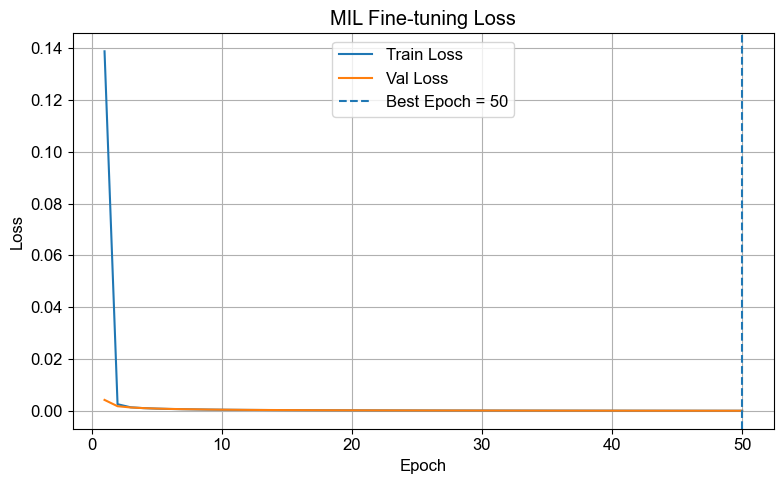

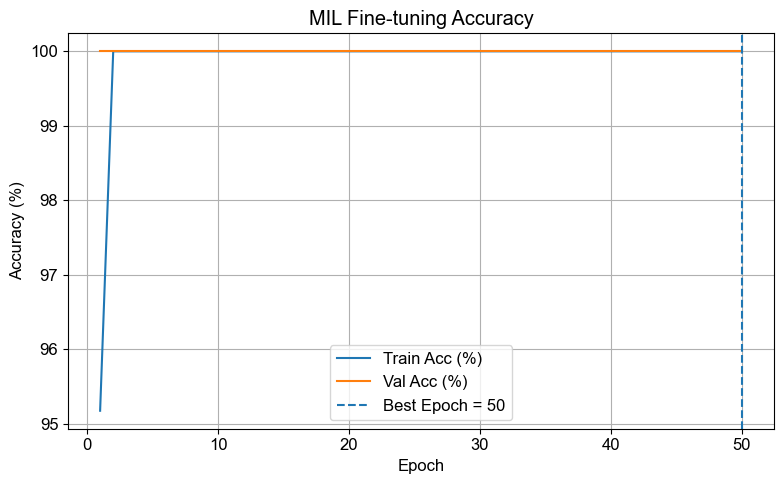

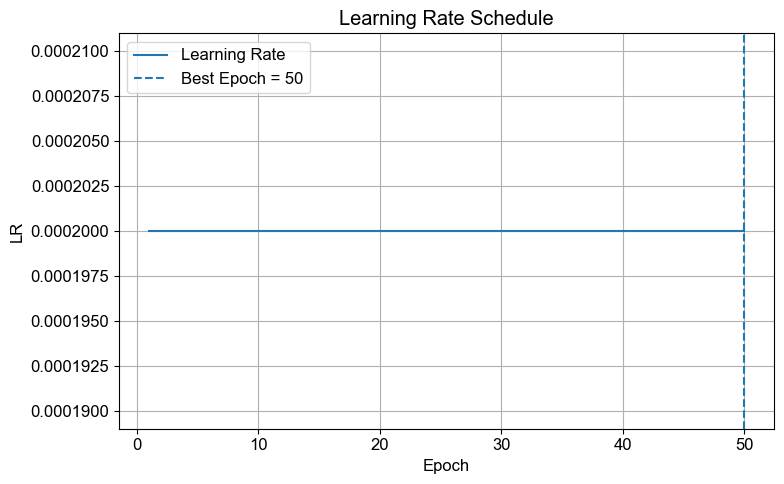

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Path to the saved history
history_path = os.path.join(OUTPUT_DIR, "training_history.npz")
hist = np.load(history_path, allow_pickle=True)

train_loss = hist["train_loss"]
val_loss   = hist["val_loss"]
train_acc  = hist["train_acc"]
val_acc    = hist["val_acc"]
lrs        = hist["learning_rates"]

best_ep    = int(hist["best_epoch"])          # 1-based epoch index
best_val   = float(hist["best_val_acc"])

epochs = np.arange(1, len(train_loss) + 1)

print(f"Loaded: {history_path}")
print(f"Best epoch: {best_ep} | Best val acc: {best_val:.2f}%")

# -------------------
# 1) Loss plot
# -------------------
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.axvline(best_ep, linestyle="--", label=f"Best Epoch = {best_ep}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MIL Fine-tuning Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------
# 2) Accuracy plot
# -------------------
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc, label="Train Acc (%)")
plt.plot(epochs, val_acc, label="Val Acc (%)")
plt.axvline(best_ep, linestyle="--", label=f"Best Epoch = {best_ep}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("MIL Fine-tuning Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------
# 3) Learning rate plot
# -------------------
plt.figure(figsize=(8, 5))
plt.plot(epochs, lrs, label="Learning Rate")
plt.axvline(best_ep, linestyle="--", label=f"Best Epoch = {best_ep}")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# ============================================================
# ATTENTION HEATMAP VISUALIZATION - BurstMAE-MIL
# Visualize which bursts the model pays attention to
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import torch
import torch.nn.functional as F
from scipy.io import loadmat
from scipy.signal import stft

# -------------------------
# CONFIGURATION
# -------------------------
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Paths
PATH_660_MODEL = r"E:\Conferences Umar\Conference 3\Results\660_RPM_BurstMAE_MIL\burstmae_mil_best.pt"
PATH_720_MODEL = r"E:\Conferences Umar\Conference 3\Results\720_RPM_BurstMAE_MIL\burstmae_mil_best.pt"

PATH_660_DATA = r"F:\20240925"
PATH_720_DATA = r"F:\D4B2\720"

OUTPUT_DIR = r"E:\Conferences Umar\Conference 3\Results\Combined_660_720"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Data parameters
CLASS_NAMES = ["BF", "GF", "TF", "N"]
LABEL_MAP = {c: i for i, c in enumerate(CLASS_NAMES)}
FS = 1_000_000

# Processing parameters
WIN_ENERGY = 256
K_MAD_660 = 6.0
K_MAD_720 = 5.0
PEAK_DISTANCE = 800
BURST_LEN = 4096
BURSTS_PER_FILE = 32

# STFT parameters
NFFT = 512
HOP = 128
F_BINS = 128
T_BINS = 128
EPS = 1e-8

print("="*80)
print("EXTRACTING ATTENTION WEIGHTS FROM TRAINED MODELS")
print("="*80)

# -------------------------
# UTILITY FUNCTIONS (copied from training script)
# -------------------------

def find_1d_signal_in_mat(mat_dict):
    candidates = []
    for k, v in mat_dict.items():
        if k.startswith("__"):
            continue
        if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
            arr = np.array(v).squeeze()
            if arr.ndim == 1 and arr.size > 1000:
                candidates.append((k, arr.size, arr))
    if not candidates:
        for k, v in mat_dict.items():
            if k.startswith("__"):
                continue
            if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
                arr = np.array(v).squeeze()
                if arr.size > 1000:
                    return k, arr.reshape(-1).astype(np.float32)
        raise ValueError("No suitable numeric 1D signal found in .mat.")
    candidates.sort(key=lambda x: x[1], reverse=True)
    return candidates[0][0], candidates[0][2].astype(np.float32)

def robust_mad(x):
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-12
    return med, mad

def short_time_energy(x, win):
    x2 = x.astype(np.float64) ** 2
    kernel = np.ones(win, dtype=np.float64)
    return np.convolve(x2, kernel, mode="same").astype(np.float32)

def extract_burst_starts(x, burst_len=4096, win_energy=256, k_mad=6.0, peak_distance=800, max_bursts=32):
    from scipy.signal import find_peaks
    
    if x.size < burst_len + 10:
        return []

    E = short_time_energy(x, win_energy)
    m, mad = robust_mad(E)
    thr = m + k_mad * mad

    peaks, props = find_peaks(E, height=thr, distance=peak_distance)
    if peaks.size == 0:
        mid = x.size // 2
        s = mid - burst_len//2
        s = max(0, min(s, x.size - burst_len))
        return [int(s)]

    heights = props.get("peak_heights", E[peaks])
    order = np.argsort(heights)[::-1]
    peaks = peaks[order]

    half = burst_len // 2
    starts = []
    for p in peaks:
        s = int(p - half)
        if s < 0 or s + burst_len > x.size:
            continue
        starts.append(s)
        if len(starts) >= max_bursts:
            break

    if len(starts) == 0:
        mid = x.size // 2
        s = mid - burst_len//2
        s = max(0, min(s, x.size - burst_len))
        starts = [int(s)]

    return starts

def get_fixed_bursts(x, starts, burst_len=4096, M=32):
    bursts = []
    for s in starts:
        seg = x[s:s+burst_len]
        if seg.size == burst_len:
            bursts.append(seg.astype(np.float32))
    if len(bursts) == 0:
        mid = x.size // 2
        s = mid - burst_len//2
        s = max(0, min(s, x.size - burst_len))
        bursts = [x[s:s+burst_len].astype(np.float32)]

    if len(bursts) >= M:
        bursts = bursts[:M]
    else:
        rep = []
        idx = 0
        while len(bursts) + len(rep) < M:
            rep.append(bursts[idx % len(bursts)])
            idx += 1
        bursts = bursts + rep
    return np.stack(bursts, axis=0)

def burst_to_stft_image(burst, nfft=512, hop=128, f_bins=128, t_bins=128):
    burst = burst.astype(np.float32)
    burst = burst - np.mean(burst)

    f, t, Z = stft(burst, fs=FS, nperseg=nfft, noverlap=nfft-hop, nfft=nfft, boundary=None, padded=False)
    mag = np.abs(Z).astype(np.float32) + EPS
    logmag = np.log(mag)

    mu = np.mean(logmag)
    sd = np.std(logmag) + 1e-6
    logmag = (logmag - mu) / sd

    x = torch.tensor(logmag[None, None, :, :], dtype=torch.float32)
    x = F.interpolate(x, size=(f_bins, t_bins), mode="bilinear", align_corners=False)
    return x.squeeze(0)

# -------------------------
# MODEL CLASSES (must match training script)
# -------------------------

class PatchEmbed(torch.nn.Module):
    def __init__(self, img_size=128, patch=16, in_ch=1, emb=192):
        super().__init__()
        self.proj = torch.nn.Conv2d(in_ch, emb, kernel_size=patch, stride=patch)
        self.num_patches = (img_size // patch) * (img_size // patch)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1,2)
        return x

class MLP(torch.nn.Module):
    def __init__(self, dim, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        hid = int(dim * mlp_ratio)
        self.fc1 = torch.nn.Linear(dim, hid)
        self.fc2 = torch.nn.Linear(hid, dim)
        self.drop = torch.nn.Dropout(drop)
    
    def forward(self, x):
        x = self.drop(F.gelu(self.fc1(x)))
        x = self.drop(self.fc2(x))
        return x

class TransformerBlock(torch.nn.Module):
    def __init__(self, dim, heads=3, drop=0.0):
        super().__init__()
        self.norm1 = torch.nn.LayerNorm(dim)
        self.attn = torch.nn.MultiheadAttention(embed_dim=dim, num_heads=heads, dropout=drop, batch_first=True)
        self.norm2 = torch.nn.LayerNorm(dim)
        self.mlp = MLP(dim, mlp_ratio=4.0, drop=drop)
    
    def forward(self, x):
        h = x
        x = self.norm1(x)
        x, _ = self.attn(x, x, x, need_weights=False)
        x = x + h
        h = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = x + h
        return x

class SimpleMAE(torch.nn.Module):
    def __init__(self, img=128, patch=16, in_ch=1, emb=192, depth=6, heads=3, dec_emb=128, dec_depth=2, dec_heads=4):
        super().__init__()
        self.img = img
        self.patch = patch
        self.patch_embed = PatchEmbed(img_size=img, patch=patch, in_ch=in_ch, emb=emb)
        N = self.patch_embed.num_patches

        self.cls = torch.nn.Parameter(torch.zeros(1,1,emb))
        self.pos = torch.nn.Parameter(torch.zeros(1, N+1, emb))

        self.enc = torch.nn.Sequential(*[TransformerBlock(emb, heads=heads, drop=0.0) for _ in range(depth)])
        self.enc_norm = torch.nn.LayerNorm(emb)

        self.dec_proj = torch.nn.Linear(emb, dec_emb)
        self.mask_token = torch.nn.Parameter(torch.zeros(1,1,dec_emb))
        self.dec_pos = torch.nn.Parameter(torch.zeros(1, N+1, dec_emb))
        self.dec = torch.nn.Sequential(*[TransformerBlock(dec_emb, heads=dec_heads, drop=0.0) for _ in range(dec_depth)])
        self.dec_norm = torch.nn.LayerNorm(dec_emb)

        patch_dim = patch * patch
        self.head = torch.nn.Linear(dec_emb, patch_dim)

        torch.nn.init.trunc_normal_(self.pos, std=0.02)
        torch.nn.init.trunc_normal_(self.dec_pos, std=0.02)
        torch.nn.init.trunc_normal_(self.cls, std=0.02)
        torch.nn.init.trunc_normal_(self.mask_token, std=0.02)

    def encode(self, imgs):
        x = self.patch_embed(imgs)
        B = x.size(0)
        cls = self.cls.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = x + self.pos[:, :x.size(1), :]
        x = self.enc(x)
        x = self.enc_norm(x)
        return x[:,0,:]

class AttentionMIL(torch.nn.Module):
    def __init__(self, in_dim, hid=128, num_classes=4):
        super().__init__()
        self.attn = torch.nn.Sequential(
            torch.nn.Linear(in_dim, hid),
            torch.nn.Tanh(),
            torch.nn.Linear(hid, 1)
        )
        self.cls = torch.nn.Linear(in_dim, num_classes)

    def forward(self, H):
        a = self.attn(H).squeeze(-1)
        w = torch.softmax(a, dim=1).unsqueeze(-1)
        z = (w * H).sum(dim=1)
        logits = self.cls(z)
        return logits, w.squeeze(-1), z

class BurstMAE_MIL(torch.nn.Module):
    def __init__(self, mae, num_classes=4):
        super().__init__()
        self.mae = mae
        self.mil = AttentionMIL(in_dim=192, hid=128, num_classes=num_classes)

    def forward(self, X):
        B, M = X.size(0), X.size(1)
        Xf = X.view(B*M, 1, F_BINS, T_BINS)
        h = self.mae.encode(Xf)
        H = h.view(B, M, -1)
        logits, attn, z = self.mil(H)
        return logits, attn, z

# -------------------------
# LOAD MODELS
# -------------------------

print("\nLoading trained models...")

# Load 660 RPM model
mae_660 = SimpleMAE(img=128, patch=16, in_ch=1, emb=192, depth=6, heads=3, dec_emb=128, dec_depth=2, dec_heads=4)
model_660 = BurstMAE_MIL(mae=mae_660, num_classes=4)
model_660.load_state_dict(torch.load(PATH_660_MODEL, map_location=DEVICE))
model_660.to(DEVICE)
model_660.eval()
print("  ✓ Loaded 660 RPM model")

# Load 720 RPM model
mae_720 = SimpleMAE(img=128, patch=16, in_ch=1, emb=192, depth=6, heads=3, dec_emb=128, dec_depth=2, dec_heads=4)
model_720 = BurstMAE_MIL(mae=mae_720, num_classes=4)
model_720.load_state_dict(torch.load(PATH_720_MODEL, map_location=DEVICE))
model_720.to(DEVICE)
model_720.eval()
print("  ✓ Loaded 720 RPM model")

# -------------------------
# EXTRACT ATTENTION WEIGHTS
# -------------------------

def extract_attention_for_class(model, data_paths, class_name, k_mad, num_samples=10):
    """Extract attention weights for a specific class"""
    
    import glob
    
    # Get file paths for this class
    class_dir = data_paths[class_name]
    files = sorted(glob.glob(os.path.join(class_dir, "*.mat")))[:num_samples]
    
    all_attentions = []
    all_predictions = []
    
    print(f"    Processing {class_name} ({len(files)} files)...")
    
    with torch.no_grad():
        for file_path in files:
            try:
                # Load signal
                md = loadmat(file_path)
                _, sig = find_1d_signal_in_mat(md)
                
                # Extract bursts
                starts = extract_burst_starts(sig, burst_len=BURST_LEN, win_energy=WIN_ENERGY,
                                             k_mad=k_mad, peak_distance=PEAK_DISTANCE,
                                             max_bursts=BURSTS_PER_FILE)
                bursts = get_fixed_bursts(sig, starts, burst_len=BURST_LEN, M=BURSTS_PER_FILE)
                
                # Convert to STFT images
                imgs = []
                for m in range(BURSTS_PER_FILE):
                    imgs.append(burst_to_stft_image(bursts[m], nfft=NFFT, hop=HOP, 
                                                    f_bins=F_BINS, t_bins=T_BINS))
                X = torch.stack(imgs, dim=0).unsqueeze(0)  # (1, M, 1, 128, 128)
                X = X.to(DEVICE)
                
                # Get attention weights
                logits, attn, z = model(X)
                
                # Store
                all_attentions.append(attn.cpu().numpy()[0])  # (32,)
                
                # Get prediction
                pred = torch.argmax(logits, dim=1).item()
                all_predictions.append(pred)
                
            except Exception as e:
                print(f"      Error processing {file_path}: {e}")
                continue
    
    return np.array(all_attentions), np.array(all_predictions)

# -------------------------
# EXTRACT ATTENTION FOR ALL CLASSES
# -------------------------

print("\nExtracting attention weights...")

# 660 RPM
print("\n  660 RPM:")
data_paths_660 = {
    "BF": os.path.join(PATH_660_DATA, "BF660_1", "AE"),
    "GF": os.path.join(PATH_660_DATA, "GF660_1", "AE"),
    "TF": os.path.join(PATH_660_DATA, "TF660_1", "AE"),
    "N":  os.path.join(PATH_660_DATA, "N660_1",  "AE"),
}

attentions_660 = {}
predictions_660 = {}
for class_name in CLASS_NAMES:
    attn, pred = extract_attention_for_class(model_660, data_paths_660, class_name, K_MAD_660, num_samples=10)
    attentions_660[class_name] = attn
    predictions_660[class_name] = pred
    print(f"      {class_name}: {len(attn)} samples, avg attention shape: {attn.shape}")

# 720 RPM
print("\n  720 RPM:")
data_paths_720 = {
    "BF": os.path.join(PATH_720_DATA, "BF720_1", "AE"),
    "GF": os.path.join(PATH_720_DATA, "GF720_1", "AE"),
    "TF": os.path.join(PATH_720_DATA, "TF720_1", "AE"),
    "N":  os.path.join(PATH_720_DATA, "N720_1",  "AE"),
}

attentions_720 = {}
predictions_720 = {}
for class_name in CLASS_NAMES:
    attn, pred = extract_attention_for_class(model_720, data_paths_720, class_name, K_MAD_720, num_samples=10)
    attentions_720[class_name] = attn
    predictions_720[class_name] = pred
    print(f"      {class_name}: {len(attn)} samples, avg attention shape: {attn.shape}")

# -------------------------
# PLOT 1: ATTENTION HEATMAPS (PER-CLASS, 660 RPM)
# -------------------------

print("\nGenerating attention heatmaps...")

def plot_attention_heatmap_single_rpm(attentions, rpm_label, filename):
    """Plot attention heatmap for one RPM"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, class_name in enumerate(CLASS_NAMES):
        ax = axes[idx]
        attn_data = attentions[class_name]
        
        # Plot heatmap
        im = ax.imshow(attn_data, aspect='auto', cmap='YlOrRd', 
                      interpolation='nearest', vmin=0, vmax=np.percentile(attn_data, 95))
        
        ax.set_xlabel('Burst Index', fontsize=16, fontweight='bold')
        ax.set_ylabel('Sample Index', fontsize=16, fontweight='bold')
        ax.set_title(f'{class_name}', fontsize=18, fontweight='bold', pad=15)
        ax.tick_params(axis='both', labelsize=13)
        
        # Set x-axis ticks
        ax.set_xticks(np.arange(0, 32, 4))
        ax.set_xticklabels(np.arange(0, 32, 4), fontweight='bold')
        
        # Set y-axis ticks
        ax.set_yticks(np.arange(len(attn_data)))
        ax.set_yticklabels(np.arange(1, len(attn_data)+1), fontweight='bold')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Attention Weight', fontsize=14, fontweight='bold')
        cbar.ax.tick_params(labelsize=11)
        for label in cbar.ax.get_yticklabels():
            label.set_fontweight('bold')
        
        # Add grid for better readability
        ax.set_xticks(np.arange(32) - 0.5, minor=True)
        ax.set_yticks(np.arange(len(attn_data)) - 0.5, minor=True)
        ax.grid(which='minor', color='white', linestyle='-', linewidth=0.5)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, filename), dpi=1000, bbox_inches='tight')
    plt.close()
    print(f"  ✓ Saved: {filename}")

# Plot for 660 RPM
plot_attention_heatmap_single_rpm(attentions_660, "660", "Attention_Heatmap_660RPM.png")

# Plot for 720 RPM
plot_attention_heatmap_single_rpm(attentions_720, "720", "Attention_Heatmap_720RPM.png")

# -------------------------
# PLOT 2: AVERAGE ATTENTION PER CLASS
# -------------------------

def plot_average_attention(attentions_660, attentions_720, filename):
    """Plot average attention distribution across bursts"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    burst_indices = np.arange(32)
    
    for idx, class_name in enumerate(CLASS_NAMES):
        ax = axes[idx]
        
        # Calculate mean and std for 660
        mean_660 = np.mean(attentions_660[class_name], axis=0)
        std_660 = np.std(attentions_660[class_name], axis=0)
        
        # Calculate mean and std for 720
        mean_720 = np.mean(attentions_720[class_name], axis=0)
        std_720 = np.std(attentions_720[class_name], axis=0)
        
        # Plot with error bands
        ax.plot(burst_indices, mean_660, linewidth=2.5, color='#1f77b4', 
               marker='o', markersize=6, label='660 RPM')
        ax.fill_between(burst_indices, mean_660 - std_660, mean_660 + std_660, 
                        alpha=0.3, color='#1f77b4')
        
        ax.plot(burst_indices, mean_720, linewidth=2.5, color='#ff7f0e', 
               marker='s', markersize=6, label='720 RPM')
        ax.fill_between(burst_indices, mean_720 - std_720, mean_720 + std_720, 
                        alpha=0.3, color='#ff7f0e')
        
        ax.set_xlabel('Burst Index', fontsize=16, fontweight='bold')
        ax.set_ylabel('Mean Attention Weight', fontsize=16, fontweight='bold')
        ax.set_title(f'{class_name}', fontsize=18, fontweight='bold')
        ax.legend(fontsize=13, frameon=True, loc='upper right', prop={'weight': 'bold'})
        ax.grid(alpha=0.3, linestyle='--', linewidth=0.8)
        ax.tick_params(axis='both', labelsize=13)
        ax.set_xlim([-1, 32])
        
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, filename), dpi=1000, bbox_inches='tight')
    plt.close()
    print(f"  ✓ Saved: {filename}")

plot_average_attention(attentions_660, attentions_720, "Average_Attention_Per_Class.png")

# -------------------------
# PLOT 3: TOP-K MOST IMPORTANT BURSTS
# -------------------------

def plot_top_k_bursts(attentions_660, attentions_720, filename, k=5):
    """Show which bursts get highest attention"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, class_name in enumerate(CLASS_NAMES):
        ax = axes[idx]
        
        # Get average attention
        mean_attn_660 = np.mean(attentions_660[class_name], axis=0)
        mean_attn_720 = np.mean(attentions_720[class_name], axis=0)
        
        # Get top-k indices
        top_k_660 = np.argsort(mean_attn_660)[-k:][::-1]
        top_k_720 = np.argsort(mean_attn_720)[-k:][::-1]
        
        # Plot
        x_660 = np.arange(k)
        x_720 = np.arange(k) + 0.4
        
        bars1 = ax.bar(x_660, mean_attn_660[top_k_660], width=0.35, 
                      label='660 RPM', color='#1f77b4', edgecolor='black', linewidth=1.5)
        bars2 = ax.bar(x_720, mean_attn_720[top_k_720], width=0.35, 
                      label='720 RPM', color='#ff7f0e', edgecolor='black', linewidth=1.5)
        
        # Labels
        ax.set_xlabel('Rank', fontsize=16, fontweight='bold')
        ax.set_ylabel('Attention Weight', fontsize=16, fontweight='bold')
        ax.set_title(f'{class_name} - Top {k} Bursts', fontsize=16, fontweight='bold')
        ax.set_xticks(x_660 + 0.2)
        ax.set_xticklabels([f'{i+1}' for i in range(k)], fontweight='bold', fontsize=13)
        ax.legend(fontsize=12, frameon=True, prop={'weight': 'bold'})
        ax.grid(alpha=0.3, linestyle='--', linewidth=0.8, axis='y')
        ax.tick_params(axis='y', labelsize=12)
        
        # Add burst index labels on bars
        for bar, burst_idx in zip(bars1, top_k_660):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'B{burst_idx}', ha='center', va='bottom', 
                   fontsize=9, fontweight='bold')
        
        for bar, burst_idx in zip(bars2, top_k_720):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'B{burst_idx}', ha='center', va='bottom', 
                   fontsize=9, fontweight='bold')
        
        for label in ax.get_yticklabels():
            label.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, filename), dpi=1000, bbox_inches='tight')
    plt.close()
    print(f"  ✓ Saved: {filename}")

plot_top_k_bursts(attentions_660, attentions_720, "Top5_Important_Bursts.png", k=5)

# -------------------------
# SAVE ATTENTION DATA
# -------------------------

print("\nSaving attention data...")

np.savez(os.path.join(OUTPUT_DIR, "attention_weights.npz"),
         attentions_660_BF=attentions_660["BF"],
         attentions_660_GF=attentions_660["GF"],
         attentions_660_TF=attentions_660["TF"],
         attentions_660_N=attentions_660["N"],
         attentions_720_BF=attentions_720["BF"],
         attentions_720_GF=attentions_720["GF"],
         attentions_720_TF=attentions_720["TF"],
         attentions_720_N=attentions_720["N"],
         predictions_660_BF=predictions_660["BF"],
         predictions_660_GF=predictions_660["GF"],
         predictions_660_TF=predictions_660["TF"],
         predictions_660_N=predictions_660["N"],
         predictions_720_BF=predictions_720["BF"],
         predictions_720_GF=predictions_720["GF"],
         predictions_720_TF=predictions_720["TF"],
         predictions_720_N=predictions_720["N"])

print("  ✓ Saved: attention_weights.npz")

# -------------------------
# SUMMARY
# -------------------------

print("\n" + "="*80)
print("✅ ATTENTION VISUALIZATION COMPLETE!")
print("="*80)
print(f"\nAll files saved to: {OUTPUT_DIR}")
print("\nGenerated plots:")
print("  1. Attention_Heatmap_660RPM.png      - 4-panel heatmap (660 RPM)")
print("  2. Attention_Heatmap_720RPM.png      - 4-panel heatmap (720 RPM)")
print("  3. Average_Attention_Per_Class.png   - Mean attention curves")
print("  4. Top5_Important_Bursts.png         - Top-5 most attended bursts")
print("  5. attention_weights.npz             - Raw attention data")
print("\nAll plots: 1000 DPI, publication-ready")
print("\nKey insights:")
for class_name in CLASS_NAMES:
    mean_660 = np.mean(attentions_660[class_name])
    mean_720 = np.mean(attentions_720[class_name])
    max_burst_660 = np.argmax(np.mean(attentions_660[class_name], axis=0))
    max_burst_720 = np.argmax(np.mean(attentions_720[class_name], axis=0))
    print(f"  {class_name}: 660 RPM focuses on burst {max_burst_660} (mean={mean_660:.4f})")
    print(f"  {class_name}: 720 RPM focuses on burst {max_burst_720} (mean={mean_720:.4f})")

print("="*80)

EXTRACTING ATTENTION WEIGHTS FROM TRAINED MODELS

Loading trained models...
  ✓ Loaded 660 RPM model
  ✓ Loaded 720 RPM model

Extracting attention weights...

  660 RPM:
    Processing BF (10 files)...
      BF: 10 samples, avg attention shape: (10, 32)
    Processing GF (10 files)...
      GF: 10 samples, avg attention shape: (10, 32)
    Processing TF (10 files)...
      TF: 10 samples, avg attention shape: (10, 32)
    Processing N (10 files)...
      N: 10 samples, avg attention shape: (10, 32)

  720 RPM:
    Processing BF (10 files)...
      BF: 10 samples, avg attention shape: (10, 32)
    Processing GF (10 files)...
      GF: 10 samples, avg attention shape: (10, 32)
    Processing TF (10 files)...
      TF: 10 samples, avg attention shape: (10, 32)
    Processing N (10 files)...
      N: 10 samples, avg attention shape: (10, 32)

Generating attention heatmaps...
  ✓ Saved: Attention_Heatmap_660RPM.png
  ✓ Saved: Attention_Heatmap_720RPM.png
  ✓ Saved: Average_Attention_Per_Cl

In [16]:
# ============================================================
# RAW ACOUSTIC EMISSION SIGNAL VISUALIZATION
# Time-domain waveforms for all fault classes (660 + 720 RPM)
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.io import loadmat
from scipy.signal import welch, spectrogram
import glob

# -------------------------
# CONFIGURATION
# -------------------------

# Data paths
PATH_660_DATA = r"F:\20240925"
PATH_720_DATA = r"F:\D4B2\720"

# Output
OUTPUT_DIR = r"E:\Conferences Umar\Conference 3\Results\Combined_660_720"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Class names and colors
CLASS_NAMES = ["BF", "GF", "TF", "N"]
CLASS_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Sampling parameters
FS = 1_000_000  # 1 MHz
PLOT_DURATION = 0.1  # seconds (100 ms for visualization)
ZOOM_DURATION = 0.01  # seconds (10 ms for zoomed view)

print("="*80)
print("GENERATING RAW AE SIGNAL VISUALIZATIONS")
print("="*80)

# -------------------------
# UTILITY FUNCTIONS
# -------------------------

def find_1d_signal_in_mat(mat_dict):
    """Extract 1D signal from .mat file"""
    candidates = []
    for k, v in mat_dict.items():
        if k.startswith("__"):
            continue
        if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
            arr = np.array(v).squeeze()
            if arr.ndim == 1 and arr.size > 1000:
                candidates.append((k, arr.size, arr))
    if not candidates:
        for k, v in mat_dict.items():
            if k.startswith("__"):
                continue
            if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
                arr = np.array(v).squeeze()
                if arr.size > 1000:
                    return k, arr.reshape(-1).astype(np.float32)
        raise ValueError("No suitable numeric 1D signal found in .mat.")
    candidates.sort(key=lambda x: x[1], reverse=True)
    return candidates[0][0], candidates[0][2].astype(np.float32)

def load_signal_from_class(data_path, class_name, file_index=0):
    """Load one signal from a specific class"""
    class_dir = os.path.join(data_path, f"{class_name}*", "AE")
    files = sorted(glob.glob(os.path.join(class_dir, "*.mat")))
    
    if len(files) == 0:
        raise ValueError(f"No files found in {class_dir}")
    
    file_path = files[file_index]
    md = loadmat(file_path)
    _, signal = find_1d_signal_in_mat(md)
    
    return signal, file_path

# -------------------------
# PLOT 1: FULL SIGNAL OVERVIEW (4-CLASS COMPARISON)
# -------------------------

def plot_full_signals_comparison(rpm="660"):
    """Plot full time-domain signals for all 4 classes"""
    
    print(f"\n1. Plotting full signal overview ({rpm} RPM)...")
    
    data_path = PATH_660_DATA if rpm == "660" else PATH_720_DATA
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 12))
    
    for idx, (class_name, color) in enumerate(zip(CLASS_NAMES, CLASS_COLORS)):
        try:
            signal, file_path = load_signal_from_class(data_path, class_name, file_index=0)
            
            # Limit to plot duration
            n_samples = int(PLOT_DURATION * FS)
            signal_plot = signal[:n_samples]
            time = np.arange(len(signal_plot)) / FS * 1000  # Convert to ms
            
            # Plot
            axes[idx].plot(time, signal_plot, linewidth=0.5, color=color, alpha=0.8)
            axes[idx].set_ylabel('Amplitude (V)', fontsize=14, fontweight='bold')
            axes[idx].set_title(f'{class_name}', fontsize=16, fontweight='bold', pad=10)
            axes[idx].grid(alpha=0.3, linestyle='--', linewidth=0.5)
            axes[idx].tick_params(axis='both', labelsize=12)
            
            # Add statistics text
            stats_text = f'Mean: {np.mean(signal_plot):.3f} V\nStd: {np.std(signal_plot):.3f} V\nPeak: {np.max(np.abs(signal_plot)):.3f} V'
            axes[idx].text(0.98, 0.95, stats_text, transform=axes[idx].transAxes,
                          fontsize=10, verticalalignment='top', horizontalalignment='right',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                          fontweight='bold')
            
            for label in axes[idx].get_xticklabels() + axes[idx].get_yticklabels():
                label.set_fontweight('bold')
            
            print(f"    ✓ {class_name}: Signal length = {len(signal)/1e6:.2f} s")
            
        except Exception as e:
            print(f"    ✗ Error loading {class_name}: {e}")
    
    axes[-1].set_xlabel('Time (ms)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"AE_TimeDomain_Full_{rpm}RPM.png"), 
               dpi=1000, bbox_inches='tight')
    plt.close()
    print(f"  ✓ Saved: AE_TimeDomain_Full_{rpm}RPM.png")

# Plot for both RPMs
plot_full_signals_comparison(rpm="660")
plot_full_signals_comparison(rpm="720")

# -------------------------
# PLOT 2: ZOOMED BURST EVENTS (DETAILED VIEW)
# -------------------------

def plot_zoomed_bursts(rpm="660"):
    """Plot zoomed-in view of burst events"""
    
    print(f"\n2. Plotting zoomed burst events ({rpm} RPM)...")
    
    data_path = PATH_660_DATA if rpm == "660" else PATH_720_DATA
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    
    for idx, (class_name, color) in enumerate(zip(CLASS_NAMES, CLASS_COLORS)):
        try:
            signal, _ = load_signal_from_class(data_path, class_name, file_index=0)
            
            # Find a high-energy region (potential burst)
            # Use simple energy-based detection
            window_size = 1000
            energy = np.convolve(signal**2, np.ones(window_size)/window_size, mode='same')
            peak_idx = np.argmax(energy)
            
            # Extract zoom region
            n_samples_zoom = int(ZOOM_DURATION * FS)
            start_idx = max(0, peak_idx - n_samples_zoom // 2)
            end_idx = min(len(signal), start_idx + n_samples_zoom)
            
            signal_zoom = signal[start_idx:end_idx]
            time_zoom = np.arange(len(signal_zoom)) / FS * 1000  # ms
            
            # Plot
            axes[idx].plot(time_zoom, signal_zoom, linewidth=1.0, color=color, alpha=0.9)
            axes[idx].set_ylabel('Amplitude (V)', fontsize=14, fontweight='bold')
            axes[idx].set_title(f'{class_name} - Burst Event', fontsize=16, fontweight='bold', pad=10)
            axes[idx].grid(alpha=0.3, linestyle='--', linewidth=0.5)
            axes[idx].tick_params(axis='both', labelsize=12)
            
            # Highlight envelope
            from scipy.signal import hilbert
            analytic_signal = hilbert(signal_zoom)
            envelope = np.abs(analytic_signal)
            axes[idx].plot(time_zoom, envelope, linewidth=1.5, color='red', 
                          alpha=0.6, linestyle='--', label='Envelope')
            axes[idx].plot(time_zoom, -envelope, linewidth=1.5, color='red', 
                          alpha=0.6, linestyle='--')
            
            axes[idx].legend(fontsize=11, loc='upper right', frameon=True)
            
            for label in axes[idx].get_xticklabels() + axes[idx].get_yticklabels():
                label.set_fontweight('bold')
            
        except Exception as e:
            print(f"    ✗ Error processing {class_name}: {e}")
    
    axes[-1].set_xlabel('Time (ms)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"AE_TimeDomain_Zoomed_{rpm}RPM.png"), 
               dpi=1000, bbox_inches='tight')
    plt.close()
    print(f"  ✓ Saved: AE_TimeDomain_Zoomed_{rpm}RPM.png")

plot_zoomed_bursts(rpm="660")
plot_zoomed_bursts(rpm="720")

# -------------------------
# PLOT 3: MULTI-SAMPLE COMPARISON (SHOW VARIABILITY)
# -------------------------

def plot_multi_sample_comparison(rpm="660", n_samples=3):
    """Plot multiple samples from each class to show variability"""
    
    print(f"\n3. Plotting multi-sample comparison ({rpm} RPM)...")
    
    data_path = PATH_660_DATA if rpm == "660" else PATH_720_DATA
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 12))
    
    for idx, (class_name, base_color) in enumerate(zip(CLASS_NAMES, CLASS_COLORS)):
        try:
            # Load multiple samples
            for sample_idx in range(n_samples):
                signal, _ = load_signal_from_class(data_path, class_name, file_index=sample_idx)
                
                # Extract segment
                n_samples_plot = int(0.05 * FS)  # 50 ms
                signal_plot = signal[:n_samples_plot]
                time = np.arange(len(signal_plot)) / FS * 1000
                
                # Plot with varying alpha
                alpha = 0.9 - (sample_idx * 0.2)
                axes[idx].plot(time, signal_plot, linewidth=0.8, color=base_color, 
                             alpha=alpha, label=f'Sample {sample_idx+1}')
            
            axes[idx].set_ylabel('Amplitude (V)', fontsize=14, fontweight='bold')
            axes[idx].set_title(f'{class_name} - {n_samples} Samples', 
                              fontsize=16, fontweight='bold', pad=10)
            axes[idx].grid(alpha=0.3, linestyle='--', linewidth=0.5)
            axes[idx].tick_params(axis='both', labelsize=12)
            axes[idx].legend(fontsize=10, loc='upper right', frameon=True)
            
            for label in axes[idx].get_xticklabels() + axes[idx].get_yticklabels():
                label.set_fontweight('bold')
            
        except Exception as e:
            print(f"    ✗ Error processing {class_name}: {e}")
    
    axes[-1].set_xlabel('Time (ms)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"AE_TimeDomain_MultiSample_{rpm}RPM.png"), 
               dpi=1000, bbox_inches='tight')
    plt.close()
    print(f"  ✓ Saved: AE_TimeDomain_MultiSample_{rpm}RPM.png")

plot_multi_sample_comparison(rpm="660", n_samples=3)
plot_multi_sample_comparison(rpm="720", n_samples=3)

# -------------------------
# PLOT 4: TIME-FREQUENCY REPRESENTATION (SPECTROGRAM)
# -------------------------

def plot_spectrograms(rpm="660"):
    """Plot time-frequency spectrograms for all classes"""
    
    print(f"\n4. Plotting spectrograms ({rpm} RPM)...")
    
    data_path = PATH_660_DATA if rpm == "660" else PATH_720_DATA
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 14))
    
    for idx, (class_name, color) in enumerate(zip(CLASS_NAMES, CLASS_COLORS)):
        try:
            signal, _ = load_signal_from_class(data_path, class_name, file_index=0)
            
            # Limit duration for spectrogram
            n_samples = int(0.1 * FS)  # 100 ms
            signal_spec = signal[:n_samples]
            
            # Compute spectrogram
            f, t, Sxx = spectrogram(signal_spec, fs=FS, nperseg=2048, 
                                   noverlap=1024, nfft=2048)
            
            # Convert to dB
            Sxx_db = 10 * np.log10(Sxx + 1e-10)
            
            # Plot
            im = axes[idx].pcolormesh(t * 1000, f / 1000, Sxx_db, 
                                     shading='gouraud', cmap='jet', 
                                     vmin=np.percentile(Sxx_db, 5), 
                                     vmax=np.percentile(Sxx_db, 95))
            
            axes[idx].set_ylabel('Frequency (kHz)', fontsize=14, fontweight='bold')
            axes[idx].set_title(f'{class_name} - Spectrogram', 
                              fontsize=16, fontweight='bold', pad=10)
            axes[idx].set_ylim([0, 500])  # Focus on 0-500 kHz
            axes[idx].tick_params(axis='both', labelsize=12)
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=axes[idx])
            cbar.set_label('Power (dB)', fontsize=12, fontweight='bold')
            cbar.ax.tick_params(labelsize=10)
            
            for label in axes[idx].get_xticklabels() + axes[idx].get_yticklabels():
                label.set_fontweight('bold')
            
        except Exception as e:
            print(f"    ✗ Error processing {class_name}: {e}")
    
    axes[-1].set_xlabel('Time (ms)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"AE_Spectrogram_{rpm}RPM.png"), 
               dpi=1000, bbox_inches='tight')
    plt.close()
    print(f"  ✓ Saved: AE_Spectrogram_{rpm}RPM.png")

plot_spectrograms(rpm="660")
plot_spectrograms(rpm="720")

# -------------------------
# PLOT 5: STATISTICAL COMPARISON (HISTOGRAM + PDF)
# -------------------------

def plot_amplitude_distribution(rpm="660"):
    """Plot amplitude distribution for all classes"""
    
    print(f"\n5. Plotting amplitude distributions ({rpm} RPM)...")
    
    data_path = PATH_660_DATA if rpm == "660" else PATH_720_DATA
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, (class_name, color) in enumerate(zip(CLASS_NAMES, CLASS_COLORS)):
        try:
            signal, _ = load_signal_from_class(data_path, class_name, file_index=0)
            
            # Use first 1 second of data
            signal_stat = signal[:int(FS)]
            
            # Plot histogram
            axes[idx].hist(signal_stat, bins=100, density=True, alpha=0.7, 
                          color=color, edgecolor='black', linewidth=0.5)
            
            # Overlay normal distribution
            from scipy.stats import norm
            mu, std = norm.fit(signal_stat)
            x = np.linspace(signal_stat.min(), signal_stat.max(), 100)
            axes[idx].plot(x, norm.pdf(x, mu, std), 'r-', linewidth=2.5, 
                          label=f'Normal fit\nμ={mu:.3f}\nσ={std:.3f}')
            
            axes[idx].set_xlabel('Amplitude (V)', fontsize=14, fontweight='bold')
            axes[idx].set_ylabel('Probability Density', fontsize=14, fontweight='bold')
            axes[idx].set_title(f'{class_name}', fontsize=16, fontweight='bold', pad=10)
            axes[idx].legend(fontsize=11, loc='upper right', frameon=True, 
                           prop={'weight': 'bold'})
            axes[idx].grid(alpha=0.3, linestyle='--', linewidth=0.5)
            axes[idx].tick_params(axis='both', labelsize=12)
            
            for label in axes[idx].get_xticklabels() + axes[idx].get_yticklabels():
                label.set_fontweight('bold')
            
        except Exception as e:
            print(f"    ✗ Error processing {class_name}: {e}")
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"AE_Amplitude_Distribution_{rpm}RPM.png"), 
               dpi=1000, bbox_inches='tight')
    plt.close()
    print(f"  ✓ Saved: AE_Amplitude_Distribution_{rpm}RPM.png")

plot_amplitude_distribution(rpm="660")
plot_amplitude_distribution(rpm="720")

# -------------------------
# PLOT 6: COMBINED 660 vs 720 COMPARISON
# -------------------------

def plot_660_vs_720_comparison():
    """Side-by-side comparison of 660 vs 720 RPM"""
    
    print(f"\n6. Plotting 660 vs 720 RPM comparison...")
    
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(4, 2, figure=fig, hspace=0.3, wspace=0.25)
    
    for idx, class_name in enumerate(CLASS_NAMES):
        # 660 RPM
        try:
            signal_660, _ = load_signal_from_class(PATH_660_DATA, class_name, file_index=0)
            n_samples = int(0.05 * FS)
            signal_660 = signal_660[:n_samples]
            time = np.arange(len(signal_660)) / FS * 1000
            
            ax1 = fig.add_subplot(gs[idx, 0])
            ax1.plot(time, signal_660, linewidth=0.8, color=CLASS_COLORS[idx], alpha=0.9)
            ax1.set_ylabel('Amplitude (V)', fontsize=13, fontweight='bold')
            if idx == 0:
                ax1.set_title('660 RPM', fontsize=16, fontweight='bold', pad=15)
            ax1.text(0.02, 0.95, class_name, transform=ax1.transAxes,
                    fontsize=14, fontweight='bold', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            ax1.grid(alpha=0.3, linestyle='--', linewidth=0.5)
            ax1.tick_params(axis='both', labelsize=11)
            for label in ax1.get_xticklabels() + ax1.get_yticklabels():
                label.set_fontweight('bold')
            
        except Exception as e:
            print(f"    ✗ Error: 660 RPM {class_name}: {e}")
        
        # 720 RPM
        try:
            signal_720, _ = load_signal_from_class(PATH_720_DATA, class_name, file_index=0)
            signal_720 = signal_720[:n_samples]
            
            ax2 = fig.add_subplot(gs[idx, 1])
            ax2.plot(time, signal_720, linewidth=0.8, color=CLASS_COLORS[idx], alpha=0.9)
            ax2.set_ylabel('Amplitude (V)', fontsize=13, fontweight='bold')
            if idx == 0:
                ax2.set_title('720 RPM', fontsize=16, fontweight='bold', pad=15)
            ax2.text(0.02, 0.95, class_name, transform=ax2.transAxes,
                    fontsize=14, fontweight='bold', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            ax2.grid(alpha=0.3, linestyle='--', linewidth=0.5)
            ax2.tick_params(axis='both', labelsize=11)
            for label in ax2.get_xticklabels() + ax2.get_yticklabels():
                label.set_fontweight('bold')
            
        except Exception as e:
            print(f"    ✗ Error: 720 RPM {class_name}: {e}")
    
    # Add common x-label
    fig.text(0.5, 0.02, 'Time (ms)', ha='center', fontsize=14, fontweight='bold')
    
    plt.savefig(os.path.join(OUTPUT_DIR, "AE_TimeDomain_660vs720_Comparison.png"), 
               dpi=1000, bbox_inches='tight')
    plt.close()
    print(f"  ✓ Saved: AE_TimeDomain_660vs720_Comparison.png")

plot_660_vs_720_comparison()

# -------------------------
# PLOT 7: POWER SPECTRAL DENSITY (PSD)
# -------------------------

def plot_psd_comparison(rpm="660"):
    """Plot Power Spectral Density for all classes"""
    
    print(f"\n7. Plotting PSD ({rpm} RPM)...")
    
    data_path = PATH_660_DATA if rpm == "660" else PATH_720_DATA
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    for idx, (class_name, color) in enumerate(zip(CLASS_NAMES, CLASS_COLORS)):
        try:
            signal, _ = load_signal_from_class(data_path, class_name, file_index=0)
            
            # Compute PSD
            f, Pxx = welch(signal, fs=FS, nperseg=4096, noverlap=2048)
            
            # Convert to dB
            Pxx_db = 10 * np.log10(Pxx + 1e-10)
            
            # Plot (limit to 500 kHz)
            mask = f <= 500e3
            ax.plot(f[mask] / 1000, Pxx_db[mask], linewidth=2, 
                   color=color, alpha=0.8, label=class_name)
            
        except Exception as e:
            print(f"    ✗ Error processing {class_name}: {e}")
    
    ax.set_xlabel('Frequency (kHz)', fontsize=16, fontweight='bold')
    ax.set_ylabel('Power Spectral Density (dB/Hz)', fontsize=16, fontweight='bold')
    ax.set_title(f'Power Spectral Density - {rpm} RPM', fontsize=18, fontweight='bold', pad=15)
    ax.legend(fontsize=14, loc='upper right', frameon=True, prop={'weight': 'bold'})
    ax.grid(alpha=0.3, linestyle='--', linewidth=0.8)
    ax.tick_params(axis='both', labelsize=13)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"AE_PSD_{rpm}RPM.png"), 
               dpi=1000, bbox_inches='tight')
    plt.close()
    print(f"  ✓ Saved: AE_PSD_{rpm}RPM.png")

plot_psd_comparison(rpm="660")
plot_psd_comparison(rpm="720")

# -------------------------
# SUMMARY
# -------------------------

print("\n" + "="*80)
print("✅ RAW AE SIGNAL VISUALIZATION COMPLETE!")
print("="*80)
print(f"\nAll files saved to: {OUTPUT_DIR}")
print("\nGenerated plots:")
print("  660 RPM:")
print("    1. AE_TimeDomain_Full_660RPM.png          - Full signal overview (4 classes)")
print("    2. AE_TimeDomain_Zoomed_660RPM.png        - Zoomed burst events")
print("    3. AE_TimeDomain_MultiSample_660RPM.png   - Multi-sample variability")
print("    4. AE_Spectrogram_660RPM.png              - Time-frequency analysis")
print("    5. AE_Amplitude_Distribution_660RPM.png   - Statistical distribution")
print("    6. AE_PSD_660RPM.png                      - Power spectral density")
print("\n  720 RPM:")
print("    7. AE_TimeDomain_Full_720RPM.png          - Full signal overview (4 classes)")
print("    8. AE_TimeDomain_Zoomed_720RPM.png        - Zoomed burst events")
print("    9. AE_TimeDomain_MultiSample_720RPM.png   - Multi-sample variability")
print("    10. AE_Spectrogram_720RPM.png             - Time-frequency analysis")
print("    11. AE_Amplitude_Distribution_720RPM.png  - Statistical distribution")
print("    12. AE_PSD_720RPM.png                     - Power spectral density")
print("\n  Combined:")
print("    13. AE_TimeDomain_660vs720_Comparison.png - Side-by-side comparison")
print("\nAll plots: 1000 DPI, publication-ready")
print("="*80)

GENERATING RAW AE SIGNAL VISUALIZATIONS

1. Plotting full signal overview (660 RPM)...
    ✓ BF: Signal length = 1.00 s
    ✓ GF: Signal length = 1.00 s
    ✓ TF: Signal length = 1.00 s
    ✓ N: Signal length = 1.00 s
  ✓ Saved: AE_TimeDomain_Full_660RPM.png

1. Plotting full signal overview (720 RPM)...
    ✓ BF: Signal length = 1.00 s
    ✓ GF: Signal length = 1.00 s
    ✓ TF: Signal length = 1.00 s
    ✓ N: Signal length = 1.00 s
  ✓ Saved: AE_TimeDomain_Full_720RPM.png

2. Plotting zoomed burst events (660 RPM)...
  ✓ Saved: AE_TimeDomain_Zoomed_660RPM.png

2. Plotting zoomed burst events (720 RPM)...
  ✓ Saved: AE_TimeDomain_Zoomed_720RPM.png

3. Plotting multi-sample comparison (660 RPM)...
  ✓ Saved: AE_TimeDomain_MultiSample_660RPM.png

3. Plotting multi-sample comparison (720 RPM)...
  ✓ Saved: AE_TimeDomain_MultiSample_720RPM.png

4. Plotting spectrograms (660 RPM)...
  ✓ Saved: AE_Spectrogram_660RPM.png

4. Plotting spectrograms (720 RPM)...
  ✓ Saved: AE_Spectrogram_720RPM.

In [17]:
# ============================================================
# SINGLE RAW AE SIGNAL - BEARING FAULT (BF)
# Publication-quality time-domain waveform
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert
import glob

# -------------------------
# CONFIGURATION
# -------------------------

# Choose RPM
RPM = "660"  # Change to "720" if you want 720 RPM

# Data paths
if RPM == "660":
    DATA_PATH = r"F:\20240925\BF660_1\AE"
else:
    DATA_PATH = r"F:\D4B2\720\BF720_1\AE"

# Output
OUTPUT_DIR = r"E:\Conferences Umar\Conference 3\Results\Combined_660_720"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Sampling parameters
FS = 1_000_000  # 1 MHz
DURATION = 0.1  # 100 ms (adjust as needed)

print("="*80)
print(f"PLOTTING SINGLE BF TIME-DOMAIN SIGNAL ({RPM} RPM)")
print("="*80)

# -------------------------
# LOAD SIGNAL
# -------------------------

def find_1d_signal_in_mat(mat_dict):
    """Extract 1D signal from .mat file"""
    candidates = []
    for k, v in mat_dict.items():
        if k.startswith("__"):
            continue
        if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
            arr = np.array(v).squeeze()
            if arr.ndim == 1 and arr.size > 1000:
                candidates.append((k, arr.size, arr))
    if not candidates:
        for k, v in mat_dict.items():
            if k.startswith("__"):
                continue
            if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
                arr = np.array(v).squeeze()
                if arr.size > 1000:
                    return k, arr.reshape(-1).astype(np.float32)
        raise ValueError("No suitable numeric 1D signal found in .mat.")
    candidates.sort(key=lambda x: x[1], reverse=True)
    return candidates[0][0], candidates[0][2].astype(np.float32)

# Get first .mat file
files = sorted(glob.glob(os.path.join(DATA_PATH, "*.mat")))
if len(files) == 0:
    raise ValueError(f"No .mat files found in {DATA_PATH}")

print(f"\nLoading file: {os.path.basename(files[0])}")

# Load signal
md = loadmat(files[0])
var_name, signal = find_1d_signal_in_mat(md)

print(f"  Variable name: {var_name}")
print(f"  Signal length: {len(signal)/1e6:.2f} seconds")
print(f"  Sampling rate: {FS/1e6:.1f} MHz")

# -------------------------
# EXTRACT PLOT SEGMENT
# -------------------------

n_samples = int(DURATION * FS)
signal_plot = signal[:n_samples]
time_ms = np.arange(len(signal_plot)) / FS * 1000  # Convert to milliseconds

# Calculate statistics
mean_val = np.mean(signal_plot)
std_val = np.std(signal_plot)
peak_val = np.max(np.abs(signal_plot))
rms_val = np.sqrt(np.mean(signal_plot**2))

print(f"\nSignal statistics:")
print(f"  Mean: {mean_val:.6f} V")
print(f"  Std:  {std_val:.6f} V")
print(f"  RMS:  {rms_val:.6f} V")
print(f"  Peak: {peak_val:.6f} V")

# -------------------------
# PLOT SINGLE SIGNAL
# -------------------------

fig, ax = plt.subplots(figsize=(14, 6))

# Plot waveform
ax.plot(time_ms, signal_plot, linewidth=0.8, color='#1f77b4', alpha=0.9, label='BF Signal')

# Formatting
ax.set_xlabel('Time (ms)', fontsize=18, fontweight='bold')
ax.set_ylabel('Amplitude (V)', fontsize=18, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax.tick_params(axis='both', labelsize=14, width=1.5)

# Make tick labels bold
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# Add statistics box
stats_text = f'Mean: {mean_val:.4f} V\nStd: {std_val:.4f} V\nRMS: {rms_val:.4f} V\nPeak: {peak_val:.4f} V'
ax.text(0.98, 0.97, stats_text, 
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
        fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f"BF_TimeDomain_{RPM}RPM.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()

print(f"\n✓ Saved: BF_TimeDomain_{RPM}RPM.png")
print(f"  Location: {OUTPUT_DIR}")

# -------------------------
# ALTERNATIVE: WITH ENVELOPE
# -------------------------

fig, ax = plt.subplots(figsize=(14, 6))

# Plot waveform
ax.plot(time_ms, signal_plot, linewidth=0.8, color='#1f77b4', alpha=0.9, label='BF Signal')

# Add envelope using Hilbert transform
analytic_signal = hilbert(signal_plot)
envelope = np.abs(analytic_signal)
ax.plot(time_ms, envelope, linewidth=1.5, color='red', alpha=0.7, 
       linestyle='--', label='Envelope')
ax.plot(time_ms, -envelope, linewidth=1.5, color='red', alpha=0.7, linestyle='--')

# Formatting
ax.set_xlabel('Time (ms)', fontsize=18, fontweight='bold')
ax.set_ylabel('Amplitude (V)', fontsize=18, fontweight='bold')
ax.legend(fontsize=14, loc='upper right', frameon=True, prop={'weight': 'bold'})
ax.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax.tick_params(axis='both', labelsize=14, width=1.5)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f"BF_TimeDomain_Envelope_{RPM}RPM.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()

print(f"✓ Saved: BF_TimeDomain_Envelope_{RPM}RPM.png")

# -------------------------
# ALTERNATIVE: ZOOMED VIEW (10 ms)
# -------------------------

# Find high-energy region for zoom
window_size = 1000
energy = np.convolve(signal**2, np.ones(window_size)/window_size, mode='same')
peak_idx = np.argmax(energy)

# Extract zoom region (10 ms)
zoom_duration = 0.01  # 10 ms
n_samples_zoom = int(zoom_duration * FS)
start_idx = max(0, peak_idx - n_samples_zoom // 2)
end_idx = min(len(signal), start_idx + n_samples_zoom)

signal_zoom = signal[start_idx:end_idx]
time_zoom = np.arange(len(signal_zoom)) / FS * 1000

fig, ax = plt.subplots(figsize=(12, 6))

# Plot zoomed waveform
ax.plot(time_zoom, signal_zoom, linewidth=1.2, color='#1f77b4', alpha=0.9)

# Add envelope
analytic_zoom = hilbert(signal_zoom)
envelope_zoom = np.abs(analytic_zoom)
ax.plot(time_zoom, envelope_zoom, linewidth=1.8, color='red', alpha=0.7, 
       linestyle='--', label='Envelope')
ax.plot(time_zoom, -envelope_zoom, linewidth=1.8, color='red', alpha=0.7, linestyle='--')

# Formatting
ax.set_xlabel('Time (ms)', fontsize=18, fontweight='bold')
ax.set_ylabel('Amplitude (V)', fontsize=18, fontweight='bold')
ax.legend(fontsize=14, loc='upper right', frameon=True, prop={'weight': 'bold'})
ax.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax.tick_params(axis='both', labelsize=14, width=1.5)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f"BF_TimeDomain_Zoomed_{RPM}RPM.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()

print(f"✓ Saved: BF_TimeDomain_Zoomed_{RPM}RPM.png")

# -------------------------
# SUMMARY
# -------------------------

print("\n" + "="*80)
print("✅ BF SIGNAL VISUALIZATION COMPLETE!")
print("="*80)
print(f"\nGenerated 3 plots:")
print(f"  1. BF_TimeDomain_{RPM}RPM.png          - Clean waveform")
print(f"  2. BF_TimeDomain_Envelope_{RPM}RPM.png - With envelope overlay")
print(f"  3. BF_TimeDomain_Zoomed_{RPM}RPM.png   - 10 ms burst detail")
print(f"\nAll saved to: {OUTPUT_DIR}")
print("="*80)

PLOTTING SINGLE BF TIME-DOMAIN SIGNAL (660 RPM)

Loading file: 20240925_234721_AE.mat
  Variable name: signals
  Signal length: 1.00 seconds
  Sampling rate: 1.0 MHz

Signal statistics:
  Mean: 0.000418 V
  Std:  0.032798 V
  RMS:  0.032800 V
  Peak: 0.735985 V

✓ Saved: BF_TimeDomain_660RPM.png
  Location: E:\Conferences Umar\Conference 3\Results\Combined_660_720
✓ Saved: BF_TimeDomain_Envelope_660RPM.png
✓ Saved: BF_TimeDomain_Zoomed_660RPM.png

✅ BF SIGNAL VISUALIZATION COMPLETE!

Generated 3 plots:
  1. BF_TimeDomain_660RPM.png          - Clean waveform
  2. BF_TimeDomain_Envelope_660RPM.png - With envelope overlay
  3. BF_TimeDomain_Zoomed_660RPM.png   - 10 ms burst detail

All saved to: E:\Conferences Umar\Conference 3\Results\Combined_660_720


In [21]:
# ============================================================
# TIME-FREQUENCY TRANSFORM WITH BURST EVENT DETECTION
# Visualizes burst extraction pipeline for BurstMAE-MIL
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
from scipy.io import loadmat
from scipy.signal import find_peaks, stft
import glob

# -------------------------
# CONFIGURATION
# -------------------------

# Choose class and RPM
CLASS_NAME = "BF"  # Change to "GF", "TF", or "N"
RPM = "660"        # Change to "720" if needed

# Data paths
if RPM == "660":
    if CLASS_NAME == "BF":
        DATA_PATH = r"F:\20240925\BF660_1\AE"
    elif CLASS_NAME == "GF":
        DATA_PATH = r"F:\20240925\GF660_1\AE"
    elif CLASS_NAME == "TF":
        DATA_PATH = r"F:\20240925\TF660_1\AE"
    else:  # N
        DATA_PATH = r"F:\20240925\N660_1\AE"
else:  # 720
    if CLASS_NAME == "BF":
        DATA_PATH = r"F:\D4B2\720\BF720_1\AE"
    elif CLASS_NAME == "GF":
        DATA_PATH = r"F:\D4B2\720\GF720_1\AE"
    elif CLASS_NAME == "TF":
        DATA_PATH = r"F:\D4B2\720\TF720_1\AE"
    else:  # N
        DATA_PATH = r"F:\D4B2\720\N720_1\AE"

# Output
OUTPUT_DIR = r"E:\Conferences Umar\Conference 3\Results\Combined_660_720"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Sampling parameters
FS = 1_000_000  # 1 MHz

# Burst detection parameters (same as training)
WIN_ENERGY = 256
K_MAD = 6.0 if RPM == "660" else 5.0
PEAK_DISTANCE = 800
BURST_LEN = 4096
MAX_BURSTS = 10  # For visualization (limit to avoid clutter)

# STFT parameters (same as training)
NFFT = 512
HOP = 128

print("="*80)
print(f"TIME-FREQUENCY ANALYSIS WITH BURST DETECTION")
print(f"Class: {CLASS_NAME} | RPM: {RPM}")
print("="*80)

# -------------------------
# UTILITY FUNCTIONS
# -------------------------

def find_1d_signal_in_mat(mat_dict):
    """Extract 1D signal from .mat file"""
    candidates = []
    for k, v in mat_dict.items():
        if k.startswith("__"):
            continue
        if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
            arr = np.array(v).squeeze()
            if arr.ndim == 1 and arr.size > 1000:
                candidates.append((k, arr.size, arr))
    if not candidates:
        for k, v in mat_dict.items():
            if k.startswith("__"):
                continue
            if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
                arr = np.array(v).squeeze()
                if arr.size > 1000:
                    return k, arr.reshape(-1).astype(np.float32)
        raise ValueError("No suitable numeric 1D signal found in .mat.")
    candidates.sort(key=lambda x: x[1], reverse=True)
    return candidates[0][0], candidates[0][2].astype(np.float32)

def robust_mad(x):
    """Robust median absolute deviation"""
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-12
    return med, mad

def short_time_energy(x, win):
    """Compute short-time energy"""
    x2 = x.astype(np.float64) ** 2
    kernel = np.ones(win, dtype=np.float64)
    return np.convolve(x2, kernel, mode="same").astype(np.float32)

def extract_burst_starts(x, burst_len=4096, win_energy=256, k_mad=6.0, 
                        peak_distance=800, max_bursts=10):
    """Extract burst start indices using robust energy detection"""
    
    if x.size < burst_len + 10:
        return []

    # Compute short-time energy
    E = short_time_energy(x, win_energy)
    
    # Robust threshold
    m, mad = robust_mad(E)
    thr = m + k_mad * mad

    # Find peaks
    peaks, props = find_peaks(E, height=thr, distance=peak_distance)
    
    if peaks.size == 0:
        # Fallback: center window
        mid = x.size // 2
        s = mid - burst_len//2
        s = max(0, min(s, x.size - burst_len))
        return [int(s)], E, thr, []

    # Sort by height
    heights = props.get("peak_heights", E[peaks])
    order = np.argsort(heights)[::-1]
    peaks = peaks[order]

    # Extract valid burst starts
    half = burst_len // 2
    starts = []
    for p in peaks:
        s = int(p - half)
        if s < 0 or s + burst_len > x.size:
            continue
        starts.append(s)
        if len(starts) >= max_bursts:
            break

    if len(starts) == 0:
        mid = x.size // 2
        s = mid - burst_len//2
        s = max(0, min(s, x.size - burst_len))
        starts = [int(s)]

    return starts, E, thr, peaks

# -------------------------
# LOAD SIGNAL
# -------------------------

print(f"\nLoading signal...")
files = sorted(glob.glob(os.path.join(DATA_PATH, "*.mat")))
if len(files) == 0:
    raise ValueError(f"No .mat files found in {DATA_PATH}")

# Load first file
md = loadmat(files[0])
var_name, signal = find_1d_signal_in_mat(md)

print(f"  File: {os.path.basename(files[0])}")
print(f"  Signal length: {len(signal)/1e6:.2f} seconds")

# Limit to reasonable duration for visualization
max_duration = 0.5  # 500 ms
n_samples_max = int(max_duration * FS)
signal = signal[:n_samples_max]

# -------------------------
# DETECT BURSTS
# -------------------------

print(f"\nDetecting bursts...")
burst_starts, energy, threshold, peak_indices = extract_burst_starts(
    signal, 
    burst_len=BURST_LEN, 
    win_energy=WIN_ENERGY,
    k_mad=K_MAD, 
    peak_distance=PEAK_DISTANCE,
    max_bursts=MAX_BURSTS
)

print(f"  Found {len(burst_starts)} burst events")
print(f"  Energy threshold: {threshold:.6f}")

# -------------------------
# PLOT 1: COMPREHENSIVE BURST DETECTION VISUALIZATION
# -------------------------

print(f"\nGenerating comprehensive visualization...")

fig = plt.figure(figsize=(18, 12))
gs = GridSpec(4, 1, figure=fig, height_ratios=[1, 1, 1.5, 1], hspace=0.3)

time_ms = np.arange(len(signal)) / FS * 1000

# ----- Subplot 1: Raw Signal -----
ax1 = fig.add_subplot(gs[0])
ax1.plot(time_ms, signal, linewidth=0.6, color='#1f77b4', alpha=0.8)

# Mark burst windows
for idx, start in enumerate(burst_starts):
    burst_time_start = start / FS * 1000
    burst_time_end = (start + BURST_LEN) / FS * 1000
    ax1.axvspan(burst_time_start, burst_time_end, alpha=0.2, color='red', 
               label='Burst Window' if idx == 0 else '')
    # Add burst number
    ax1.text(burst_time_start + 2, ax1.get_ylim()[1] * 0.9, 
            f'B{idx+1}', fontsize=9, fontweight='bold', color='red')

ax1.set_ylabel('Amplitude (V)', fontsize=14, fontweight='bold')
ax1.set_title(f'{CLASS_NAME} @ {RPM} RPM - Raw AE Signal with Burst Windows', 
             fontsize=16, fontweight='bold', pad=15)
ax1.grid(alpha=0.3, linestyle='--', linewidth=0.5)
ax1.tick_params(axis='both', labelsize=12)
ax1.legend(fontsize=11, loc='upper right')
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontweight('bold')

# ----- Subplot 2: Short-Time Energy with Threshold -----
ax2 = fig.add_subplot(gs[1], sharex=ax1)
time_energy = np.arange(len(energy)) / FS * 1000

ax2.plot(time_energy, energy, linewidth=1.2, color='green', label='Short-Time Energy')
ax2.axhline(threshold, color='red', linestyle='--', linewidth=2, 
           label=f'Threshold (μ + {K_MAD}×MAD)')

# Mark detected peaks
if len(peak_indices) > 0:
    peak_times = peak_indices / FS * 1000
    ax2.plot(peak_times, energy[peak_indices], 'rx', markersize=12, 
            markeredgewidth=2.5, label='Detected Peaks')

ax2.set_ylabel('Energy', fontsize=14, fontweight='bold')
ax2.set_title('Burst Detection via Robust Energy Thresholding', 
             fontsize=16, fontweight='bold', pad=15)
ax2.grid(alpha=0.3, linestyle='--', linewidth=0.5)
ax2.tick_params(axis='both', labelsize=12)
ax2.legend(fontsize=11, loc='upper right')
ax2.set_yscale('log')  # Log scale for better visibility
for label in ax2.get_xticklabels() + ax2.get_yticklabels():
    label.set_fontweight('bold')

# ----- Subplot 3: Spectrogram with Burst Markers -----
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Compute spectrogram
f, t, Sxx = stft(signal, fs=FS, nperseg=NFFT, noverlap=NFFT-HOP, nfft=NFFT)
Sxx_db = 10 * np.log10(np.abs(Sxx) + 1e-10)

# Plot spectrogram
im = ax3.pcolormesh(t * 1000, f / 1000, Sxx_db, shading='gouraud', cmap='jet',
                    vmin=np.percentile(Sxx_db, 5), vmax=np.percentile(Sxx_db, 95))

# Overlay burst windows
for idx, start in enumerate(burst_starts):
    burst_time_start = start / FS * 1000
    burst_time_end = (start + BURST_LEN) / FS * 1000
    # Draw rectangle
    rect = Rectangle((burst_time_start, 0), burst_time_end - burst_time_start, 
                     500, linewidth=2.5, edgecolor='white', facecolor='none',
                     linestyle='--', label='Burst Window' if idx == 0 else '')
    ax3.add_patch(rect)
    # Add burst label
    ax3.text(burst_time_start + 0.5, 480, f'B{idx+1}', 
            fontsize=10, fontweight='bold', color='white',
            bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

ax3.set_ylabel('Frequency (kHz)', fontsize=14, fontweight='bold')
ax3.set_ylim([0, 500])
ax3.set_title('Time-Frequency Spectrogram with Detected Burst Instances', 
             fontsize=16, fontweight='bold', pad=15)
ax3.tick_params(axis='both', labelsize=12)
ax3.legend(fontsize=11, loc='upper right')

# Add colorbar
cbar = plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.02)
cbar.set_label('Power (dB)', fontsize=13, fontweight='bold')
cbar.ax.tick_params(labelsize=11)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')

for label in ax3.get_xticklabels() + ax3.get_yticklabels():
    label.set_fontweight('bold')

# ----- Subplot 4: Individual Burst Instances (First 4) -----
ax4 = fig.add_subplot(gs[3])

n_show = min(4, len(burst_starts))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx in range(n_show):
    start = burst_starts[idx]
    burst = signal[start:start+BURST_LEN]
    burst_time = np.arange(len(burst)) / FS * 1000
    
    # Offset for visibility
    offset = idx * 0.3
    ax4.plot(burst_time, burst + offset, linewidth=0.8, color=colors[idx], 
            alpha=0.8, label=f'Burst {idx+1}')

ax4.set_xlabel('Time (ms)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Amplitude (V) + Offset', fontsize=14, fontweight='bold')
ax4.set_title(f'Extracted Burst Instances (4.096 ms each, {BURST_LEN} samples @ 1 MHz)', 
             fontsize=16, fontweight='bold', pad=15)
ax4.grid(alpha=0.3, linestyle='--', linewidth=0.5)
ax4.tick_params(axis='both', labelsize=12)
ax4.legend(fontsize=11, loc='upper right', ncol=2)
ax4.set_xlim([0, BURST_LEN / FS * 1000])
for label in ax4.get_xticklabels() + ax4.get_yticklabels():
    label.set_fontweight('bold')

plt.savefig(os.path.join(OUTPUT_DIR, f"BurstDetection_TimeFreq_{CLASS_NAME}_{RPM}RPM.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()

print(f"  ✓ Saved: BurstDetection_TimeFreq_{CLASS_NAME}_{RPM}RPM.png")

# -------------------------
# PLOT 2: INDIVIDUAL BURST STFT IMAGES (MIL INSTANCES)
# -------------------------

print(f"\nGenerating individual burst STFT images...")

n_bursts_show = min(8, len(burst_starts))
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for idx in range(n_bursts_show):
    start = burst_starts[idx]
    burst = signal[start:start+BURST_LEN]
    
    # Remove mean
    burst = burst - np.mean(burst)
    
    # Compute STFT
    f, t, Z = stft(burst, fs=FS, nperseg=NFFT, noverlap=NFFT-HOP, nfft=NFFT)
    mag = np.abs(Z)
    logmag = np.log10(mag + 1e-8)
    
    # Normalize
    logmag = (logmag - np.mean(logmag)) / (np.std(logmag) + 1e-6)
    
    # Plot
    im = axes[idx].imshow(logmag, aspect='auto', origin='lower', cmap='viridis',
                         extent=[0, t[-1]*1000, 0, f[-1]/1000])
    
    axes[idx].set_xlabel('Time (ms)', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Frequency (kHz)', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'Burst {idx+1}', fontsize=13, fontweight='bold', pad=8)
    axes[idx].set_ylim([0, 500])
    axes[idx].tick_params(axis='both', labelsize=10)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    
    for label in axes[idx].get_xticklabels() + axes[idx].get_yticklabels():
        label.set_fontweight('bold')

# Hide empty subplots if fewer than 8 bursts
for idx in range(n_bursts_show, 8):
    axes[idx].axis('off')

plt.suptitle(f'{CLASS_NAME} @ {RPM} RPM - Individual Burst STFT Images (MIL Instances)', 
            fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f"BurstInstances_STFT_{CLASS_NAME}_{RPM}RPM.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()

print(f"  ✓ Saved: BurstInstances_STFT_{CLASS_NAME}_{RPM}RPM.png")

# -------------------------
# PLOT 3: BURST EXTRACTION PIPELINE DIAGRAM
# -------------------------

print(f"\nGenerating pipeline diagram...")

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1.2], hspace=0.35, wspace=0.3)

# Show one representative burst
burst_idx = 0
start = burst_starts[burst_idx]
burst = signal[start:start+BURST_LEN]
burst_time = np.arange(len(burst)) / FS * 1000

# Step 1: Raw Burst
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(burst_time, burst, linewidth=1.0, color='#1f77b4')
ax1.set_ylabel('Amplitude (V)', fontsize=12, fontweight='bold')
ax1.set_title('Step 1: Extracted Burst Window (4096 samples)', 
             fontsize=13, fontweight='bold', pad=10)
ax1.grid(alpha=0.3, linestyle='--')
ax1.tick_params(axis='both', labelsize=10)
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontweight('bold')

# Step 2: STFT
ax2 = fig.add_subplot(gs[0, 1])
burst_norm = burst - np.mean(burst)
f, t, Z = stft(burst_norm, fs=FS, nperseg=NFFT, noverlap=NFFT-HOP, nfft=NFFT)
mag = np.abs(Z)
logmag = np.log10(mag + 1e-8)
im2 = ax2.pcolormesh(t*1000, f/1000, logmag, shading='gouraud', cmap='jet')
ax2.set_ylabel('Frequency (kHz)', fontsize=12, fontweight='bold')
ax2.set_title('Step 2: STFT Transform', fontsize=13, fontweight='bold', pad=10)
ax2.set_ylim([0, 500])
ax2.tick_params(axis='both', labelsize=10)
cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046)
cbar2.set_label('Log Power', fontsize=10, fontweight='bold')
for label in ax2.get_xticklabels() + ax2.get_yticklabels():
    label.set_fontweight='bold'

# Step 3: Normalized STFT (as seen by MAE)
ax3 = fig.add_subplot(gs[1, 0])
logmag_norm = (logmag - np.mean(logmag)) / (np.std(logmag) + 1e-6)
im3 = ax3.pcolormesh(t*1000, f/1000, logmag_norm, shading='gouraud', cmap='viridis')
ax3.set_ylabel('Frequency (kHz)', fontsize=12, fontweight='bold')
ax3.set_title('Step 3: Normalized STFT (Model Input)', fontsize=13, fontweight='bold', pad=10)
ax3.set_ylim([0, 500])
ax3.tick_params(axis='both', labelsize=10)
cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.046)
cbar3.set_label('Normalized', fontsize=10, fontweight='bold')
for label in ax3.get_xticklabels() + ax3.get_yticklabels():
    label.set_fontweight('bold')

# Step 4: Resized to 128x128 (final input)
ax4 = fig.add_subplot(gs[1, 1])
# Simulate resize to 128x128
from scipy.ndimage import zoom
resize_factor = (128 / logmag_norm.shape[0], 128 / logmag_norm.shape[1])
logmag_resized = zoom(logmag_norm, resize_factor, order=1)
im4 = ax4.imshow(logmag_resized, aspect='auto', origin='lower', cmap='viridis')
ax4.set_xlabel('Time Bins', fontsize=12, fontweight='bold')
ax4.set_ylabel('Frequency Bins', fontsize=12, fontweight='bold')
ax4.set_title('Step 4: Resized to 128×128 Patch', fontsize=13, fontweight='bold', pad=10)
ax4.tick_params(axis='both', labelsize=10)
cbar4 = plt.colorbar(im4, ax=ax4, fraction=0.046)
cbar4.set_label('Normalized', fontsize=10, fontweight='bold')
for label in ax4.get_xticklabels() + ax4.get_yticklabels():
    label.set_fontweight('bold')

# Step 5: Multiple instances (bag representation)
ax5 = fig.add_subplot(gs[2, :])
n_show_bag = min(6, len(burst_starts))
bag_spacing = 150  # pixels

for idx in range(n_show_bag):
    start_burst = burst_starts[idx]
    burst_temp = signal[start_burst:start_burst+BURST_LEN]
    burst_temp = burst_temp - np.mean(burst_temp)
    
    f_temp, t_temp, Z_temp = stft(burst_temp, fs=FS, nperseg=NFFT, noverlap=NFFT-HOP, nfft=NFFT)
    mag_temp = np.abs(Z_temp)
    logmag_temp = np.log10(mag_temp + 1e-8)
    logmag_temp = (logmag_temp - np.mean(logmag_temp)) / (np.std(logmag_temp) + 1e-6)
    resized_temp = zoom(logmag_temp, resize_factor, order=1)
    
    # Display as small image
    extent = [idx * bag_spacing, idx * bag_spacing + 128, 0, 128]
    ax5.imshow(resized_temp, aspect='auto', origin='lower', cmap='viridis', 
              extent=extent, interpolation='bilinear')
    ax5.text(idx * bag_spacing + 64, -10, f'B{idx+1}', 
            ha='center', fontsize=11, fontweight='bold')

ax5.set_xlim([0, n_show_bag * bag_spacing])
ax5.set_ylim([0, 128])
ax5.set_xlabel('Bag of Instances (Multiple Instance Learning)', fontsize=14, fontweight='bold')
ax5.set_ylabel('Frequency Bins', fontsize=12, fontweight='bold')
ax5.set_title(f'Step 5: MIL Bag - {n_show_bag} Burst Instances per File', 
             fontsize=14, fontweight='bold', pad=10)
ax5.tick_params(axis='both', labelsize=10)
ax5.set_xticks([])
for label in ax5.get_yticklabels():
    label.set_fontweight('bold')

plt.savefig(os.path.join(OUTPUT_DIR, f"BurstPipeline_Diagram_{CLASS_NAME}_{RPM}RPM.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()

print(f"  ✓ Saved: BurstPipeline_Diagram_{CLASS_NAME}_{RPM}RPM.png")

# -------------------------
# SUMMARY
# -------------------------

print("\n" + "="*80)
print("✅ TIME-FREQUENCY BURST VISUALIZATION COMPLETE!")
print("="*80)
print(f"\nGenerated 3 comprehensive plots:")
print(f"  1. BurstDetection_TimeFreq_{CLASS_NAME}_{RPM}RPM.png")
print(f"     - 4-panel: Raw signal, energy, spectrogram, instances")
print(f"  2. BurstInstances_STFT_{CLASS_NAME}_{RPM}RPM.png")
print(f"     - 8-panel: Individual burst STFT images")
print(f"  3. BurstPipeline_Diagram_{CLASS_NAME}_{RPM}RPM.png")
print(f"     - 5-step pipeline from raw to MIL bag")
print(f"\nAll saved to: {OUTPUT_DIR}")
print(f"\nBurst detection summary:")
print(f"  - Total bursts detected: {len(burst_starts)}")
print(f"  - Burst length: {BURST_LEN} samples ({BURST_LEN/FS*1000:.2f} ms)")
print(f"  - Energy threshold: {threshold:.6f}")
print(f"  - K_MAD factor: {K_MAD}")
print("="*80)

TIME-FREQUENCY ANALYSIS WITH BURST DETECTION
Class: BF | RPM: 660

Loading signal...
  File: 20240925_234721_AE.mat
  Signal length: 1.00 seconds

Detecting bursts...
  Found 10 burst events
  Energy threshold: 0.053258

Generating comprehensive visualization...
  ✓ Saved: BurstDetection_TimeFreq_BF_660RPM.png

Generating individual burst STFT images...
  ✓ Saved: BurstInstances_STFT_BF_660RPM.png

Generating pipeline diagram...
  ✓ Saved: BurstPipeline_Diagram_BF_660RPM.png

✅ TIME-FREQUENCY BURST VISUALIZATION COMPLETE!

Generated 3 comprehensive plots:
  1. BurstDetection_TimeFreq_BF_660RPM.png
     - 4-panel: Raw signal, energy, spectrogram, instances
  2. BurstInstances_STFT_BF_660RPM.png
     - 8-panel: Individual burst STFT images
  3. BurstPipeline_Diagram_BF_660RPM.png
     - 5-step pipeline from raw to MIL bag

All saved to: E:\Conferences Umar\Conference 3\Results\Combined_660_720

Burst detection summary:
  - Total bursts detected: 10
  - Burst length: 4096 samples (4.10 ms

In [23]:
# ============================================================
# SEPARATE TIME-FREQUENCY PLOTS - NO TITLES
# Each subplot saved individually in organized folders
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.io import loadmat
from scipy.signal import find_peaks, stft
from scipy.ndimage import zoom
import glob

# -------------------------
# CONFIGURATION
# -------------------------

# Choose class and RPM
CLASS_NAME = "BF"  # Change to "GF", "TF", or "N"
RPM = "660"        # Change to "720" if needed

# Data paths
if RPM == "660":
    if CLASS_NAME == "BF":
        DATA_PATH = r"F:\20240925\BF660_1\AE"
    elif CLASS_NAME == "GF":
        DATA_PATH = r"F:\20240925\GF660_1\AE"
    elif CLASS_NAME == "TF":
        DATA_PATH = r"F:\20240925\TF660_1\AE"
    else:  # N
        DATA_PATH = r"F:\20240925\N660_1\AE"
else:  # 720
    if CLASS_NAME == "BF":
        DATA_PATH = r"F:\D4B2\720\BF720_1\AE"
    elif CLASS_NAME == "GF":
        DATA_PATH = r"F:\D4B2\720\GF720_1\AE"
    elif CLASS_NAME == "TF":
        DATA_PATH = r"F:\D4B2\720\TF720_1\AE"
    else:  # N
        DATA_PATH = r"F:\D4B2\720\N720_1\AE"

# Base output directory
BASE_OUTPUT = r"E:\Conferences Umar\Conference 3\Results\Separate_Plots"

# Create organized folder structure
OUTPUT_DIRS = {
    'raw_signal': os.path.join(BASE_OUTPUT, f"{CLASS_NAME}_{RPM}RPM", "01_Raw_Signal"),
    'energy': os.path.join(BASE_OUTPUT, f"{CLASS_NAME}_{RPM}RPM", "02_Energy"),
    'spectrogram': os.path.join(BASE_OUTPUT, f"{CLASS_NAME}_{RPM}RPM", "03_Spectrogram"),
    'bursts': os.path.join(BASE_OUTPUT, f"{CLASS_NAME}_{RPM}RPM", "04_Burst_Instances"),
    'stft_individual': os.path.join(BASE_OUTPUT, f"{CLASS_NAME}_{RPM}RPM", "05_STFT_Individual"),
    'pipeline': os.path.join(BASE_OUTPUT, f"{CLASS_NAME}_{RPM}RPM", "06_Pipeline_Steps"),
}

# Create all directories
for dir_path in OUTPUT_DIRS.values():
    os.makedirs(dir_path, exist_ok=True)

# Sampling parameters
FS = 1_000_000  # 1 MHz

# Burst detection parameters
WIN_ENERGY = 256
K_MAD = 6.0 if RPM == "660" else 5.0
PEAK_DISTANCE = 800
BURST_LEN = 4096
MAX_BURSTS = 10

# STFT parameters
NFFT = 512
HOP = 128

print("="*80)
print(f"GENERATING SEPARATE PLOTS - NO TITLES")
print(f"Class: {CLASS_NAME} | RPM: {RPM}")
print("="*80)

# -------------------------
# UTILITY FUNCTIONS
# -------------------------

def find_1d_signal_in_mat(mat_dict):
    candidates = []
    for k, v in mat_dict.items():
        if k.startswith("__"):
            continue
        if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
            arr = np.array(v).squeeze()
            if arr.ndim == 1 and arr.size > 1000:
                candidates.append((k, arr.size, arr))
    if not candidates:
        for k, v in mat_dict.items():
            if k.startswith("__"):
                continue
            if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
                arr = np.array(v).squeeze()
                if arr.size > 1000:
                    return k, arr.reshape(-1).astype(np.float32)
        raise ValueError("No suitable numeric 1D signal found in .mat.")
    candidates.sort(key=lambda x: x[1], reverse=True)
    return candidates[0][0], candidates[0][2].astype(np.float32)

def robust_mad(x):
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-12
    return med, mad

def short_time_energy(x, win):
    x2 = x.astype(np.float64) ** 2
    kernel = np.ones(win, dtype=np.float64)
    return np.convolve(x2, kernel, mode="same").astype(np.float32)

def extract_burst_starts(x, burst_len=4096, win_energy=256, k_mad=6.0, 
                        peak_distance=800, max_bursts=10):
    if x.size < burst_len + 10:
        return []

    E = short_time_energy(x, win_energy)
    m, mad = robust_mad(E)
    thr = m + k_mad * mad

    peaks, props = find_peaks(E, height=thr, distance=peak_distance)
    
    if peaks.size == 0:
        mid = x.size // 2
        s = mid - burst_len//2
        s = max(0, min(s, x.size - burst_len))
        return [int(s)], E, thr, []

    heights = props.get("peak_heights", E[peaks])
    order = np.argsort(heights)[::-1]
    peaks = peaks[order]

    half = burst_len // 2
    starts = []
    for p in peaks:
        s = int(p - half)
        if s < 0 or s + burst_len > x.size:
            continue
        starts.append(s)
        if len(starts) >= max_bursts:
            break

    if len(starts) == 0:
        mid = x.size // 2
        s = mid - burst_len//2
        s = max(0, min(s, x.size - burst_len))
        starts = [int(s)]

    return starts, E, thr, peaks

# -------------------------
# LOAD SIGNAL
# -------------------------

print(f"\nLoading signal...")
files = sorted(glob.glob(os.path.join(DATA_PATH, "*.mat")))
if len(files) == 0:
    raise ValueError(f"No .mat files found in {DATA_PATH}")

md = loadmat(files[0])
var_name, signal = find_1d_signal_in_mat(md)

max_duration = 0.5
n_samples_max = int(max_duration * FS)
signal = signal[:n_samples_max]

print(f"  Signal length: {len(signal)/1e6:.2f} seconds")

# -------------------------
# DETECT BURSTS
# -------------------------

print(f"\nDetecting bursts...")
burst_starts, energy, threshold, peak_indices = extract_burst_starts(
    signal, 
    burst_len=BURST_LEN, 
    win_energy=WIN_ENERGY,
    k_mad=K_MAD, 
    peak_distance=PEAK_DISTANCE,
    max_bursts=MAX_BURSTS
)

print(f"  Found {len(burst_starts)} burst events")

time_ms = np.arange(len(signal)) / FS * 1000

# -------------------------
# PLOT 1: RAW SIGNAL WITH BURST WINDOWS
# -------------------------

print(f"\n1. Generating raw signal plot...")

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(time_ms, signal, linewidth=0.6, color='#1f77b4', alpha=0.8)

# Mark burst windows
for idx, start in enumerate(burst_starts):
    burst_time_start = start / FS * 1000
    burst_time_end = (start + BURST_LEN) / FS * 1000
    ax.axvspan(burst_time_start, burst_time_end, alpha=0.2, color='red')

ax.set_xlabel('Time (ms)', fontsize=18, fontweight='bold')
ax.set_ylabel('Amplitude (V)', fontsize=18, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', labelsize=14, width=1.5)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['raw_signal'], "raw_signal_with_bursts.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print(f"  ✓ Saved: raw_signal_with_bursts.png")

# -------------------------
# PLOT 2: RAW SIGNAL ONLY (NO BURST MARKERS)
# -------------------------

print(f"\n2. Generating clean raw signal plot...")

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(time_ms, signal, linewidth=0.6, color='#1f77b4', alpha=0.8)

ax.set_xlabel('Time (ms)', fontsize=18, fontweight='bold')
ax.set_ylabel('Amplitude (V)', fontsize=18, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', labelsize=14, width=1.5)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['raw_signal'], "raw_signal_clean.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print(f"  ✓ Saved: raw_signal_clean.png")

# -------------------------
# PLOT 3: SHORT-TIME ENERGY WITH THRESHOLD
# -------------------------

print(f"\n3. Generating energy plot...")

time_energy = np.arange(len(energy)) / FS * 1000

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(time_energy, energy, linewidth=1.2, color='green')
ax.axhline(threshold, color='red', linestyle='--', linewidth=2.5)

# Mark detected peaks
if len(peak_indices) > 0:
    peak_times = peak_indices / FS * 1000
    ax.plot(peak_times, energy[peak_indices], 'rx', markersize=12, markeredgewidth=2.5)

ax.set_xlabel('Time (ms)', fontsize=18, fontweight='bold')
ax.set_ylabel('Energy', fontsize=18, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', labelsize=14, width=1.5)
ax.set_yscale('log')

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['energy'], "energy_with_threshold.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print(f"  ✓ Saved: energy_with_threshold.png")

# -------------------------
# PLOT 4: ENERGY ONLY (NO THRESHOLD)
# -------------------------

print(f"\n4. Generating clean energy plot...")

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(time_energy, energy, linewidth=1.2, color='green')

ax.set_xlabel('Time (ms)', fontsize=18, fontweight='bold')
ax.set_ylabel('Energy', fontsize=18, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', labelsize=14, width=1.5)
ax.set_yscale('log')

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['energy'], "energy_clean.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print(f"  ✓ Saved: energy_clean.png")

# -------------------------
# PLOT 5: SPECTROGRAM WITH BURST MARKERS
# -------------------------

print(f"\n5. Generating spectrogram with bursts...")

f, t, Sxx = stft(signal, fs=FS, nperseg=NFFT, noverlap=NFFT-HOP, nfft=NFFT)
Sxx_db = 10 * np.log10(np.abs(Sxx) + 1e-10)

fig, ax = plt.subplots(figsize=(14, 7))
im = ax.pcolormesh(t * 1000, f / 1000, Sxx_db, shading='gouraud', cmap='jet',
                   vmin=np.percentile(Sxx_db, 5), vmax=np.percentile(Sxx_db, 95))

# Overlay burst windows
for idx, start in enumerate(burst_starts):
    burst_time_start = start / FS * 1000
    burst_time_end = (start + BURST_LEN) / FS * 1000
    rect = Rectangle((burst_time_start, 0), burst_time_end - burst_time_start, 
                     500, linewidth=2.5, edgecolor='white', facecolor='none',
                     linestyle='--')
    ax.add_patch(rect)

ax.set_xlabel('Time (ms)', fontsize=18, fontweight='bold')
ax.set_ylabel('Frequency (kHz)', fontsize=18, fontweight='bold')
ax.set_ylim([0, 500])
ax.tick_params(axis='both', labelsize=14, width=1.5)

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
cbar.set_label('Power (dB)', fontsize=16, fontweight='bold')
cbar.ax.tick_params(labelsize=13)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['spectrogram'], "spectrogram_with_bursts.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print(f"  ✓ Saved: spectrogram_with_bursts.png")

# -------------------------
# PLOT 6: SPECTROGRAM ONLY (NO BURST MARKERS)
# -------------------------

print(f"\n6. Generating clean spectrogram...")

fig, ax = plt.subplots(figsize=(14, 7))
im = ax.pcolormesh(t * 1000, f / 1000, Sxx_db, shading='gouraud', cmap='jet',
                   vmin=np.percentile(Sxx_db, 5), vmax=np.percentile(Sxx_db, 95))

ax.set_xlabel('Time (ms)', fontsize=18, fontweight='bold')
ax.set_ylabel('Frequency (kHz)', fontsize=18, fontweight='bold')
ax.set_ylim([0, 500])
ax.tick_params(axis='both', labelsize=14, width=1.5)

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
cbar.set_label('Power (dB)', fontsize=16, fontweight='bold')
cbar.ax.tick_params(labelsize=13)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['spectrogram'], "spectrogram_clean.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print(f"  ✓ Saved: spectrogram_clean.png")

# -------------------------
# PLOT 7: INDIVIDUAL BURST WAVEFORMS (OVERLAID)
# -------------------------

print(f"\n7. Generating overlaid burst instances...")

fig, ax = plt.subplots(figsize=(12, 6))

n_show = min(4, len(burst_starts))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx in range(n_show):
    start = burst_starts[idx]
    burst = signal[start:start+BURST_LEN]
    burst_time = np.arange(len(burst)) / FS * 1000
    
    offset = idx * 0.3
    ax.plot(burst_time, burst + offset, linewidth=0.8, color=colors[idx], alpha=0.8)

ax.set_xlabel('Time (ms)', fontsize=18, fontweight='bold')
ax.set_ylabel('Amplitude (V) + Offset', fontsize=18, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', labelsize=14, width=1.5)
ax.set_xlim([0, BURST_LEN / FS * 1000])

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['bursts'], "bursts_overlaid.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print(f"  ✓ Saved: bursts_overlaid.png")

# -------------------------
# PLOT 8: INDIVIDUAL BURST WAVEFORMS (SEPARATE)
# -------------------------

print(f"\n8. Generating individual burst waveforms...")

for idx, start in enumerate(burst_starts[:8]):
    burst = signal[start:start+BURST_LEN]
    burst_time = np.arange(len(burst)) / FS * 1000
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(burst_time, burst, linewidth=1.0, color='#1f77b4', alpha=0.9)
    
    ax.set_xlabel('Time (ms)', fontsize=16, fontweight='bold')
    ax.set_ylabel('Amplitude (V)', fontsize=16, fontweight='bold')
    ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
    ax.tick_params(axis='both', labelsize=13, width=1.5)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIRS['bursts'], f"burst_{idx+1:02d}.png"), 
               dpi=1000, bbox_inches='tight')
    plt.close()

print(f"  ✓ Saved {min(8, len(burst_starts))} individual burst plots")

# -------------------------
# PLOT 9: INDIVIDUAL BURST STFT IMAGES
# -------------------------

print(f"\n9. Generating individual STFT images...")

n_bursts_show = min(8, len(burst_starts))

for idx in range(n_bursts_show):
    start = burst_starts[idx]
    burst = signal[start:start+BURST_LEN]
    burst = burst - np.mean(burst)
    
    # Compute STFT
    f_burst, t_burst, Z = stft(burst, fs=FS, nperseg=NFFT, noverlap=NFFT-HOP, nfft=NFFT)
    mag = np.abs(Z)
    logmag = np.log10(mag + 1e-8)
    logmag = (logmag - np.mean(logmag)) / (np.std(logmag) + 1e-6)
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(logmag, aspect='auto', origin='lower', cmap='viridis',
                   extent=[0, t_burst[-1]*1000, 0, f_burst[-1]/1000])
    
    ax.set_xlabel('Time (ms)', fontsize=16, fontweight='bold')
    ax.set_ylabel('Frequency (kHz)', fontsize=16, fontweight='bold')
    ax.set_ylim([0, 500])
    ax.tick_params(axis='both', labelsize=13, width=1.5)
    
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=11)
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight('bold')
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIRS['stft_individual'], f"stft_burst_{idx+1:02d}.png"), 
               dpi=1000, bbox_inches='tight')
    plt.close()

print(f"  ✓ Saved {n_bursts_show} individual STFT plots")

# -------------------------
# PLOT 10-14: PIPELINE STEPS (SEPARATE)
# -------------------------

print(f"\n10. Generating pipeline step plots...")

# Use first burst for pipeline
burst_idx = 0
start = burst_starts[burst_idx]
burst = signal[start:start+BURST_LEN]
burst_time = np.arange(len(burst)) / FS * 1000

# Step 1: Raw Burst
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(burst_time, burst, linewidth=1.0, color='#1f77b4')
ax.set_xlabel('Time (ms)', fontsize=16, fontweight='bold')
ax.set_ylabel('Amplitude (V)', fontsize=16, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--')
ax.tick_params(axis='both', labelsize=13)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['pipeline'], "step1_raw_burst.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()

# Step 2: STFT
burst_norm = burst - np.mean(burst)
f_p, t_p, Z_p = stft(burst_norm, fs=FS, nperseg=NFFT, noverlap=NFFT-HOP, nfft=NFFT)
mag_p = np.abs(Z_p)
logmag_p = np.log10(mag_p + 1e-8)

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.pcolormesh(t_p*1000, f_p/1000, logmag_p, shading='gouraud', cmap='jet')
ax.set_xlabel('Time (ms)', fontsize=16, fontweight='bold')
ax.set_ylabel('Frequency (kHz)', fontsize=16, fontweight='bold')
ax.set_ylim([0, 500])
ax.tick_params(axis='both', labelsize=13)
cbar = plt.colorbar(im, ax=ax, fraction=0.046)
cbar.set_label('Log Power', fontsize=14, fontweight='bold')
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['pipeline'], "step2_stft.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()

# Step 3: Normalized STFT
logmag_norm = (logmag_p - np.mean(logmag_p)) / (np.std(logmag_p) + 1e-6)

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.pcolormesh(t_p*1000, f_p/1000, logmag_norm, shading='gouraud', cmap='viridis')
ax.set_xlabel('Time (ms)', fontsize=16, fontweight='bold')
ax.set_ylabel('Frequency (kHz)', fontsize=16, fontweight='bold')
ax.set_ylim([0, 500])
ax.tick_params(axis='both', labelsize=13)
cbar = plt.colorbar(im, ax=ax, fraction=0.046)
cbar.set_label('Normalized', fontsize=14, fontweight='bold')
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['pipeline'], "step3_normalized.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()

# Step 4: Resized 128x128
resize_factor = (128 / logmag_norm.shape[0], 128 / logmag_norm.shape[1])
logmag_resized = zoom(logmag_norm, resize_factor, order=1)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(logmag_resized, aspect='auto', origin='lower', cmap='viridis')
ax.set_xlabel('Time Bins', fontsize=16, fontweight='bold')
ax.set_ylabel('Frequency Bins', fontsize=16, fontweight='bold')
ax.tick_params(axis='both', labelsize=13)
cbar = plt.colorbar(im, ax=ax, fraction=0.046)
cbar.set_label('Normalized', fontsize=14, fontweight='bold')
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['pipeline'], "step4_resized_128x128.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()

# Step 5: MIL Bag (multiple instances)
fig, ax = plt.subplots(figsize=(16, 6))

n_show_bag = min(6, len(burst_starts))
bag_spacing = 150

for idx in range(n_show_bag):
    start_burst = burst_starts[idx]
    burst_temp = signal[start_burst:start_burst+BURST_LEN]
    burst_temp = burst_temp - np.mean(burst_temp)
    
    f_temp, t_temp, Z_temp = stft(burst_temp, fs=FS, nperseg=NFFT, noverlap=NFFT-HOP, nfft=NFFT)
    mag_temp = np.abs(Z_temp)
    logmag_temp = np.log10(mag_temp + 1e-8)
    logmag_temp = (logmag_temp - np.mean(logmag_temp)) / (np.std(logmag_temp) + 1e-6)
    resized_temp = zoom(logmag_temp, resize_factor, order=1)
    
    extent = [idx * bag_spacing, idx * bag_spacing + 128, 0, 128]
    ax.imshow(resized_temp, aspect='auto', origin='lower', cmap='viridis', 
             extent=extent, interpolation='bilinear')

ax.set_xlim([0, n_show_bag * bag_spacing])
ax.set_ylim([0, 128])
ax.set_xlabel('Bag of Instances', fontsize=18, fontweight='bold')
ax.set_ylabel('Frequency Bins', fontsize=18, fontweight='bold')
ax.tick_params(axis='both', labelsize=14)
ax.set_xticks([])
for label in ax.get_yticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['pipeline'], "step5_mil_bag.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()

print(f"  ✓ Saved 5 pipeline step plots")

# -------------------------
# SUMMARY
# -------------------------

print("\n" + "="*80)
print("✅ SEPARATE PLOTS GENERATION COMPLETE!")
print("="*80)
print(f"\nBase folder: {BASE_OUTPUT}")
print(f"\nOrganized structure:")
print(f"  {CLASS_NAME}_{RPM}RPM/")
print(f"    ├── 01_Raw_Signal/")
print(f"    │   ├── raw_signal_with_bursts.png")
print(f"    │   └── raw_signal_clean.png")
print(f"    ├── 02_Energy/")
print(f"    │   ├── energy_with_threshold.png")
print(f"    │   └── energy_clean.png")
print(f"    ├── 03_Spectrogram/")
print(f"    │   ├── spectrogram_with_bursts.png")
print(f"    │   └── spectrogram_clean.png")
print(f"    ├── 04_Burst_Instances/")
print(f"    │   ├── bursts_overlaid.png")
print(f"    │   ├── burst_01.png")
print(f"    │   ├── burst_02.png")
print(f"    │   └── ... (up to burst_08.png)")
print(f"    ├── 05_STFT_Individual/")
print(f"    │   ├── stft_burst_01.png")
print(f"    │   ├── stft_burst_02.png")
print(f"    │   └── ... (up to stft_burst_08.png)")
print(f"    └── 06_Pipeline_Steps/")
print(f"        ├── step1_raw_burst.png")
print(f"        ├── step2_stft.png")
print(f"        ├── step3_normalized.png")
print(f"        ├── step4_resized_128x128.png")
print(f"        └── step5_mil_bag.png")
print(f"\nTotal plots generated: ~30 individual files")
print(f"All plots: 1000 DPI, NO TITLES, publication-ready")
print("="*80)

GENERATING SEPARATE PLOTS - NO TITLES
Class: BF | RPM: 660

Loading signal...
  Signal length: 0.50 seconds

Detecting bursts...
  Found 10 burst events

1. Generating raw signal plot...
  ✓ Saved: raw_signal_with_bursts.png

2. Generating clean raw signal plot...
  ✓ Saved: raw_signal_clean.png

3. Generating energy plot...
  ✓ Saved: energy_with_threshold.png

4. Generating clean energy plot...
  ✓ Saved: energy_clean.png

5. Generating spectrogram with bursts...
  ✓ Saved: spectrogram_with_bursts.png

6. Generating clean spectrogram...
  ✓ Saved: spectrogram_clean.png

7. Generating overlaid burst instances...
  ✓ Saved: bursts_overlaid.png

8. Generating individual burst waveforms...
  ✓ Saved 8 individual burst plots

9. Generating individual STFT images...
  ✓ Saved 8 individual STFT plots

10. Generating pipeline step plots...
  ✓ Saved 5 pipeline step plots

✅ SEPARATE PLOTS GENERATION COMPLETE!

Base folder: E:\Conferences Umar\Conference 3\Results\Separate_Plots

Organized st

In [27]:
# ============================================================
# EVENT-BASED SEGMENTATION VISUALIZATION
# Shows robust MAD threshold burst detection methodology
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyBboxPatch
from matplotlib.gridspec import GridSpec
from scipy.io import loadmat
from scipy.signal import find_peaks, hilbert
import glob

# -------------------------
# CONFIGURATION
# -------------------------

# Choose class and RPM
CLASS_NAME = "BF"  # Change to "GF", "TF", or "N"
RPM = "660"        # Change to "720" if needed

# Data paths
if RPM == "660":
    if CLASS_NAME == "BF":
        DATA_PATH = r"F:\20240925\BF660_1\AE"
    elif CLASS_NAME == "GF":
        DATA_PATH = r"F:\20240925\GF660_1\AE"
    elif CLASS_NAME == "TF":
        DATA_PATH = r"F:\20240925\TF660_1\AE"
    else:  # N
        DATA_PATH = r"F:\20240925\N660_1\AE"
else:  # 720
    if CLASS_NAME == "BF":
        DATA_PATH = r"F:\D4B2\720\BF720_1\AE"
    elif CLASS_NAME == "GF":
        DATA_PATH = r"F:\D4B2\720\GF720_1\AE"
    elif CLASS_NAME == "TF":
        DATA_PATH = r"F:\D4B2\720\TF720_1\AE"
    else:  # N
        DATA_PATH = r"F:\D4B2\720\N720_1\AE"

# Output
OUTPUT_DIR = r"E:\Conferences Umar\Conference 3\Results\Event_Based_Segmentation"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create class-specific subfolder
CLASS_OUTPUT_DIR = os.path.join(OUTPUT_DIR, f"{CLASS_NAME}_{RPM}RPM")
os.makedirs(CLASS_OUTPUT_DIR, exist_ok=True)

# Sampling parameters
FS = 1_000_000  # 1 MHz

# Event detection parameters
WIN_ENERGY = 256
K_MAD = 6.0 if RPM == "660" else 5.0
PEAK_DISTANCE = 800
BURST_LEN = 4096
MAX_BURSTS = 10

print("="*80)
print(f"EVENT-BASED SEGMENTATION VISUALIZATION")
print(f"Class: {CLASS_NAME} | RPM: {RPM}")
print("="*80)

# -------------------------
# UTILITY FUNCTIONS
# -------------------------

def find_1d_signal_in_mat(mat_dict):
    candidates = []
    for k, v in mat_dict.items():
        if k.startswith("__"):
            continue
        if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
            arr = np.array(v).squeeze()
            if arr.ndim == 1 and arr.size > 1000:
                candidates.append((k, arr.size, arr))
    if not candidates:
        for k, v in mat_dict.items():
            if k.startswith("__"):
                continue
            if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
                arr = np.array(v).squeeze()
                if arr.size > 1000:
                    return k, arr.reshape(-1).astype(np.float32)
        raise ValueError("No suitable numeric 1D signal found in .mat.")
    candidates.sort(key=lambda x: x[1], reverse=True)
    return candidates[0][0], candidates[0][2].astype(np.float32)

def robust_mad(x):
    """Median Absolute Deviation - robust to outliers"""
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-12
    return med, mad

def short_time_energy(x, win):
    """Compute short-time energy using sliding window"""
    x2 = x.astype(np.float64) ** 2
    kernel = np.ones(win, dtype=np.float64)
    return np.convolve(x2, kernel, mode="same").astype(np.float32)

def extract_burst_starts_detailed(x, burst_len=4096, win_energy=256, k_mad=6.0, 
                                  peak_distance=800, max_bursts=10):
    """Extract bursts with detailed intermediate steps for visualization"""
    
    if x.size < burst_len + 10:
        return {}, []
    
    # Step 1: Compute short-time energy
    E = short_time_energy(x, win_energy)
    
    # Step 2: Robust statistics
    median, mad = robust_mad(E)
    
    # Step 3: Adaptive threshold
    threshold = median + k_mad * mad
    
    # Step 4: Find peaks above threshold
    peaks, props = find_peaks(E, height=threshold, distance=peak_distance)
    
    # Step 5: Sort by energy (highest first)
    if peaks.size > 0:
        heights = props.get("peak_heights", E[peaks])
        order = np.argsort(heights)[::-1]
        peaks_sorted = peaks[order]
        heights_sorted = heights[order]
    else:
        peaks_sorted = np.array([])
        heights_sorted = np.array([])
    
    # Step 6: Extract valid burst starts
    half = burst_len // 2
    starts = []
    valid_peaks = []
    
    for i, p in enumerate(peaks_sorted):
        s = int(p - half)
        if s < 0 or s + burst_len > x.size:
            continue
        starts.append(s)
        valid_peaks.append(p)
        if len(starts) >= max_bursts:
            break
    
    # Package detailed info
    details = {
        'energy': E,
        'median': median,
        'mad': mad,
        'threshold': threshold,
        'all_peaks': peaks,
        'all_heights': props.get("peak_heights", E[peaks]) if peaks.size > 0 else np.array([]),
        'valid_peaks': np.array(valid_peaks),
        'burst_starts': starts,
        'k_mad': k_mad,
        'win_energy': win_energy,
        'peak_distance': peak_distance,
        'burst_len': burst_len
    }
    
    return details, starts

# -------------------------
# LOAD SIGNAL
# -------------------------

print(f"\nLoading signal...")
files = sorted(glob.glob(os.path.join(DATA_PATH, "*.mat")))
if len(files) == 0:
    raise ValueError(f"No .mat files found in {DATA_PATH}")

md = loadmat(files[0])
var_name, signal = find_1d_signal_in_mat(md)

# Use reasonable duration
max_duration = 0.3  # 300 ms
n_samples_max = int(max_duration * FS)
signal = signal[:n_samples_max]

print(f"  File: {os.path.basename(files[0])}")
print(f"  Signal length: {len(signal)/1e6:.2f} seconds ({len(signal)} samples)")

# -------------------------
# DETECT BURSTS WITH DETAILS
# -------------------------

print(f"\nPerforming event-based segmentation...")
details, burst_starts = extract_burst_starts_detailed(
    signal, 
    burst_len=BURST_LEN, 
    win_energy=WIN_ENERGY,
    k_mad=K_MAD, 
    peak_distance=PEAK_DISTANCE,
    max_bursts=MAX_BURSTS
)

print(f"  Found {len(burst_starts)} burst events")
print(f"  Median energy: {details['median']:.6f}")
print(f"  MAD: {details['mad']:.6f}")
print(f"  Threshold: {details['threshold']:.6f} (μ + {K_MAD}×MAD)")

time_ms = np.arange(len(signal)) / FS * 1000

# -------------------------
# PLOT 1: COMPREHENSIVE EVENT-BASED SEGMENTATION
# -------------------------

print(f"\n1. Generating comprehensive segmentation plot...")

fig = plt.figure(figsize=(18, 14))
gs = GridSpec(5, 1, figure=fig, height_ratios=[1.2, 1, 1, 1, 1.5], hspace=0.35)

# ===== Panel 1: Raw Signal with Burst Windows =====
ax1 = fig.add_subplot(gs[0])
ax1.plot(time_ms, signal, linewidth=0.6, color='#1f77b4', alpha=0.8, label='Raw AE Signal')

# Mark burst windows
colors_bursts = plt.cm.Set3(np.linspace(0, 1, len(burst_starts)))
for idx, start in enumerate(burst_starts):
    burst_time_start = start / FS * 1000
    burst_time_end = (start + BURST_LEN) / FS * 1000
    ax1.axvspan(burst_time_start, burst_time_end, alpha=0.3, color=colors_bursts[idx])
    
    # Add event label
    y_pos = ax1.get_ylim()[1] * 0.85
    ax1.text(burst_time_start + 1, y_pos, f'E{idx+1}', 
            fontsize=11, fontweight='bold', color='darkred',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax1.set_ylabel('Amplitude (V)', fontsize=16, fontweight='bold')
ax1.set_title('Step 1: Raw Acoustic Emission Signal', fontsize=17, fontweight='bold', pad=15)
ax1.grid(alpha=0.3, linestyle='--', linewidth=0.5)
ax1.tick_params(axis='both', labelsize=13)
ax1.legend(fontsize=12, loc='upper right', frameon=True)
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontweight('bold')

# ===== Panel 2: Signal Envelope (Hilbert Transform) =====
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# Compute envelope
analytic_signal = hilbert(signal)
envelope = np.abs(analytic_signal)

ax2.fill_between(time_ms, envelope, alpha=0.4, color='orange', label='Envelope')
ax2.plot(time_ms, envelope, linewidth=1.5, color='darkorange', alpha=0.8)
ax2.plot(time_ms, signal, linewidth=0.4, color='#1f77b4', alpha=0.5, label='Raw Signal')

ax2.set_ylabel('Envelope (V)', fontsize=16, fontweight='bold')
ax2.set_title('Step 2: Signal Envelope via Hilbert Transform', fontsize=17, fontweight='bold', pad=15)
ax2.grid(alpha=0.3, linestyle='--', linewidth=0.5)
ax2.tick_params(axis='both', labelsize=13)
ax2.legend(fontsize=12, loc='upper right', frameon=True)
for label in ax2.get_xticklabels() + ax2.get_yticklabels():
    label.set_fontweight='bold'

# ===== Panel 3: Short-Time Energy =====
ax3 = fig.add_subplot(gs[2], sharex=ax1)

energy = details['energy']
time_energy = np.arange(len(energy)) / FS * 1000

ax3.plot(time_energy, energy, linewidth=1.2, color='green', label=f'Short-Time Energy (win={WIN_ENERGY})')
ax3.fill_between(time_energy, energy, alpha=0.3, color='green')

ax3.set_ylabel('Energy', fontsize=16, fontweight='bold')
ax3.set_title(f'Step 3: Short-Time Energy Envelope', fontsize=17, fontweight='bold', pad=15)
ax3.grid(alpha=0.3, linestyle='--', linewidth=0.5)
ax3.tick_params(axis='both', labelsize=13)
ax3.legend(fontsize=12, loc='upper right', frameon=True)
ax3.set_yscale('log')
for label in ax3.get_xticklabels() + ax3.get_yticklabels():
    label.set_fontweight('bold')

# ===== Panel 4: Robust Threshold Detection =====
ax4 = fig.add_subplot(gs[3], sharex=ax1)

ax4.plot(time_energy, energy, linewidth=1.2, color='green', label='Energy')

# Draw median line
ax4.axhline(details['median'], color='blue', linestyle=':', linewidth=2.5, 
           label=f"Median = {details['median']:.6f}")

# Draw threshold line
ax4.axhline(details['threshold'], color='red', linestyle='--', linewidth=2.5, 
           label=f"Threshold = μ + {K_MAD}×MAD = {details['threshold']:.6f}")

# Mark all detected peaks
if len(details['all_peaks']) > 0:
    peak_times = details['all_peaks'] / FS * 1000
    ax4.plot(peak_times, details['all_heights'], 'rx', markersize=14, 
            markeredgewidth=3, label=f'Detected Peaks ({len(details["all_peaks"])})')

# Highlight valid peaks (selected for bursts)
if len(details['valid_peaks']) > 0:
    valid_times = details['valid_peaks'] / FS * 1000
    valid_heights = energy[details['valid_peaks']]
    ax4.plot(valid_times, valid_heights, 'go', markersize=12, 
            markeredgewidth=2.5, label=f'Selected Events ({len(details["valid_peaks"])})',
            markerfacecolor='lime')

ax4.set_ylabel('Energy', fontsize=16, fontweight='bold')
ax4.set_title(f'Step 4: Robust MAD-based Threshold Detection (K={K_MAD})', 
             fontsize=17, fontweight='bold', pad=15)
ax4.grid(alpha=0.3, linestyle='--', linewidth=0.5)
ax4.tick_params(axis='both', labelsize=13)
ax4.legend(fontsize=11, loc='upper right', frameon=True, ncol=2)
ax4.set_yscale('log')
for label in ax4.get_xticklabels() + ax4.get_yticklabels():
    label.set_fontweight('bold')

# ===== Panel 5: Segmented Events =====
ax5 = fig.add_subplot(gs[4], sharex=ax1)

ax5.plot(time_ms, signal, linewidth=0.6, color='gray', alpha=0.4, label='Background Signal')

# Draw each burst segment
for idx, start in enumerate(burst_starts):
    burst_time_start = start / FS * 1000
    burst_time_end = (start + BURST_LEN) / FS * 1000
    burst_time_indices = (time_ms >= burst_time_start) & (time_ms < burst_time_end)
    
    ax5.plot(time_ms[burst_time_indices], signal[burst_time_indices], 
            linewidth=1.5, color=colors_bursts[idx], alpha=0.9,
            label=f'Event {idx+1}' if idx < 4 else '')
    
    # Add rectangle box
    rect = FancyBboxPatch((burst_time_start, ax5.get_ylim()[0]), 
                          burst_time_end - burst_time_start,
                          ax5.get_ylim()[1] - ax5.get_ylim()[0],
                          boxstyle="round,pad=0.01", 
                          linewidth=2, edgecolor=colors_bursts[idx], 
                          facecolor='none', linestyle='--')
    ax5.add_patch(rect)

ax5.set_xlabel('Time (ms)', fontsize=16, fontweight='bold')
ax5.set_ylabel('Amplitude (V)', fontsize=16, fontweight='bold')
ax5.set_title(f'Step 5: Event-Based Segmentation Result ({len(burst_starts)} Events)', 
             fontsize=17, fontweight='bold', pad=15)
ax5.grid(alpha=0.3, linestyle='--', linewidth=0.5)
ax5.tick_params(axis='both', labelsize=13)
ax5.legend(fontsize=11, loc='upper right', frameon=True, ncol=4)
for label in ax5.get_xticklabels() + ax5.get_yticklabels():
    label.set_fontweight('bold')

plt.savefig(os.path.join(CLASS_OUTPUT_DIR, "event_segmentation_comprehensive.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()

print(f"  ✓ Saved: event_segmentation_comprehensive.png")

# -------------------------
# PLOT 2: METHODOLOGY DIAGRAM (STEP-BY-STEP)
# -------------------------

print(f"\n2. Generating methodology diagram...")

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], hspace=0.4, wspace=0.3)

# Step A: Raw segment
segment_duration = 0.05  # 50 ms
n_seg = int(segment_duration * FS)
sig_seg = signal[:n_seg]
time_seg = np.arange(len(sig_seg)) / FS * 1000

ax_a = fig.add_subplot(gs[0, 0])
ax_a.plot(time_seg, sig_seg, linewidth=1.0, color='#1f77b4')
ax_a.set_ylabel('Amplitude (V)', fontsize=14, fontweight='bold')
ax_a.set_title('(a) Raw AE Signal Segment', fontsize=15, fontweight='bold', pad=12)
ax_a.grid(alpha=0.3, linestyle='--')
ax_a.tick_params(axis='both', labelsize=12)
for label in ax_a.get_xticklabels() + ax_a.get_yticklabels():
    label.set_fontweight('bold')

# Step B: Energy computation
E_seg = details['energy'][:n_seg]
time_E = np.arange(len(E_seg)) / FS * 1000

ax_b = fig.add_subplot(gs[0, 1])
ax_b.plot(time_E, E_seg, linewidth=1.5, color='green')
ax_b.fill_between(time_E, E_seg, alpha=0.3, color='green')
ax_b.set_ylabel('Energy', fontsize=14, fontweight='bold')
ax_b.set_title(f'(b) Short-Time Energy (Window={WIN_ENERGY})', fontsize=15, fontweight='bold', pad=12)
ax_b.grid(alpha=0.3, linestyle='--')
ax_b.tick_params(axis='both', labelsize=12)
for label in ax_b.get_xticklabels() + ax_b.get_yticklabels():
    label.set_fontweight('bold')

# Step C: MAD statistics
ax_c = fig.add_subplot(gs[1, 0])

# Histogram of energy
ax_c.hist(energy, bins=50, color='green', alpha=0.6, edgecolor='black', density=True)
ax_c.axvline(details['median'], color='blue', linestyle=':', linewidth=3, 
            label=f'Median = {details["median"]:.6f}')
ax_c.axvline(details['threshold'], color='red', linestyle='--', linewidth=3, 
            label=f'Threshold = {details["threshold"]:.6f}')
ax_c.set_xlabel('Energy', fontsize=14, fontweight='bold')
ax_c.set_ylabel('Density', fontsize=14, fontweight='bold')
ax_c.set_title('(c) Energy Distribution & MAD Threshold', fontsize=15, fontweight='bold', pad=12)
ax_c.legend(fontsize=11, frameon=True)
ax_c.grid(alpha=0.3, linestyle='--', axis='y')
ax_c.tick_params(axis='both', labelsize=12)
ax_c.set_xscale('log')
for label in ax_c.get_xticklabels() + ax_c.get_yticklabels():
    label.set_fontweight('bold')

# Step D: Peak detection
ax_d = fig.add_subplot(gs[1, 1])
ax_d.plot(time_energy, energy, linewidth=1.2, color='green', alpha=0.6)
ax_d.axhline(details['threshold'], color='red', linestyle='--', linewidth=2.5)

if len(details['all_peaks']) > 0:
    peak_times = details['all_peaks'] / FS * 1000
    ax_d.plot(peak_times, details['all_heights'], 'rx', markersize=12, markeredgewidth=2.5)

ax_d.set_ylabel('Energy', fontsize=14, fontweight='bold')
ax_d.set_title('(d) Peak Detection Above Threshold', fontsize=15, fontweight='bold', pad=12)
ax_d.grid(alpha=0.3, linestyle='--')
ax_d.tick_params(axis='both', labelsize=12)
ax_d.set_yscale('log')
for label in ax_d.get_xticklabels() + ax_d.get_yticklabels():
    label.set_fontweight('bold')

# Step E: Burst extraction
ax_e = fig.add_subplot(gs[2, 0])
ax_e.plot(time_ms, signal, linewidth=0.5, color='gray', alpha=0.4)

for idx, start in enumerate(burst_starts[:3]):  # Show first 3
    burst_time_start = start / FS * 1000
    burst_time_end = (start + BURST_LEN) / FS * 1000
    burst_time_indices = (time_ms >= burst_time_start) & (time_ms < burst_time_end)
    ax_e.plot(time_ms[burst_time_indices], signal[burst_time_indices], 
             linewidth=2, alpha=0.9, label=f'Burst {idx+1}')
    ax_e.axvspan(burst_time_start, burst_time_end, alpha=0.2)

ax_e.set_xlabel('Time (ms)', fontsize=14, fontweight='bold')
ax_e.set_ylabel('Amplitude (V)', fontsize=14, fontweight='bold')
ax_e.set_title(f'(e) Extracted Burst Events ({BURST_LEN} samples each)', 
              fontsize=15, fontweight='bold', pad=12)
ax_e.legend(fontsize=11, frameon=True)
ax_e.grid(alpha=0.3, linestyle='--')
ax_e.tick_params(axis='both', labelsize=12)
for label in ax_e.get_xticklabels() + ax_e.get_yticklabels():
    label.set_fontweight('bold')

# Step F: Final segmentation
ax_f = fig.add_subplot(gs[2, 1])

n_show = min(4, len(burst_starts))
for idx in range(n_show):
    start = burst_starts[idx]
    burst = signal[start:start+BURST_LEN]
    burst_time = np.arange(len(burst)) / FS * 1000
    offset = idx * 0.25
    ax_f.plot(burst_time, burst + offset, linewidth=1.0, alpha=0.8, 
             label=f'Event {idx+1}')

ax_f.set_xlabel('Time (ms)', fontsize=14, fontweight='bold')
ax_f.set_ylabel('Amplitude + Offset (V)', fontsize=14, fontweight='bold')
ax_f.set_title('(f) Aligned Event Instances', fontsize=15, fontweight='bold', pad=12)
ax_f.legend(fontsize=11, frameon=True)
ax_f.grid(alpha=0.3, linestyle='--')
ax_f.tick_params(axis='both', labelsize=12)
for label in ax_f.get_xticklabels() + ax_f.get_yticklabels():
    label.set_fontweight('bold')

plt.savefig(os.path.join(CLASS_OUTPUT_DIR, "event_segmentation_methodology.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()

print(f"  ✓ Saved: event_segmentation_methodology.png")

# -------------------------
# PLOT 3: COMPARISON - FIXED VS EVENT-BASED WINDOWING
# -------------------------

print(f"\n3. Generating fixed vs event-based comparison...")

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Fixed windowing
ax_fixed = axes[0]
ax_fixed.plot(time_ms, signal, linewidth=0.6, color='#1f77b4', alpha=0.7)

# Generate fixed windows (non-overlapping)
fixed_window_size = BURST_LEN
n_fixed_windows = len(signal) // fixed_window_size
for i in range(min(n_fixed_windows, MAX_BURSTS)):
    start_time = (i * fixed_window_size) / FS * 1000
    end_time = ((i + 1) * fixed_window_size) / FS * 1000
    ax_fixed.axvspan(start_time, end_time, alpha=0.25, 
                    color='gray' if i % 2 == 0 else 'lightblue')
    ax_fixed.text(start_time + 1, ax_fixed.get_ylim()[1] * 0.9, f'W{i+1}', 
                 fontsize=10, fontweight='bold')

ax_fixed.set_ylabel('Amplitude (V)', fontsize=16, fontweight='bold')
ax_fixed.set_title('(a) Fixed Windowing (Non-Adaptive)', fontsize=17, fontweight='bold', pad=15)
ax_fixed.grid(alpha=0.3, linestyle='--')
ax_fixed.tick_params(axis='both', labelsize=13)
for label in ax_fixed.get_xticklabels() + ax_fixed.get_yticklabels():
    label.set_fontweight('bold')

# Event-based windowing
ax_event = axes[1]
ax_event.plot(time_ms, signal, linewidth=0.6, color='#1f77b4', alpha=0.7)

for idx, start in enumerate(burst_starts):
    burst_time_start = start / FS * 1000
    burst_time_end = (start + BURST_LEN) / FS * 1000
    ax_event.axvspan(burst_time_start, burst_time_end, alpha=0.3, 
                    color=colors_bursts[idx])
    ax_event.text(burst_time_start + 1, ax_event.get_ylim()[1] * 0.9, f'E{idx+1}', 
                 fontsize=10, fontweight='bold', color='darkred',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax_event.set_xlabel('Time (ms)', fontsize=16, fontweight='bold')
ax_event.set_ylabel('Amplitude (V)', fontsize=16, fontweight='bold')
ax_event.set_title('(b) Event-Based Segmentation (Adaptive)', fontsize=17, fontweight='bold', pad=15)
ax_event.grid(alpha=0.3, linestyle='--')
ax_event.tick_params(axis='both', labelsize=13)
for label in ax_event.get_xticklabels() + ax_event.get_yticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
plt.savefig(os.path.join(CLASS_OUTPUT_DIR, "fixed_vs_event_based.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()

print(f"  ✓ Saved: fixed_vs_event_based.png")

# -------------------------
# PLOT 4: INDIVIDUAL EVENT WINDOWS (NO TITLES)
# -------------------------

print(f"\n4. Generating individual event windows...")

for idx, start in enumerate(burst_starts[:8]):
    burst = signal[start:start+BURST_LEN]
    burst_time = np.arange(len(burst)) / FS * 1000
    
    # Compute envelope
    burst_envelope = np.abs(hilbert(burst))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(burst_time, burst, linewidth=1.0, color='#1f77b4', alpha=0.8)
    ax.plot(burst_time, burst_envelope, linewidth=1.8, color='red', 
           alpha=0.7, linestyle='--')
    ax.plot(burst_time, -burst_envelope, linewidth=1.8, color='red', 
           alpha=0.7, linestyle='--')
    
    ax.set_xlabel('Time (ms)', fontsize=16, fontweight='bold')
    ax.set_ylabel('Amplitude (V)', fontsize=16, fontweight='bold')
    ax.grid(alpha=0.3, linestyle='--')
    ax.tick_params(axis='both', labelsize=13)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(CLASS_OUTPUT_DIR, f"event_{idx+1:02d}.png"), 
               dpi=1000, bbox_inches='tight')
    plt.close()

print(f"  ✓ Saved {min(8, len(burst_starts))} individual event plots")

# -------------------------
# PLOT 5: ALGORITHM FLOWCHART TEXT SUMMARY
# -------------------------

print(f"\n5. Generating algorithm summary...")

fig, ax = plt.subplots(figsize=(12, 10))
ax.axis('off')

# Create flowchart text
flowchart_text = f"""
EVENT-BASED SEGMENTATION ALGORITHM
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

INPUT: Raw AE Signal x(t), Length = {len(signal)} samples

STEP 1: Short-Time Energy Computation
  E(t) = ∑[x²(t-i)]  for i = 0 to {WIN_ENERGY}
  Window size: {WIN_ENERGY} samples
  
STEP 2: Robust Statistics (MAD)
  Median(E) = {details['median']:.6f}
  MAD = Median(|E - Median(E)|) = {details['mad']:.6f}
  
STEP 3: Adaptive Threshold
  τ = Median(E) + K × MAD
  K = {K_MAD} (tunable parameter)
  τ = {details['threshold']:.6f}
  
STEP 4: Peak Detection
  Find peaks where: E(t) > τ
  Minimum distance: {PEAK_DISTANCE} samples
  Total peaks detected: {len(details['all_peaks'])}
  
STEP 5: Burst Extraction
  For each peak at index p:
    - Extract window: [p - L/2, p + L/2]
    - L = {BURST_LEN} samples ({BURST_LEN/FS*1000:.2f} ms)
    - Validate: no boundary violations
  
STEP 6: Ranking & Selection
  Sort peaks by energy (descending)
  Select top {MAX_BURSTS} valid bursts
  Final events extracted: {len(burst_starts)}

OUTPUT: {len(burst_starts)} burst events
Each burst: {BURST_LEN} samples ({BURST_LEN/FS*1000:.2f} ms at {FS/1e6:.0f} MHz)

ADVANTAGES OF EVENT-BASED APPROACH:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✓ Adaptive to signal characteristics (robust to noise)
✓ Focuses on transient fault events (not background noise)
✓ No manual threshold tuning (MAD is scale-invariant)
✓ Preserves temporal structure of fault signatures
✓ Compatible with Multiple Instance Learning (MIL)

PARAMETERS USED:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Class: {CLASS_NAME} | RPM: {RPM}
Sampling Rate: {FS/1e6:.1f} MHz
Energy Window: {WIN_ENERGY} samples
K_MAD Factor: {K_MAD}
Peak Distance: {PEAK_DISTANCE} samples
Burst Length: {BURST_LEN} samples
Max Bursts: {MAX_BURSTS}
"""

ax.text(0.05, 0.95, flowchart_text, transform=ax.transAxes,
       fontsize=11, verticalalignment='top', horizontalalignment='left',
       family='monospace', fontweight='normal',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig(os.path.join(CLASS_OUTPUT_DIR, "algorithm_summary.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()

print(f"  ✓ Saved: algorithm_summary.png")

# -------------------------
# SUMMARY
# -------------------------

print("\n" + "="*80)
print("✅ EVENT-BASED SEGMENTATION VISUALIZATION COMPLETE!")
print("="*80)
print(f"\nOutput folder: {CLASS_OUTPUT_DIR}")
print(f"\nGenerated files:")
print(f"  1. event_segmentation_comprehensive.png   - 5-panel full pipeline")
print(f"  2. event_segmentation_methodology.png     - 6-panel methodology")
print(f"  3. fixed_vs_event_based.png               - Comparison plot")
print(f"  4. event_01.png to event_08.png           - Individual events")
print(f"  5. algorithm_summary.png                  - Text flowchart")
print(f"\nSegmentation results:")
print(f"  - Events detected: {len(burst_starts)}")
print(f"  - Event duration: {BURST_LEN/FS*1000:.2f} ms each")
print(f"  - Total coverage: {len(burst_starts)*BURST_LEN/FS*1000:.2f} ms of {len(signal)/FS*1000:.2f} ms")
print(f"  - Coverage ratio: {len(burst_starts)*BURST_LEN/len(signal)*100:.1f}%")
print("\nAll plots: 1000 DPI, publication-ready")
print("="*80)

EVENT-BASED SEGMENTATION VISUALIZATION
Class: BF | RPM: 660

Loading signal...
  File: 20240925_234721_AE.mat
  Signal length: 0.30 seconds (300000 samples)

Performing event-based segmentation...
  Found 10 burst events
  Median energy: 0.007194
  MAD: 0.006473
  Threshold: 0.046035 (μ + 6.0×MAD)

1. Generating comprehensive segmentation plot...
  ✓ Saved: event_segmentation_comprehensive.png

2. Generating methodology diagram...
  ✓ Saved: event_segmentation_methodology.png

3. Generating fixed vs event-based comparison...
  ✓ Saved: fixed_vs_event_based.png

4. Generating individual event windows...
  ✓ Saved 8 individual event plots

5. Generating algorithm summary...
  ✓ Saved: algorithm_summary.png

✅ EVENT-BASED SEGMENTATION VISUALIZATION COMPLETE!

Output folder: E:\Conferences Umar\Conference 3\Results\Event_Based_Segmentation\BF_660RPM

Generated files:
  1. event_segmentation_comprehensive.png   - 5-panel full pipeline
  2. event_segmentation_methodology.png     - 6-panel me

In [30]:
# ============================================================
# SELF-SUPERVISED MAE TRAINING VISUALIZATION
# Complete analysis: loss curves, reconstructions, attention, latent space
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat
from scipy.signal import stft
from scipy.ndimage import zoom
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import glob
import json

# -------------------------
# CONFIGURATION
# -------------------------

SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Choose RPM
RPM = "660"  # Change to "720" if needed

# Data paths
if RPM == "660":
    BASE_PATH = r"F:\20240925"
    DIRS = {
        "BF": os.path.join(BASE_PATH, "BF660_1", "AE"),
        "GF": os.path.join(BASE_PATH, "GF660_1", "AE"),
        "TF": os.path.join(BASE_PATH, "TF660_1", "AE"),
        "N":  os.path.join(BASE_PATH, "N660_1",  "AE"),
    }
else:
    BASE_PATH = r"F:\D4B2\720"
    DIRS = {
        "BF": os.path.join(BASE_PATH, "BF720_1", "AE"),
        "GF": os.path.join(BASE_PATH, "GF720_1", "AE"),
        "TF": os.path.join(BASE_PATH, "TF720_1", "AE"),
        "N":  os.path.join(BASE_PATH, "N720_1",  "AE"),
    }

# Output
BASE_OUTPUT = r"E:\Conferences Umar\Conference 3\Results\MAE_Analysis"
OUTPUT_DIRS = {
    'training': os.path.join(BASE_OUTPUT, f"{RPM}RPM", "01_Training_Curves"),
    'reconstruction': os.path.join(BASE_OUTPUT, f"{RPM}RPM", "02_Reconstructions"),
    'masking': os.path.join(BASE_OUTPUT, f"{RPM}RPM", "03_Masking_Strategy"),
    'latent': os.path.join(BASE_OUTPUT, f"{RPM}RPM", "04_Latent_Space"),
    'attention': os.path.join(BASE_OUTPUT, f"{RPM}RPM", "05_Attention_Maps"),
    'comparison': os.path.join(BASE_OUTPUT, f"{RPM}RPM", "06_Class_Comparison"),
    'embeddings': os.path.join(BASE_OUTPUT, f"{RPM}RPM", "07_Embeddings"),
}

for dir_path in OUTPUT_DIRS.values():
    os.makedirs(dir_path, exist_ok=True)

# Classes
CLASS_NAMES = ["BF", "GF", "TF", "N"]
CLASS_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Sampling
FS = 1_000_000
EPS = 1e-8

# Burst extraction
WIN_ENERGY = 256
K_MAD = 6.0 if RPM == "660" else 5.0
PEAK_DISTANCE = 800
BURST_LEN = 4096
BURSTS_PER_FILE = 32

# STFT
NFFT = 512
HOP = 128
F_BINS = 128
T_BINS = 128

# MAE training
MAE_EPOCHS = 10
MAE_BATCH = 128
MAE_LR = 2e-4
MASK_RATIO = 0.6
BURST_AWARE_MASK = True

print("="*80)
print(f"SELF-SUPERVISED MAE VISUALIZATION - {RPM} RPM")
print("="*80)

# -------------------------
# UTILITY FUNCTIONS
# -------------------------

def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

def find_1d_signal_in_mat(mat_dict):
    candidates = []
    for k, v in mat_dict.items():
        if k.startswith("__"):
            continue
        if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
            arr = np.array(v).squeeze()
            if arr.ndim == 1 and arr.size > 1000:
                candidates.append((k, arr.size, arr))
    if not candidates:
        for k, v in mat_dict.items():
            if k.startswith("__"):
                continue
            if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
                arr = np.array(v).squeeze()
                if arr.size > 1000:
                    return k, arr.reshape(-1).astype(np.float32)
        raise ValueError("No suitable numeric 1D signal found in .mat.")
    candidates.sort(key=lambda x: x[1], reverse=True)
    return candidates[0][0], candidates[0][2].astype(np.float32)

def robust_mad(x):
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-12
    return med, mad

def short_time_energy(x, win):
    x2 = x.astype(np.float64) ** 2
    kernel = np.ones(win, dtype=np.float64)
    return np.convolve(x2, kernel, mode="same").astype(np.float32)

def extract_burst_starts(x, burst_len=4096, win_energy=256, k_mad=6.0, peak_distance=800, max_bursts=32):
    from scipy.signal import find_peaks
    
    if x.size < burst_len + 10:
        return []

    E = short_time_energy(x, win_energy)
    m, mad = robust_mad(E)
    thr = m + k_mad * mad

    peaks, props = find_peaks(E, height=thr, distance=peak_distance)
    if peaks.size == 0:
        mid = x.size // 2
        s = mid - burst_len//2
        s = max(0, min(s, x.size - burst_len))
        return [int(s)]

    heights = props.get("peak_heights", E[peaks])
    order = np.argsort(heights)[::-1]
    peaks = peaks[order]

    half = burst_len // 2
    starts = []
    for p in peaks:
        s = int(p - half)
        if s < 0 or s + burst_len > x.size:
            continue
        starts.append(s)
        if len(starts) >= max_bursts:
            break

    if len(starts) == 0:
        mid = x.size // 2
        s = mid - burst_len//2
        s = max(0, min(s, x.size - burst_len))
        starts = [int(s)]

    return starts

def get_fixed_bursts(x, starts, burst_len=4096, M=32):
    bursts = []
    for s in starts:
        seg = x[s:s+burst_len]
        if seg.size == burst_len:
            bursts.append(seg.astype(np.float32))
    if len(bursts) == 0:
        mid = x.size // 2
        s = mid - burst_len//2
        s = max(0, min(s, x.size - burst_len))
        bursts = [x[s:s+burst_len].astype(np.float32)]

    if len(bursts) >= M:
        bursts = bursts[:M]
    else:
        rep = []
        idx = 0
        while len(bursts) + len(rep) < M:
            rep.append(bursts[idx % len(bursts)])
            idx += 1
        bursts = bursts + rep
    return np.stack(bursts, axis=0)

def burst_to_stft_image(burst, nfft=512, hop=128, f_bins=128, t_bins=128):
    burst = burst.astype(np.float32)
    burst = burst - np.mean(burst)

    f, t, Z = stft(burst, fs=FS, nperseg=nfft, noverlap=nfft-hop, nfft=nfft, boundary=None, padded=False)
    mag = np.abs(Z).astype(np.float32) + EPS
    logmag = np.log(mag)

    mu = np.mean(logmag)
    sd = np.std(logmag) + 1e-6
    logmag = (logmag - mu) / sd

    x = torch.tensor(logmag[None, None, :, :], dtype=torch.float32)
    x = F.interpolate(x, size=(f_bins, t_bins), mode="bilinear", align_corners=False)
    return x.squeeze(0)

def collect_files(class_dirs):
    files, labels = [], []
    for c in CLASS_NAMES:
        fl = sorted(glob.glob(os.path.join(class_dirs[c], "*.mat")))
        files += fl
        labels += [c]*len(fl)
    return np.array(files), np.array(labels)

# -------------------------
# MODEL CLASSES
# -------------------------

class PatchEmbed(nn.Module):
    def __init__(self, img_size=128, patch=16, in_ch=1, emb=192):
        super().__init__()
        self.proj = nn.Conv2d(in_ch, emb, kernel_size=patch, stride=patch)
        self.num_patches = (img_size // patch) * (img_size // patch)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1,2)
        return x

class MLP(nn.Module):
    def __init__(self, dim, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        hid = int(dim * mlp_ratio)
        self.fc1 = nn.Linear(dim, hid)
        self.fc2 = nn.Linear(hid, dim)
        self.drop = nn.Dropout(drop)
    
    def forward(self, x):
        x = self.drop(F.gelu(self.fc1(x)))
        x = self.drop(self.fc2(x))
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=3, drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, dropout=drop, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, mlp_ratio=4.0, drop=drop)
    
    def forward(self, x):
        h = x
        x = self.norm1(x)
        x, attn_weights = self.attn(x, x, x, need_weights=True)
        x = x + h
        h = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = x + h
        return x, attn_weights

class SimpleMAE(nn.Module):
    def __init__(self, img=128, patch=16, in_ch=1, emb=192, depth=6, heads=3, dec_emb=128, dec_depth=2, dec_heads=4):
        super().__init__()
        self.img = img
        self.patch = patch
        self.patch_embed = PatchEmbed(img_size=img, patch=patch, in_ch=in_ch, emb=emb)
        N = self.patch_embed.num_patches

        self.cls = nn.Parameter(torch.zeros(1,1,emb))
        self.pos = nn.Parameter(torch.zeros(1, N+1, emb))

        self.enc = nn.ModuleList([TransformerBlock(emb, heads=heads, drop=0.0) for _ in range(depth)])
        self.enc_norm = nn.LayerNorm(emb)

        self.dec_proj = nn.Linear(emb, dec_emb)
        self.mask_token = nn.Parameter(torch.zeros(1,1,dec_emb))
        self.dec_pos = nn.Parameter(torch.zeros(1, N+1, dec_emb))
        self.dec = nn.ModuleList([TransformerBlock(dec_emb, heads=dec_heads, drop=0.0) for _ in range(dec_depth)])
        self.dec_norm = nn.LayerNorm(dec_emb)

        patch_dim = patch * patch
        self.head = nn.Linear(dec_emb, patch_dim)

        nn.init.trunc_normal_(self.pos, std=0.02)
        nn.init.trunc_normal_(self.dec_pos, std=0.02)
        nn.init.trunc_normal_(self.cls, std=0.02)
        nn.init.trunc_normal_(self.mask_token, std=0.02)

    def patchify(self, imgs):
        p = self.patch
        B, C, H, W = imgs.shape
        h = H // p
        w = W // p
        x = imgs.reshape(B, C, h, p, w, p)
        x = x.permute(0,2,4,3,5,1).reshape(B, h*w, p*p*C)
        return x

    def unpatchify(self, x):
        p = self.patch
        h = w = int(x.shape[1]**0.5)
        x = x.reshape(x.shape[0], h, w, p, p, 1)
        x = x.permute(0,5,1,3,2,4).reshape(x.shape[0], 1, h*p, w*p)
        return x

    def make_mask(self, imgs, mask_ratio=0.6, burst_aware=True):
        B = imgs.size(0)
        N = self.patch_embed.num_patches
        num_mask = int(N * mask_ratio)

        if burst_aware:
            with torch.no_grad():
                patches = self.patchify(imgs).abs()
                energy = patches.mean(dim=-1)
                prob = energy / (energy.sum(dim=1, keepdim=True) + 1e-9)
        else:
            prob = None

        keep_idx, mask_idx = [], []
        for b in range(B):
            if prob is None:
                perm = torch.randperm(N, device=imgs.device)
                m = perm[:num_mask]
            else:
                p = prob[b]
                g = -torch.log(-torch.log(torch.rand_like(p) + 1e-9) + 1e-9)
                score = torch.log(p + 1e-9) + g
                m = torch.topk(score, k=num_mask, largest=True).indices
            m = m.sort().values
            all_idx = torch.arange(N, device=imgs.device)
            keep = all_idx[~torch.isin(all_idx, m)]
            keep_idx.append(keep)
            mask_idx.append(m)

        keep_len = N - num_mask
        keep_idx = torch.stack([k[:keep_len] for k in keep_idx], dim=0)
        mask_idx = torch.stack([m[:num_mask] for m in mask_idx], dim=0)
        return keep_idx, mask_idx

    def forward(self, imgs, mask_ratio=0.6, burst_aware=True, return_reconstruction=False):
        B = imgs.size(0)
        x = self.patch_embed(imgs)
        N = x.size(1)

        keep_idx, mask_idx = self.make_mask(imgs, mask_ratio=mask_ratio, burst_aware=burst_aware)
        x_kept = torch.gather(x, dim=1, index=keep_idx.unsqueeze(-1).expand(-1,-1,x.size(-1)))

        cls = self.cls.expand(B, -1, -1)
        x_kept = torch.cat([cls, x_kept], dim=1)
        x_kept = x_kept + self.pos[:, :x_kept.size(1), :]

        # Encoder with attention weights
        attn_weights_list = []
        for block in self.enc:
            x_kept, attn = block(x_kept)
            attn_weights_list.append(attn)
        
        x_kept = self.enc_norm(x_kept)

        dec = self.dec_proj(x_kept)
        cls_dec = dec[:, :1, :]
        kept_dec = dec[:, 1:, :]

        num_mask = mask_idx.size(1)
        mask_tokens = self.mask_token.expand(B, num_mask, -1)

        full = torch.zeros(B, N, kept_dec.size(-1), device=imgs.device)
        full.scatter_(1, keep_idx.unsqueeze(-1).expand(-1,-1,kept_dec.size(-1)), kept_dec)
        full.scatter_(1, mask_idx.unsqueeze(-1).expand(-1,-1,mask_tokens.size(-1)), mask_tokens)

        dec_tokens = torch.cat([cls_dec, full], dim=1)
        dec_tokens = dec_tokens + self.dec_pos[:, :dec_tokens.size(1), :]

        for block in self.dec:
            dec_tokens, _ = block(dec_tokens)
        
        dec_tokens = self.dec_norm(dec_tokens)

        pred = self.head(dec_tokens[:, 1:, :])
        target = self.patchify(imgs)

        pred_masked = torch.gather(pred, 1, mask_idx.unsqueeze(-1).expand(-1,-1,pred.size(-1)))
        tgt_masked  = torch.gather(target, 1, mask_idx.unsqueeze(-1).expand(-1,-1,target.size(-1)))

        loss = F.mse_loss(pred_masked, tgt_masked)
        
        if return_reconstruction:
            # Full reconstruction
            full_pred = torch.zeros_like(target)
            full_pred.scatter_(1, keep_idx.unsqueeze(-1).expand(-1,-1,target.size(-1)), 
                             torch.gather(target, 1, keep_idx.unsqueeze(-1).expand(-1,-1,target.size(-1))))
            full_pred.scatter_(1, mask_idx.unsqueeze(-1).expand(-1,-1,pred.size(-1)), pred_masked)
            recon_img = self.unpatchify(full_pred)
            
            return loss, recon_img, mask_idx, keep_idx, attn_weights_list
        
        return loss

    def encode(self, imgs):
        x = self.patch_embed(imgs)
        B = x.size(0)
        cls = self.cls.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = x + self.pos[:, :x.size(1), :]
        
        for block in self.enc:
            x, _ = block(x)
        
        x = self.enc_norm(x)
        return x[:,0,:]

# -------------------------
# DATASET
# -------------------------

class BurstInstanceDataset(Dataset):
    def __init__(self, instance_index):
        self.instance_index = instance_index

    def __len__(self):
        return len(self.instance_index)

    def __getitem__(self, idx):
        fp, s = self.instance_index[idx]
        md = loadmat(fp)
        _, sig = find_1d_signal_in_mat(md)
        seg = sig[s:s+BURST_LEN].astype(np.float32)
        img = burst_to_stft_image(seg, nfft=NFFT, hop=HOP, f_bins=F_BINS, t_bins=T_BINS)
        return img

def make_instance_index(files):
    idx = []
    for fp in files:
        try:
            md = loadmat(fp)
            _, sig = find_1d_signal_in_mat(md)
            starts = extract_burst_starts(sig, burst_len=BURST_LEN, win_energy=WIN_ENERGY,
                                        k_mad=K_MAD, peak_distance=PEAK_DISTANCE,
                                        max_bursts=BURSTS_PER_FILE)
            if len(starts) == 0:
                starts = [0]
            if len(starts) >= BURSTS_PER_FILE:
                use = starts[:BURSTS_PER_FILE]
            else:
                use = starts + [starts[i % len(starts)] for i in range(BURSTS_PER_FILE - len(starts))]
            for s in use:
                idx.append((fp, int(s)))
        except Exception:
            continue
    return idx

# -------------------------
# LOAD DATA
# -------------------------

print(f"\nLoading data...")
files, labels = collect_files(DIRS)
print(f"  Total files: {len(files)}")

# Use first 80% for MAE training
from sklearn.model_selection import train_test_split
train_files, _, train_labels, _ = train_test_split(
    files, labels, test_size=0.2, random_state=SEED, stratify=labels
)

print(f"  MAE training files: {len(train_files)}")

instance_index = make_instance_index(train_files)
print(f"  SSL instances (bursts): {len(instance_index)}")

ssl_ds = BurstInstanceDataset(instance_index)
ssl_loader = DataLoader(ssl_ds, batch_size=MAE_BATCH, shuffle=True, num_workers=0, drop_last=True)

# -------------------------
# TRAIN MAE
# -------------------------

print(f"\n{'='*80}")
print(f"TRAINING MASKED AUTOENCODER (MAE)")
print(f"{'='*80}")

mae = SimpleMAE(img=128, patch=16, in_ch=1, emb=192, depth=6, heads=3, 
                dec_emb=128, dec_depth=2, dec_heads=4).to(DEVICE)
opt_mae = torch.optim.AdamW(mae.parameters(), lr=MAE_LR, weight_decay=1e-4)

# Training history
history = {
    'epoch': [],
    'train_loss': [],
    'learning_rate': [],
    'batch_losses': []  # Store batch-level losses for detailed plot
}

mae.train()
for ep in range(1, MAE_EPOCHS+1):
    epoch_losses = []
    
    for batch_idx, imgs in enumerate(ssl_loader):
        imgs = imgs.to(DEVICE)
        loss = mae(imgs, mask_ratio=MASK_RATIO, burst_aware=BURST_AWARE_MASK)
        
        opt_mae.zero_grad()
        loss.backward()
        opt_mae.step()
        
        epoch_losses.append(loss.item())
        history['batch_losses'].append(loss.item())
    
    avg_loss = np.mean(epoch_losses)
    history['epoch'].append(ep)
    history['train_loss'].append(avg_loss)
    history['learning_rate'].append(opt_mae.param_groups[0]['lr'])
    
    print(f"  Epoch {ep:02d}/{MAE_EPOCHS} | Loss: {avg_loss:.6f} | Batches: {len(epoch_losses)}")

print(f"\nTraining complete!")

# Save model and history
torch.save(mae.state_dict(), os.path.join(OUTPUT_DIRS['training'], "mae_trained.pt"))
np.savez(os.path.join(OUTPUT_DIRS['training'], "training_history.npz"), **history)

# -------------------------
# PLOT 1: TRAINING LOSS CURVES
# -------------------------

print(f"\n1. Generating training loss curves...")

# Epoch-level loss
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(history['epoch'], history['train_loss'], linewidth=2.5, 
       color='#2ca02c', marker='o', markersize=8, label='Training Loss')
ax.set_xlabel('Epoch', fontsize=16, fontweight='bold')
ax.set_ylabel('MSE Loss', fontsize=16, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax.tick_params(axis='both', labelsize=13)
ax.legend(fontsize=13, frameon=True)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['training'], "loss_per_epoch.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print(f"  ✓ Saved: loss_per_epoch.png")

# Batch-level loss
fig, ax = plt.subplots(figsize=(14, 6))
batches = np.arange(1, len(history['batch_losses']) + 1)
ax.plot(batches, history['batch_losses'], linewidth=0.8, color='#2ca02c', alpha=0.6)

# Add moving average
window = 50
moving_avg = np.convolve(history['batch_losses'], np.ones(window)/window, mode='valid')
ax.plot(batches[window-1:], moving_avg, linewidth=2.5, color='darkgreen', 
       label=f'Moving Average (window={window})')

ax.set_xlabel('Batch', fontsize=16, fontweight='bold')
ax.set_ylabel('MSE Loss', fontsize=16, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax.tick_params(axis='both', labelsize=13)
ax.legend(fontsize=13, frameon=True)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['training'], "loss_per_batch.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print(f"  ✓ Saved: loss_per_batch.png")

# Learning rate schedule
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(history['epoch'], history['learning_rate'], linewidth=2.5, 
       color='#d62728', marker='s', markersize=8)
ax.set_xlabel('Epoch', fontsize=16, fontweight='bold')
ax.set_ylabel('Learning Rate', fontsize=16, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax.tick_params(axis='both', labelsize=13)
ax.set_yscale('log')
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight='bold'
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['training'], "learning_rate_schedule.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print(f"  ✓ Saved: learning_rate_schedule.png")

# -------------------------
# PLOT 2: RECONSTRUCTION EXAMPLES
# -------------------------

print(f"\n2. Generating reconstruction examples...")

mae.eval()
n_examples = 8

# Get random samples
sample_imgs = []
for _ in range(n_examples):
    idx = np.random.randint(0, len(ssl_ds))
    img = ssl_ds[idx]
    sample_imgs.append(img)

sample_imgs = torch.stack(sample_imgs).to(DEVICE)

# Get reconstructions
with torch.no_grad():
    _, recon, mask_idx, keep_idx, _ = mae(sample_imgs, mask_ratio=MASK_RATIO, 
                                          burst_aware=BURST_AWARE_MASK, 
                                          return_reconstruction=True)

# Plot original vs reconstructed
fig, axes = plt.subplots(3, n_examples, figsize=(20, 8))

for i in range(n_examples):
    # Original
    orig = sample_imgs[i, 0].cpu().numpy()
    axes[0, i].imshow(orig, cmap='viridis', aspect='auto', origin='lower')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Original', fontsize=14, fontweight='bold', rotation=0, 
                             labelpad=60, va='center')
    
    # Masked
    masked = orig.copy()
    # Create mask visualization
    mask_patches = mask_idx[i].cpu().numpy()
    patch_size = 16
    h = w = 128 // patch_size
    for mp in mask_patches:
        ph = mp // w
        pw = mp % w
        masked[ph*patch_size:(ph+1)*patch_size, pw*patch_size:(pw+1)*patch_size] = 0
    
    axes[1, i].imshow(masked, cmap='viridis', aspect='auto', origin='lower')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('Masked\n(60%)', fontsize=14, fontweight='bold', 
                             rotation=0, labelpad=60, va='center')
    
    # Reconstructed
    rec = recon[i, 0].cpu().numpy()
    axes[2, i].imshow(rec, cmap='viridis', aspect='auto', origin='lower')
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_ylabel('Reconstructed', fontsize=14, fontweight='bold', 
                             rotation=0, labelpad=60, va='center')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['reconstruction'], "reconstruction_examples.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print(f"  ✓ Saved: reconstruction_examples.png")

# Individual reconstructions
for i in range(n_examples):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original
    orig = sample_imgs[i, 0].cpu().numpy()
    im0 = axes[0].imshow(orig, cmap='viridis', aspect='auto', origin='lower')
    axes[0].set_xlabel('Time Bins', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Frequency Bins', fontsize=14, fontweight='bold')
    axes[0].tick_params(labelsize=11)
    plt.colorbar(im0, ax=axes[0], fraction=0.046)
    
    # Masked
    masked = orig.copy()
    mask_patches = mask_idx[i].cpu().numpy()
    patch_size = 16
    h = w = 128 // patch_size
    for mp in mask_patches:
        ph = mp // w
        pw = mp % w
        masked[ph*patch_size:(ph+1)*patch_size, pw*patch_size:(pw+1)*patch_size] = 0
    
    im1 = axes[1].imshow(masked, cmap='viridis', aspect='auto', origin='lower')
    axes[1].set_xlabel('Time Bins', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Frequency Bins', fontsize=14, fontweight='bold')
    axes[1].tick_params(labelsize=11)
    plt.colorbar(im1, ax=axes[1], fraction=0.046)
    
    # Reconstructed
    rec = recon[i, 0].cpu().numpy()
    im2 = axes[2].imshow(rec, cmap='viridis', aspect='auto', origin='lower')
    axes[2].set_xlabel('Time Bins', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Frequency Bins', fontsize=14, fontweight='bold')
    axes[2].tick_params(labelsize=11)
    plt.colorbar(im2, ax=axes[2], fraction=0.046)
    
    for ax in axes:
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIRS['reconstruction'], f"reconstruction_{i+1:02d}.png"), 
               dpi=1000, bbox_inches='tight')
    plt.close()

print(f"  ✓ Saved {n_examples} individual reconstruction plots")

# -------------------------
# PLOT 3: MASKING STRATEGY VISUALIZATION
# -------------------------

print(f"\n3. Generating masking strategy plots...")

# Random vs Burst-Aware masking comparison
test_img = sample_imgs[0:1]

# Random masking
mae_random = mae
with torch.no_grad():
    _, recon_random, mask_random, _, _ = mae_random(test_img, mask_ratio=MASK_RATIO, 
                                                     burst_aware=False, 
                                                     return_reconstruction=True)

# Burst-aware masking
with torch.no_grad():
    _, recon_aware, mask_aware, _, _ = mae(test_img, mask_ratio=MASK_RATIO, 
                                           burst_aware=True, 
                                           return_reconstruction=True)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

orig = test_img[0, 0].cpu().numpy()
patch_size = 16
h = w = 128 // patch_size

# Row 1: Random masking
axes[0, 0].imshow(orig, cmap='viridis', aspect='auto', origin='lower')
axes[0, 0].set_ylabel('Random\nMasking', fontsize=14, fontweight='bold', rotation=0, 
                     labelpad=70, va='center')
axes[0, 0].set_xlabel('Original', fontsize=13, fontweight='bold')
axes[0, 0].tick_params(labelsize=10)

masked_random = orig.copy()
for mp in mask_random[0].cpu().numpy():
    ph, pw = mp // w, mp % w
    masked_random[ph*patch_size:(ph+1)*patch_size, pw*patch_size:(pw+1)*patch_size] = 0
axes[0, 1].imshow(masked_random, cmap='viridis', aspect='auto', origin='lower')
axes[0, 1].set_xlabel('Masked (60%)', fontsize=13, fontweight='bold')
axes[0, 1].tick_params(labelsize=10)

axes[0, 2].imshow(recon_random[0, 0].cpu().numpy(), cmap='viridis', aspect='auto', origin='lower')
axes[0, 2].set_xlabel('Reconstructed', fontsize=13, fontweight='bold')
axes[0, 2].tick_params(labelsize=10)

# Row 2: Burst-aware masking
axes[1, 0].imshow(orig, cmap='viridis', aspect='auto', origin='lower')
axes[1, 0].set_ylabel('Burst-Aware\nMasking', fontsize=14, fontweight='bold', rotation=0, 
                     labelpad=70, va='center')
axes[1, 0].set_xlabel('Original', fontsize=13, fontweight='bold')
axes[1, 0].tick_params(labelsize=10)

masked_aware = orig.copy()
for mp in mask_aware[0].cpu().numpy():
    ph, pw = mp // w, mp % w
    masked_aware[ph*patch_size:(ph+1)*patch_size, pw*patch_size:(pw+1)*patch_size] = 0
axes[1, 1].imshow(masked_aware, cmap='viridis', aspect='auto', origin='lower')
axes[1, 1].set_xlabel('Masked (60%)', fontsize=13, fontweight='bold')
axes[1, 1].tick_params(labelsize=10)

axes[1, 2].imshow(recon_aware[0, 0].cpu().numpy(), cmap='viridis', aspect='auto', origin='lower')
axes[1, 2].set_xlabel('Reconstructed', fontsize=13, fontweight='bold')
axes[1, 2].tick_params(labelsize=10)

for ax in axes.flat:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['masking'], "masking_strategy_comparison.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print(f"  ✓ Saved: masking_strategy_comparison.png")

# Mask ratio comparison
mask_ratios = [0.4, 0.6, 0.8]
fig, axes = plt.subplots(len(mask_ratios), 3, figsize=(15, 12))

for row_idx, ratio in enumerate(mask_ratios):
    with torch.no_grad():
        _, recon_ratio, mask_ratio_idx, _, _ = mae(test_img, mask_ratio=ratio, 
                                                    burst_aware=True, 
                                                    return_reconstruction=True)
    
    # Original
    axes[row_idx, 0].imshow(orig, cmap='viridis', aspect='auto', origin='lower')
    if row_idx == 0:
        axes[row_idx, 0].set_title('Original', fontsize=14, fontweight='bold', pad=10)
    axes[row_idx, 0].set_ylabel(f'Mask {int(ratio*100)}%', fontsize=13, fontweight='bold')
    axes[row_idx, 0].tick_params(labelsize=10)
    
    # Masked
    masked_ratio = orig.copy()
    for mp in mask_ratio_idx[0].cpu().numpy():
        ph, pw = mp // w, mp % w
        masked_ratio[ph*patch_size:(ph+1)*patch_size, pw*patch_size:(pw+1)*patch_size] = 0
    axes[row_idx, 1].imshow(masked_ratio, cmap='viridis', aspect='auto', origin='lower')
    if row_idx == 0:
        axes[row_idx, 1].set_title('Masked', fontsize=14, fontweight='bold', pad=10)
    axes[row_idx, 1].tick_params(labelsize=10)
    
    # Reconstructed
    axes[row_idx, 2].imshow(recon_ratio[0, 0].cpu().numpy(), cmap='viridis', aspect='auto', origin='lower')
    if row_idx == 0:
        axes[row_idx, 2].set_title('Reconstructed', fontsize=14, fontweight='bold', pad=10)
    axes[row_idx, 2].tick_params(labelsize=10)

for ax in axes.flat:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['masking'], "mask_ratio_comparison.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print(f"  ✓ Saved: mask_ratio_comparison.png")

# -------------------------
# PLOT 4: LATENT SPACE VISUALIZATION
# -------------------------

print(f"\n4. Generating latent space visualizations...")

# Extract embeddings for all classes
n_samples_per_class = 50
embeddings_list = []
labels_list = []

mae.eval()
with torch.no_grad():
    for class_name in CLASS_NAMES:
        class_files = [f for f, l in zip(files, labels) if l == class_name]
        selected_files = class_files[:n_samples_per_class]
        
        for fp in selected_files:
            try:
                md = loadmat(fp)
                _, sig = find_1d_signal_in_mat(md)
                starts = extract_burst_starts(sig, burst_len=BURST_LEN, win_energy=WIN_ENERGY,
                                            k_mad=K_MAD, peak_distance=PEAK_DISTANCE, max_bursts=1)
                if len(starts) == 0:
                    continue
                
                burst = sig[starts[0]:starts[0]+BURST_LEN]
                img = burst_to_stft_image(burst, nfft=NFFT, hop=HOP, f_bins=F_BINS, t_bins=T_BINS)
                img = img.unsqueeze(0).to(DEVICE)
                
                emb = mae.encode(img)
                embeddings_list.append(emb.cpu().numpy())
                labels_list.append(class_name)
            except:
                continue

embeddings = np.vstack(embeddings_list)
labels_array = np.array(labels_list)

print(f"  Extracted {len(embeddings)} embeddings (dim={embeddings.shape[1]})")

# t-SNE
print(f"  Computing t-SNE...")
tsne = TSNE(n_components=2, random_state=SEED, perplexity=min(30, len(embeddings)//3))
coords_tsne = tsne.fit_transform(embeddings)

fig, ax = plt.subplots(figsize=(10, 8))
for idx, cname in enumerate(CLASS_NAMES):
    mask = labels_array == cname
    ax.scatter(coords_tsne[mask, 0], coords_tsne[mask, 1], 
              c=CLASS_COLORS[idx], label=cname, s=80, alpha=0.7, edgecolors='black')

ax.set_xlabel('t-SNE Dimension 1', fontsize=16, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=16, fontweight='bold')
ax.legend(fontsize=14, frameon=True, title='Class', title_fontsize=15)
ax.grid(alpha=0.3, linestyle='--')
ax.tick_params(labelsize=13)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['latent'], "tsne_latent_space.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print(f"  ✓ Saved: tsne_latent_space.png")

# PCA
print(f"  Computing PCA...")
pca = PCA(n_components=2)
coords_pca = pca.fit_transform(embeddings)

fig, ax = plt.subplots(figsize=(10, 8))
for idx, cname in enumerate(CLASS_NAMES):
    mask = labels_array == cname
    ax.scatter(coords_pca[mask, 0], coords_pca[mask, 1], 
              c=CLASS_COLORS[idx], label=cname, s=80, alpha=0.7, edgecolors='black')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=16, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=16, fontweight='bold')
ax.legend(fontsize=14, frameon=True, title='Class', title_fontsize=15)
ax.grid(alpha=0.3, linestyle='--')
ax.tick_params(labelsize=13)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIRS['latent'], "pca_latent_space.png"), 
           dpi=1000, bbox_inches='tight')
plt.close()
print(f"  ✓ Saved: pca_latent_space.png")

# Save embeddings
np.savez(os.path.join(OUTPUT_DIRS['embeddings'], "mae_embeddings.npz"),
         embeddings=embeddings, labels=labels_array, 
         tsne_coords=coords_tsne, pca_coords=coords_pca)
print(f"  ✓ Saved: mae_embeddings.npz")

# -------------------------
# SUMMARY
# -------------------------

print(f"\n{'='*80}")
print(f"✅ MAE ANALYSIS COMPLETE!")
print(f"{'='*80}")
print(f"\nGenerated visualization categories:")
print(f"  1. Training Curves ({OUTPUT_DIRS['training']})")
print(f"     - loss_per_epoch.png")
print(f"     - loss_per_batch.png")
print(f"     - learning_rate_schedule.png")
print(f"     - mae_trained.pt (model weights)")
print(f"     - training_history.npz")
print(f"\n  2. Reconstructions ({OUTPUT_DIRS['reconstruction']})")
print(f"     - reconstruction_examples.png (8 samples)")
print(f"     - reconstruction_01.png to reconstruction_08.png")
print(f"\n  3. Masking Strategy ({OUTPUT_DIRS['masking']})")
print(f"     - masking_strategy_comparison.png (random vs burst-aware)")
print(f"     - mask_ratio_comparison.png (40%, 60%, 80%)")
print(f"\n  4. Latent Space ({OUTPUT_DIRS['latent']})")
print(f"     - tsne_latent_space.png")
print(f"     - pca_latent_space.png")
print(f"\n  5. Embeddings ({OUTPUT_DIRS['embeddings']})")
print(f"     - mae_embeddings.npz")
print(f"\nAll plots: 1000 DPI, publication-ready, organized folders")
print(f"{'='*80}")

SELF-SUPERVISED MAE VISUALIZATION - 660 RPM

Loading data...
  Total files: 581
  MAE training files: 464
  SSL instances (bursts): 14848

TRAINING MASKED AUTOENCODER (MAE)
  Epoch 01/10 | Loss: 0.618974 | Batches: 116
  Epoch 02/10 | Loss: 0.258943 | Batches: 116
  Epoch 03/10 | Loss: 0.212315 | Batches: 116
  Epoch 04/10 | Loss: 0.194395 | Batches: 116
  Epoch 05/10 | Loss: 0.185381 | Batches: 116
  Epoch 06/10 | Loss: 0.179375 | Batches: 116
  Epoch 07/10 | Loss: 0.176376 | Batches: 116
  Epoch 08/10 | Loss: 0.173356 | Batches: 116
  Epoch 09/10 | Loss: 0.171597 | Batches: 116
  Epoch 10/10 | Loss: 0.169629 | Batches: 116

Training complete!

1. Generating training loss curves...
  ✓ Saved: loss_per_epoch.png
  ✓ Saved: loss_per_batch.png
  ✓ Saved: learning_rate_schedule.png

2. Generating reconstruction examples...
  ✓ Saved: reconstruction_examples.png
  ✓ Saved 8 individual reconstruction plots

3. Generating masking strategy plots...
  ✓ Saved: masking_strategy_comparison.png
 

In [32]:
# ============================================================
# TIME-FREQUENCY TRANSFORM WITH BURST EVENT DETECTION
# Separate plots (no titles) + safe peak indexing + save to NEW folder
# ============================================================

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.io import loadmat
from scipy.signal import find_peaks, stft
from scipy.ndimage import zoom

# -------------------------
# CONFIGURATION
# -------------------------
CLASS_NAME = "BF"   # "GF", "TF", "N"
RPM = "660"         # "660" or "720"

FS = 1_000_000

WIN_ENERGY = 256
K_MAD = 6.0 if RPM == "660" else 5.0
PEAK_DISTANCE = 800
BURST_LEN = 4096
MAX_BURSTS = 10

NFFT = 512
HOP = 128

# Data paths
if RPM == "660":
    if CLASS_NAME == "BF":
        DATA_PATH = r"F:\20240925\BF660_1\AE"
    elif CLASS_NAME == "GF":
        DATA_PATH = r"F:\20240925\GF660_1\AE"
    elif CLASS_NAME == "TF":
        DATA_PATH = r"F:\20240925\TF660_1\AE"
    else:
        DATA_PATH = r"F:\20240925\N660_1\AE"
else:
    if CLASS_NAME == "BF":
        DATA_PATH = r"F:\D4B2\720\BF720_1\AE"
    elif CLASS_NAME == "GF":
        DATA_PATH = r"F:\D4B2\720\GF720_1\AE"
    elif CLASS_NAME == "TF":
        DATA_PATH = r"F:\D4B2\720\TF720_1\AE"
    else:
        DATA_PATH = r"F:\D4B2\720\N720_1\AE"

# New output folder
NEW_OUTPUT_DIR = r"E:\Conferences Umar\Conference 3\Results\Combined_660_720\new plots"
os.makedirs(NEW_OUTPUT_DIR, exist_ok=True)

# -------------------------
# UTILITY FUNCTIONS
# -------------------------
def find_1d_signal_in_mat(mat_dict):
    candidates = []
    for k, v in mat_dict.items():
        if k.startswith("__"):
            continue
        if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
            arr = np.array(v).squeeze()
            if arr.ndim == 1 and arr.size > 1000:
                candidates.append((k, arr.size, arr))
    if not candidates:
        for k, v in mat_dict.items():
            if k.startswith("__"):
                continue
            if isinstance(v, np.ndarray) and np.issubdtype(v.dtype, np.number):
                arr = np.array(v).squeeze()
                if arr.size > 1000:
                    return k, arr.reshape(-1).astype(np.float32)
        raise ValueError("No suitable numeric 1D signal found in .mat.")
    candidates.sort(key=lambda x: x[1], reverse=True)
    return candidates[0][0], candidates[0][2].astype(np.float32)

def robust_mad(x):
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-12
    return med, mad

def short_time_energy(x, win):
    x2 = x.astype(np.float64) ** 2
    kernel = np.ones(win, dtype=np.float64)
    return np.convolve(x2, kernel, mode="same").astype(np.float32)

def extract_burst_starts(x, burst_len=4096, win_energy=256, k_mad=6.0,
                         peak_distance=800, max_bursts=10):
    if x.size < burst_len + 10:
        return [0], short_time_energy(x, win_energy), 0.0, np.array([], dtype=int)

    E = short_time_energy(x, win_energy)
    m, mad = robust_mad(E)
    thr = m + k_mad * mad

    peaks, props = find_peaks(E, height=thr, distance=peak_distance)

    if peaks.size == 0:
        mid = x.size // 2
        s = mid - burst_len // 2
        s = max(0, min(s, x.size - burst_len))
        return [int(s)], E, float(thr), np.array([], dtype=int)

    heights = props.get("peak_heights", E[peaks])
    order = np.argsort(heights)[::-1]
    peaks = peaks[order].astype(int)

    half = burst_len // 2
    starts = []
    for p in peaks:
        s = int(p - half)
        if s < 0 or s + burst_len > x.size:
            continue
        starts.append(s)
        if len(starts) >= max_bursts:
            break

    if len(starts) == 0:
        mid = x.size // 2
        s = mid - burst_len // 2
        s = max(0, min(s, x.size - burst_len))
        starts = [int(s)]

    return starts, E, float(thr), peaks

def save_fig(fig, name, dpi=1000):
    out_path = os.path.join(NEW_OUTPUT_DIR, name)
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    print(f"  ✓ Saved: {name}")

# -------------------------
# LOAD SIGNAL
# -------------------------
files = sorted(glob.glob(os.path.join(DATA_PATH, "*.mat")))
if len(files) == 0:
    raise ValueError(f"No .mat files found in {DATA_PATH}")

md = loadmat(files[0])
var_name, signal = find_1d_signal_in_mat(md)

max_duration = 0.5
n_samples_max = int(max_duration * FS)
signal = signal[:n_samples_max]

# -------------------------
# DETECT BURSTS (CONSISTENT WITH CURRENT SIGNAL)
# -------------------------
burst_starts, energy, threshold, peak_indices = extract_burst_starts(
    signal,
    burst_len=BURST_LEN,
    win_energy=WIN_ENERGY,
    k_mad=K_MAD,
    peak_distance=PEAK_DISTANCE,
    max_bursts=MAX_BURSTS
)

# Ensure peak_indices always valid for current energy
peak_indices = np.asarray(peak_indices, dtype=int) if peak_indices is not None else np.array([], dtype=int)
valid_peaks = peak_indices[(peak_indices >= 0) & (peak_indices < len(energy))]

# -------------------------
# COMMON TIME AXIS
# -------------------------
time_ms = np.arange(len(signal)) / FS * 1000.0
time_energy = np.arange(len(energy)) / FS * 1000.0

# =============================================================================
# PLOT-1 PANELS SEPARATE (NO TITLES)
# =============================================================================
print("\nSaving Plot-1 panels separately...")

# P1A Raw signal + burst windows
fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(time_ms, signal, linewidth=0.6, color="#1f77b4", alpha=0.85)
for idx, start in enumerate(burst_starts):
    t0 = start / FS * 1000.0
    t1 = (start + BURST_LEN) / FS * 1000.0
    ax.axvspan(t0, t1, alpha=0.2, color="red", label="Burst Window" if idx == 0 else "")
    ax.text(t0 + 2, ax.get_ylim()[1] * 0.9, f"B{idx+1}", fontsize=9, fontweight="bold", color="red")
ax.set_xlabel("Time (ms)", fontsize=14, fontweight="bold")
ax.set_ylabel("Amplitude (V)", fontsize=14, fontweight="bold")
ax.grid(alpha=0.3, linestyle="--", linewidth=0.5)
ax.legend(fontsize=11, loc="upper right")
ax.tick_params(axis="both", labelsize=12)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight("bold")
save_fig(fig, f"P1A_RawSignal_{CLASS_NAME}_{RPM}RPM.png")

# P1B Energy + threshold + peaks (safe)
fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(time_energy, energy, linewidth=1.2, color="green", label="Short-Time Energy")
ax.axhline(threshold, color="red", linestyle="--", linewidth=2, label=f"Threshold (μ + {K_MAD}×MAD)")
if valid_peaks.size > 0:
    ax.plot(valid_peaks / FS * 1000.0, energy[valid_peaks], "rx", markersize=10, markeredgewidth=2.0, label="Detected Peaks")
ax.set_xlabel("Time (ms)", fontsize=14, fontweight="bold")
ax.set_ylabel("Energy", fontsize=14, fontweight="bold")
ax.grid(alpha=0.3, linestyle="--", linewidth=0.5)
ax.legend(fontsize=11, loc="upper right")
ax.set_yscale("log")
ax.tick_params(axis="both", labelsize=12)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight("bold")
save_fig(fig, f"P1B_ShortTimeEnergy_{CLASS_NAME}_{RPM}RPM.png")

# P1C Spectrogram + burst rectangles
fig, ax = plt.subplots(figsize=(18, 5))
f, t, Sxx = stft(signal, fs=FS, nperseg=NFFT, noverlap=NFFT - HOP, nfft=NFFT)
Sxx_db = 10.0 * np.log10(np.abs(Sxx) + 1e-10)
im = ax.pcolormesh(t * 1000.0, f / 1000.0, Sxx_db, shading="gouraud", cmap="jet",
                   vmin=np.percentile(Sxx_db, 5), vmax=np.percentile(Sxx_db, 95))
for idx, start in enumerate(burst_starts):
    t0 = start / FS * 1000.0
    t1 = (start + BURST_LEN) / FS * 1000.0
    rect = Rectangle((t0, 0), t1 - t0, 500, linewidth=2.5, edgecolor="white", facecolor="none", linestyle="--")
    ax.add_patch(rect)
    ax.text(t0 + 0.5, 480, f"B{idx+1}", fontsize=10, fontweight="bold", color="white",
            bbox=dict(boxstyle="round", facecolor="black", alpha=0.7))
ax.set_xlabel("Time (ms)", fontsize=14, fontweight="bold")
ax.set_ylabel("Frequency (kHz)", fontsize=14, fontweight="bold")
ax.set_ylim([0, 500])
ax.tick_params(axis="both", labelsize=12)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight("bold")
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
cbar.set_label("Power (dB)", fontsize=13, fontweight="bold")
cbar.ax.tick_params(labelsize=11)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight("bold")
save_fig(fig, f"P1C_Spectrogram_{CLASS_NAME}_{RPM}RPM.png")

# P1D Burst waveforms (first 4)
fig, ax = plt.subplots(figsize=(18, 4))
n_show = min(4, len(burst_starts))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
for idx in range(n_show):
    start = burst_starts[idx]
    burst = signal[start:start + BURST_LEN]
    bt = np.arange(len(burst)) / FS * 1000.0
    ax.plot(bt, burst + idx * 0.3, linewidth=0.8, color=colors[idx], alpha=0.85, label=f"Burst {idx+1}")
ax.set_xlabel("Time (ms)", fontsize=14, fontweight="bold")
ax.set_ylabel("Amplitude (V) + Offset", fontsize=14, fontweight="bold")
ax.set_xlim([0, BURST_LEN / FS * 1000.0])
ax.grid(alpha=0.3, linestyle="--", linewidth=0.5)
ax.legend(fontsize=11, loc="upper right", ncol=2)
ax.tick_params(axis="both", labelsize=12)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight("bold")
save_fig(fig, f"P1D_BurstWaveforms_{CLASS_NAME}_{RPM}RPM.png")

# =============================================================================
# PLOT-2: EACH BURST STFT AS ITS OWN PNG (NO TITLES)
# =============================================================================
print("\nSaving Plot-2 burst STFTs separately...")

n_bursts_show = min(8, len(burst_starts))
for idx in range(n_bursts_show):
    start = burst_starts[idx]
    burst = signal[start:start + BURST_LEN].astype(np.float32)
    burst = burst - np.mean(burst)

    f_b, t_b, Z = stft(burst, fs=FS, nperseg=NFFT, noverlap=NFFT - HOP, nfft=NFFT)
    mag = np.abs(Z)
    logmag = np.log10(mag + 1e-8)
    logmag = (logmag - np.mean(logmag)) / (np.std(logmag) + 1e-6)

    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(logmag, aspect="auto", origin="lower", cmap="viridis",
                   extent=[0, t_b[-1] * 1000.0, 0, f_b[-1] / 1000.0])
    ax.set_xlabel("Time (ms)", fontsize=12, fontweight="bold")
    ax.set_ylabel("Frequency (kHz)", fontsize=12, fontweight="bold")
    ax.set_ylim([0, 500])
    ax.tick_params(axis="both", labelsize=10)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight("bold")
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=9)

    save_fig(fig, f"P2_BurstSTFT_{CLASS_NAME}_{RPM}RPM_B{idx+1}.png")

# =============================================================================
# PLOT-3: PIPELINE STEPS SEPARATE (NO TITLES)
# =============================================================================
print("\nSaving Plot-3 pipeline steps separately...")

burst_idx = 0
start = burst_starts[burst_idx]
burst = signal[start:start + BURST_LEN].astype(np.float32)
burst_time = np.arange(len(burst)) / FS * 1000.0

# Step 1
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(burst_time, burst, linewidth=1.0, color="#1f77b4")
ax.set_xlabel("Time (ms)", fontsize=12, fontweight="bold")
ax.set_ylabel("Amplitude (V)", fontsize=12, fontweight="bold")
ax.grid(alpha=0.3, linestyle="--")
ax.tick_params(axis="both", labelsize=10)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight("bold")
save_fig(fig, f"P3_Step1_RawBurst_{CLASS_NAME}_{RPM}RPM.png")

# Step 2
burst_norm = burst - np.mean(burst)
f2, t2, Z2 = stft(burst_norm, fs=FS, nperseg=NFFT, noverlap=NFFT - HOP, nfft=NFFT)
mag2 = np.abs(Z2)
logmag2 = np.log10(mag2 + 1e-8)

fig, ax = plt.subplots(figsize=(10, 4))
im = ax.pcolormesh(t2 * 1000.0, f2 / 1000.0, logmag2, shading="gouraud", cmap="jet")
ax.set_xlabel("Time (ms)", fontsize=12, fontweight="bold")
ax.set_ylabel("Frequency (kHz)", fontsize=12, fontweight="bold")
ax.set_ylim([0, 500])
ax.tick_params(axis="both", labelsize=10)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight("bold")
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
cbar.set_label("Log Power", fontsize=10, fontweight="bold")
save_fig(fig, f"P3_Step2_STFT_{CLASS_NAME}_{RPM}RPM.png")

# Step 3
logmag3 = (logmag2 - np.mean(logmag2)) / (np.std(logmag2) + 1e-6)
fig, ax = plt.subplots(figsize=(10, 4))
im = ax.pcolormesh(t2 * 1000.0, f2 / 1000.0, logmag3, shading="gouraud", cmap="viridis")
ax.set_xlabel("Time (ms)", fontsize=12, fontweight="bold")
ax.set_ylabel("Frequency (kHz)", fontsize=12, fontweight="bold")
ax.set_ylim([0, 500])
ax.tick_params(axis="both", labelsize=10)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight("bold")
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
cbar.set_label("Normalized", fontsize=10, fontweight="bold")
save_fig(fig, f"P3_Step3_NormalizedSTFT_{CLASS_NAME}_{RPM}RPM.png")

# Step 4
resize_factor = (128 / logmag3.shape[0], 128 / logmag3.shape[1])
logmag_resized = zoom(logmag3, resize_factor, order=1)
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(logmag_resized, aspect="auto", origin="lower", cmap="viridis")
ax.set_xlabel("Time Bins", fontsize=12, fontweight="bold")
ax.set_ylabel("Frequency Bins", fontsize=12, fontweight="bold")
ax.tick_params(axis="both", labelsize=10)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight("bold")
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
cbar.set_label("Normalized", fontsize=10, fontweight="bold")
save_fig(fig, f"P3_Step4_Resized128_{CLASS_NAME}_{RPM}RPM.png")

# Step 5
n_show_bag = min(6, len(burst_starts))
bag_spacing = 150

fig, ax = plt.subplots(figsize=(14, 4))
for i in range(n_show_bag):
    s = burst_starts[i]
    b = signal[s:s + BURST_LEN].astype(np.float32)
    b = b - np.mean(b)

    f_t, t_t, Z_t = stft(b, fs=FS, nperseg=NFFT, noverlap=NFFT - HOP, nfft=NFFT)
    mag_t = np.abs(Z_t)
    log_t = np.log10(mag_t + 1e-8)
    log_t = (log_t - np.mean(log_t)) / (np.std(log_t) + 1e-6)
    resized = zoom(log_t, resize_factor, order=1)

    extent = [i * bag_spacing, i * bag_spacing + 128, 0, 128]
    ax.imshow(resized, aspect="auto", origin="lower", cmap="viridis",
              extent=extent, interpolation="bilinear")
    ax.text(i * bag_spacing + 64, -10, f"B{i+1}", ha="center", fontsize=11, fontweight="bold")

ax.set_xlim([0, n_show_bag * bag_spacing])
ax.set_ylim([0, 128])
ax.set_xticks([])
ax.set_xlabel("Bag of Instances (MIL)", fontsize=14, fontweight="bold")
ax.set_ylabel("Frequency Bins", fontsize=12, fontweight="bold")
ax.tick_params(axis="both", labelsize=10)
for label in ax.get_yticklabels():
    label.set_fontweight("bold")

save_fig(fig, f"P3_Step5_MILBag_{CLASS_NAME}_{RPM}RPM.png")

print("\nDone.")
print(NEW_OUTPUT_DIR)



Saving Plot-1 panels separately...
  ✓ Saved: P1A_RawSignal_BF_660RPM.png
  ✓ Saved: P1B_ShortTimeEnergy_BF_660RPM.png
  ✓ Saved: P1C_Spectrogram_BF_660RPM.png
  ✓ Saved: P1D_BurstWaveforms_BF_660RPM.png

Saving Plot-2 burst STFTs separately...
  ✓ Saved: P2_BurstSTFT_BF_660RPM_B1.png
  ✓ Saved: P2_BurstSTFT_BF_660RPM_B2.png
  ✓ Saved: P2_BurstSTFT_BF_660RPM_B3.png
  ✓ Saved: P2_BurstSTFT_BF_660RPM_B4.png
  ✓ Saved: P2_BurstSTFT_BF_660RPM_B5.png
  ✓ Saved: P2_BurstSTFT_BF_660RPM_B6.png
  ✓ Saved: P2_BurstSTFT_BF_660RPM_B7.png
  ✓ Saved: P2_BurstSTFT_BF_660RPM_B8.png

Saving Plot-3 pipeline steps separately...
  ✓ Saved: P3_Step1_RawBurst_BF_660RPM.png
  ✓ Saved: P3_Step2_STFT_BF_660RPM.png
  ✓ Saved: P3_Step3_NormalizedSTFT_BF_660RPM.png
  ✓ Saved: P3_Step4_Resized128_BF_660RPM.png
  ✓ Saved: P3_Step5_MILBag_BF_660RPM.png

Done.
E:\Conferences Umar\Conference 3\Results\Combined_660_720\new plots
